<a href="https://colab.research.google.com/github/womaro/SimlationOfQubit/blob/main/FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Part 1

Select simulation type:
1. SIC-POVM only (original)
2. MUB-POVM only
3. PVM only
4. Compare SIC-POVM and MUB-POVM
5. Compare all (SIC-POVM, MUB-POVM, and PVM)
Enter your choice (1-5): 5
Enter number of random points to generate (default: 1000): 1000
Enter number of measurements to perform (default: 10000): 
Selected quantum state for all simulations: [ 0.7501749  -0.55697034 -0.35640097]
Quantum state in ket notation: 0.5673|0> + 0.6612-0.4909i|1>

Verifying SIC-POVM properties:
Overlap between elements 1 and 2: 0.111111 (expected: 0.333333)
Overlap between elements 1 and 3: 0.111111 (expected: 0.333333)
Overlap between elements 1 and 4: 0.111111 (expected: 0.333333)
Overlap between elements 2 and 3: 0.703704 (expected: 0.333333)
Overlap between elements 2 and 4: 0.703704 (expected: 0.333333)
Overlap between elements 3 and 4: 0.703704 (expected: 0.333333)
Norm of Bloch vector 1: 1.000000
Norm of Bloch vector 2: 1.000000
Norm of Bloch vector 3: 1.000000
Norm of Bloch vector 4: 1.000000


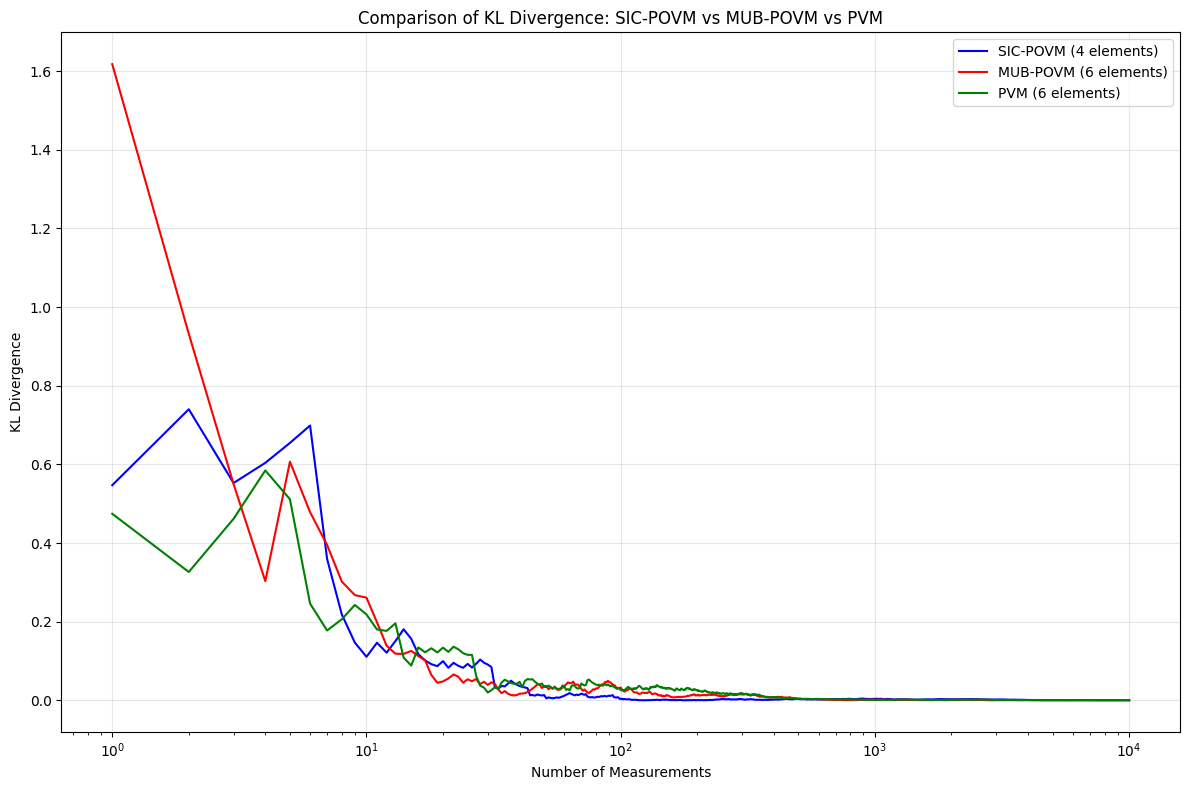

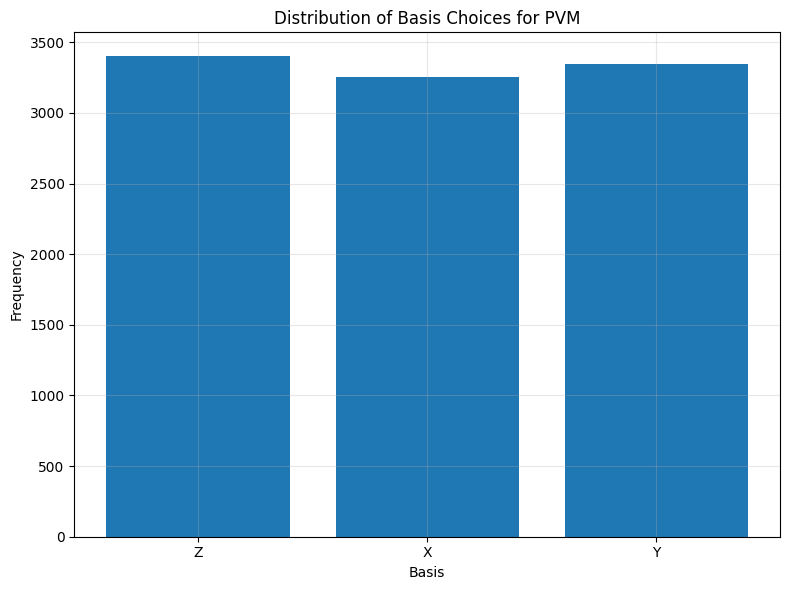

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import random
from scipy.spatial import distance, cKDTree
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# ==================== UTILITY FUNCTIONS ====================
def heaviside(z):
    """Implementation of the Heaviside function H(z)."""
    return 1 if z >= 0 else 0

def theta(z):
    """Implementation of the function Θ(z) = z·H(z)."""
    return z if z >= 0 else 0

def cartesian_to_spherical(point):
    """Converts a point from Cartesian coordinates (x,y,z) to spherical coordinates (theta, phi)."""
    x, y, z = point
    r = np.sqrt(x**2 + y**2 + z**2)  # Should be 1 for unit sphere
    theta = np.arccos(z / r) * 180 / np.pi
    phi = np.arctan2(y, x) * 180 / np.pi
    if phi < 0:
        phi += 360  # Convert to 0-360 range
    return theta, phi

def bloch_to_ket(point):
    """Converts a point on the Bloch sphere to a quantum state in ket notation."""
    x, y, z = point
    theta = np.arccos(z)
    phi = np.arctan2(y, x)
    alpha = np.cos(theta/2)
    beta_mag = np.sin(theta/2)
    beta_phase = phi

    # Nice formatting for complex numbers
    if abs(alpha) < 1e-10:
        alpha_str = "0"
    elif abs(1 - alpha) < 1e-10:
        alpha_str = "1"
    elif abs(-1 - alpha) < 1e-10:
        alpha_str = "-1"
    else:
        alpha_str = f"{alpha:.4f}"

    if abs(beta_mag) < 1e-10:
        beta_str = "0"
    else:
        if abs(beta_phase) < 1e-10:
            beta_str = f"{beta_mag:.4f}"
        elif abs(abs(beta_phase) - np.pi) < 1e-10:
            beta_str = f"-{beta_mag:.4f}"
        else:
            re = beta_mag * np.cos(beta_phase)
            im = beta_mag * np.sin(beta_phase)
            if abs(re) < 1e-10:
                re_str = ""
            elif abs(re) == 1:
                re_str = "-" if re < 0 else ""
            else:
                re_str = f"{re:.4f}"

            if abs(im) < 1e-10:
                beta_str = re_str or "0"
            elif abs(im - 1) < 1e-10 and not re_str:
                beta_str = "i"
            elif abs(im + 1) < 1e-10 and not re_str:
                beta_str = "-i"
            elif abs(im) == 1:
                beta_str = f"{re_str}{'-' if im < 0 else '+'}i"
            else:
                beta_str = f"{re_str}{'-' if im < 0 else '+'}{abs(im):.4f}i"

    if beta_str.startswith("+"):
        beta_str = beta_str[1:]

    if abs(beta_mag) < 1e-10:
        return "|0>"
    elif abs(alpha) < 1e-10:
        return "|1>"
    else:
        return f"{alpha_str}|0> + {beta_str}|1>"

def get_bloch_vector_from_pure_state(psi):
    """Calculates the Bloch vector corresponding to a pure quantum state."""
    sigma_x = np.array([[0, 1], [1, 0]])
    sigma_y = np.array([[0, -1j], [1j, 0]])
    sigma_z = np.array([[1, 0], [0, -1]])
    x = np.real(psi.conj().T @ sigma_x @ psi)[0, 0]
    y = np.real(psi.conj().T @ sigma_y @ psi)[0, 0]
    z = np.real(psi.conj().T @ sigma_z @ psi)[0, 0]
    return np.array([x, y, z])

def get_pure_state_from_bloch_vector(r):
    """Calculates a pure quantum state corresponding to a Bloch vector."""
    # Normalize the Bloch vector
    r = r / np.linalg.norm(r)
    theta = np.arccos(r[2])  # Zenith angle (from z-axis)
    phi = np.arctan2(r[1], r[0])  # Azimuthal angle (in xy-plane)
    psi = np.array([[np.cos(theta/2)],
                   [np.sin(theta/2) * np.exp(1j * phi)]])
    return psi

def get_density_matrix_from_pure_state(psi):
    """Calculates the density matrix corresponding to a pure quantum state."""
    return psi @ psi.conj().T

def generate_random_sphere_points(n):
    """Generates n points randomly distributed on the unit sphere."""
    points = np.random.randn(n, 3)
    norms = np.sqrt(np.sum(points**2, axis=1))
    points = points / norms[:, np.newaxis]
    return points

def generate_random_quantum_state():
    """Generates a random quantum state represented as a point on the Bloch sphere."""
    rho = np.random.randn(3)
    rho = rho / np.linalg.norm(rho)
    return rho

def select_random_points(points, num_select=2):
    """Randomly selects a specified number of points from a given array."""
    indices = np.random.choice(len(points), num_select, replace=False)
    return points[indices]

# ==================== DISTRIBUTION VERIFICATION FUNCTION ====================
def verify_uniform_distribution(points, num_bins=20):
    """
    Visualize the distribution of points on a sphere to verify uniformity.

    Args:
        points: Array of shape (n, 3) containing points on the unit sphere
        num_bins: Number of bins for the histograms

    Returns:
        tuple: (matplotlib figure, plotly figure) for the distribution plots
    """
    # Convert points to spherical coordinates
    theta_phi_points = np.array([cartesian_to_spherical(point) for point in points])
    thetas = theta_phi_points[:, 0]  # Polar angle (0 to 180 degrees)
    phis = theta_phi_points[:, 1]    # Azimuthal angle (0 to 360 degrees)

    # Create a figure with 3 subplots
    fig, axs = plt.subplots(1, 3, figsize=(20, 6))

    # 1. Histogram of theta values (should follow sin(theta) distribution for uniform sphere)
    axs[0].hist(thetas, bins=num_bins, alpha=0.7, density=True)

    # Generate the expected sin(theta) distribution
    theta_range = np.linspace(0, 180, 1000)
    sin_theta = np.sin(theta_range * np.pi / 180)
    sin_theta = sin_theta / np.trapz(sin_theta, theta_range)  # Normalize
    axs[0].plot(theta_range, sin_theta, 'r-', linewidth=2, label='Expected: sin(θ)')

    axs[0].set_xlabel('Theta (degrees)')
    axs[0].set_ylabel('Density')
    axs[0].set_title('Distribution of Polar Angle θ')
    axs[0].legend()

    # 2. Histogram of phi values (should be uniform for uniform sphere)
    axs[1].hist(phis, bins=num_bins, alpha=0.7, density=True)

    # Generate the expected uniform distribution for phi
    phi_expected = np.ones_like(theta_range) / 360
    phi_range = np.linspace(0, 360, 1000)
    axs[1].plot(phi_range, phi_expected, 'r-', linewidth=2, label='Expected: uniform')

    axs[1].set_xlabel('Phi (degrees)')
    axs[1].set_ylabel('Density')
    axs[1].set_title('Distribution of Azimuthal Angle φ')
    axs[1].legend()

    # 3. 2D Histogram (heatmap) of theta vs phi
    h, xedges, yedges = np.histogram2d(thetas, phis, bins=num_bins)

    # We need to normalize by sin(theta) to account for the smaller area near the poles
    theta_centers = 0.5 * (xedges[:-1] + xedges[1:])
    sin_weight = np.sin(theta_centers * np.pi / 180)

    # Normalize each row of the histogram by sin(theta)
    for i in range(h.shape[0]):
        if sin_weight[i] > 0:
            h[i, :] = h[i, :] / sin_weight[i]

    # Normalize the heatmap
    h = h / np.max(h)

    im = axs[2].imshow(h.T, origin='lower', aspect='auto',
                      extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
    axs[2].set_xlabel('Theta (degrees)')
    axs[2].set_ylabel('Phi (degrees)')
    axs[2].set_title('2D Distribution of Points (θ vs φ)')
    fig.colorbar(im, ax=axs[2], label='Normalized Density')

    plt.tight_layout()

    # Create a 3D visualization with density coloring using plotly
    # Build a KD-tree for efficient nearest neighbor search
    tree = cKDTree(points)

    # For each point, count neighbors within a fixed radius
    radius = 0.2  # Radius for density estimation
    densities = np.array([len(tree.query_ball_point(point, radius)) for point in points])

    # Normalize densities for coloring
    densities_norm = (densities - np.min(densities)) / (np.max(densities) - np.min(densities))

    # Create a plotly 3D scatter plot
    scatter_fig = go.Figure(data=[go.Scatter3d(
        x=points[:, 0],
        y=points[:, 1],
        z=points[:, 2],
        mode='markers',
        marker=dict(
            size=4,
            color=densities_norm,
            colorscale='Viridis',
            opacity=0.8,
            colorbar=dict(title="Normalized Local Density")
        ),
        hoverinfo='none'
    )])

    # Add a wireframe sphere for reference
    u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
    x = np.cos(u) * np.sin(v)
    y = np.sin(u) * np.sin(v)
    z = np.cos(v)

    scatter_fig.add_trace(go.Surface(
        x=x, y=y, z=z,
        colorscale=[[0, 'rgb(240, 240, 240)'], [1, 'rgb(240, 240, 240)']],
        opacity=0.2,
        showscale=False
    ))

    scatter_fig.update_layout(
        title='Density Visualization of Points on the Sphere',
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z',
            aspectmode='cube'
        ),
        margin=dict(l=0, r=0, b=0, t=40),
    )

    return fig, scatter_fig

# ==================== SIC-POVM FUNCTIONS ====================
def create_exact_sic_povm():
    """
    Creates the exact SIC-POVM for qubits as specified in the wiki article.
    |ψ1⟩ = |0⟩
    |ψ2⟩ = (1/3)|0⟩ + (2√2/3)|1⟩
    |ψ3⟩ = (1/3)|0⟩ + (2√2/3)e^(i2π/3)|1⟩
    |ψ4⟩ = (1/3)|0⟩ + (2√2/3)e^(i4π/3)|1⟩
    """
    # Define the four SIC-POVM state vectors in ket form
    psi1 = np.array([[1], [0]], dtype=complex)

    # For normalization, we need |a|² + |b|² = 1
    # With a = 1/3 and b = 2√2/3e^(iφ), this is satisfied
    coef = np.sqrt(8/9)  # The correct normalization factor

    psi2 = np.array([[1/3], [coef]], dtype=complex)
    psi3 = np.array([[1/3], [coef * np.exp(1j * 2 * np.pi / 3)]], dtype=complex)
    psi4 = np.array([[1/3], [coef * np.exp(1j * 4 * np.pi / 3)]], dtype=complex)

    # Calculate corresponding Bloch vectors
    bloch1 = np.array([0, 0, 1])  # |0⟩ state
    bloch2 = np.array([np.sqrt(8/9), 0, -1/3])
    bloch3 = np.array([-np.sqrt(2/9), np.sqrt(6/9), -1/3])
    bloch4 = np.array([-np.sqrt(2/9), -np.sqrt(6/9), -1/3])

    bloch_vectors = [bloch1, bloch2, bloch3, bloch4]
    sic_povm = [psi1, psi2, psi3, psi4]

    # Verify SIC-POVM properties
    verify_sic_povm(sic_povm, bloch_vectors)

    return sic_povm, bloch_vectors

def verify_sic_povm(povm_set, bloch_vectors):
    """Verifies if a set of vectors forms a valid SIC-POVM for qubits."""
    expected_overlap = 1/3

    n = len(povm_set)
    quantum_overlaps = []

    print("\nVerifying SIC-POVM properties:")
    # Check overlaps
    for i in range(n):
        for j in range(i+1, n):
            overlap = np.abs(povm_set[i].conj().T @ povm_set[j])[0, 0] ** 2
            quantum_overlaps.append(overlap)
            print(f"Overlap between elements {i+1} and {j+1}: {overlap:.6f} (expected: {expected_overlap:.6f})")

    # Check normalization
    for i, vec in enumerate(bloch_vectors):
        norm = np.linalg.norm(vec)
        print(f"Norm of Bloch vector {i+1}: {norm:.6f}")

    # Check that vectors sum to zero
    sum_vec = np.sum(bloch_vectors, axis=0)
    print(f"Sum of Bloch vectors: {sum_vec}")

    # Verify POVM property
    d = 2  # dimension (qubit)
    povm_sum = np.zeros((d, d), dtype=complex)
    for psi in povm_set:
        projector = psi @ psi.conj().T
        povm_element = projector / d  # Normalization for POVM
        povm_sum += povm_element

    print("\nSum of POVM elements:")
    print(povm_sum)
    identity_diff = np.linalg.norm(povm_sum - np.eye(d))
    print(f"Difference from identity matrix: {identity_diff:.6f}")

# ==================== VISUALIZATION FUNCTIONS ====================
def create_bloch_sphere_visualization(random_points, lambda_vectors, quantum_state, sic_bloch_vectors, transformed_lambdas=None):
    """Creates an interactive 3D visualization of the Bloch sphere with the points relevant to the protocol."""
    # Create mesh for the Bloch sphere
    phi = np.linspace(0, 2*np.pi, 100)
    theta = np.linspace(0, np.pi, 50)
    phi_grid, theta_grid = np.meshgrid(phi, theta)

    x_sphere = np.sin(theta_grid) * np.cos(phi_grid)
    y_sphere = np.sin(theta_grid) * np.sin(phi_grid)
    z_sphere = np.cos(theta_grid)

    # Create plotly figure
    fig = go.Figure()

    # Add transparent sphere surface
    fig.add_trace(go.Surface(
        x=x_sphere, y=y_sphere, z=z_sphere,
        colorscale=[[0, 'rgb(240, 240, 240)'], [1, 'rgb(240, 240, 240)']],
        opacity=0.2,
        showscale=False,
        name='Bloch Sphere'
    ))

    # Add coordinate axes
    axis_length = 1.2
    fig.add_trace(go.Scatter3d(
        x=[-axis_length, axis_length], y=[0, 0], z=[0, 0],
        mode='lines',
        line=dict(color='red', width=4),
        name='X-axis'
    ))

    fig.add_trace(go.Scatter3d(
        x=[0, 0], y=[-axis_length, axis_length], z=[0, 0],
        mode='lines',
        line=dict(color='green', width=4),
        name='Y-axis'
    ))

    fig.add_trace(go.Scatter3d(
        x=[0, 0], y=[0, 0], z=[-axis_length, axis_length],
        mode='lines',
        line=dict(color='blue', width=4),
        name='Z-axis'
    ))

    # Add random points
    if random_points is not None and len(random_points) > 0:
        fig.add_trace(go.Scatter3d(
            x=random_points[:, 0], y=random_points[:, 1], z=random_points[:, 2],
            mode='markers',
            marker=dict(
                size=3,
                color='gray',
                opacity=0.5
            ),
            name='Random Points'
        ))

    # Add lambda vectors
    colors = ['red', 'green']
    for i, lambda_vec in enumerate(lambda_vectors):
        fig.add_trace(go.Scatter3d(
            x=[0, lambda_vec[0]], y=[0, lambda_vec[1]], z=[0, lambda_vec[2]],
            mode='lines',
            line=dict(color=colors[i], width=4),
            name=f'λ{i+1}'
        ))

        fig.add_trace(go.Scatter3d(
            x=[lambda_vec[0]], y=[lambda_vec[1]], z=[lambda_vec[2]],
            mode='markers+text',
            marker=dict(size=8, color=colors[i]),
            text=[f'λ{i+1}'],
            textposition="top center",
            name=f'λ{i+1} Point'
        ))

    # Add transformed lambda vectors if provided
    if transformed_lambdas is not None:
        for i, lambda_prime in enumerate(transformed_lambdas):
            if not np.array_equal(lambda_vectors[i], lambda_prime):
                fig.add_trace(go.Scatter3d(
                    x=[0, lambda_prime[0]], y=[0, lambda_prime[1]], z=[0, lambda_prime[2]],
                    mode='lines',
                    line=dict(color=colors[i], width=4, dash='dash'),
                    name=f'λ{i+1}\''
                ))

                fig.add_trace(go.Scatter3d(
                    x=[lambda_prime[0]], y=[lambda_prime[1]], z=[lambda_prime[2]],
                    mode='markers+text',
                    marker=dict(size=8, color=colors[i], symbol='circle-open'),
                    text=[f'λ{i+1}\''],
                    textposition="top center",
                    name=f'λ{i+1}\' Point'
                ))

    # Add quantum state
    fig.add_trace(go.Scatter3d(
        x=[0, quantum_state[0]], y=[0, quantum_state[1]], z=[0, quantum_state[2]],
        mode='lines',
        line=dict(color='purple', width=4),
        name='Quantum State'
    ))

    fig.add_trace(go.Scatter3d(
        x=[quantum_state[0]], y=[quantum_state[1]], z=[quantum_state[2]],
        mode='markers+text',
        marker=dict(size=10, color='purple'),
        text=['ρ'],
        textposition="top center",
        name='Quantum State Point'
    ))

    # Add SIC-POVM elements
    povm_colors = ['blue', 'orange', 'cyan', 'magenta']
    for i, vec in enumerate(sic_bloch_vectors):
        fig.add_trace(go.Scatter3d(
            x=[0, vec[0]], y=[0, vec[1]], z=[0, vec[2]],
            mode='lines',
            line=dict(color=povm_colors[i], width=2, dash='dot'),
            name=f'POVM Element {i+1}'
        ))

        fig.add_trace(go.Scatter3d(
            x=[vec[0]], y=[vec[1]], z=[vec[2]],
            mode='markers+text',
            marker=dict(size=8, color=povm_colors[i]),
            text=[f'POVM {i+1}'],
            textposition="top center",
            name=f'POVM Point {i+1}'
        ))

    # Configure layout
    fig.update_layout(
        title='Bloch Sphere Visualization for Quantum Protocol',
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z',
            aspectmode='cube'
        ),
        margin=dict(l=0, r=0, b=0, t=40),
        legend=dict(
            yanchor="top",
            y=0.99,
            xanchor="left",
            x=0.01
        )
    )

    return fig

# ==================== KL DIVERGENCE FUNCTION ====================
def improved_kl_divergence(p, q):
    """
    Calculates the Kullback-Leibler divergence between two probability distributions
    with improved numerical stability.
    """
    # Ensure p and q are numpy arrays
    p = np.array(p)
    q = np.array(q)

    # Normalize to ensure proper probability distributions
    p = p / np.sum(p)
    q = q / np.sum(q)

    # Avoid division by zero and log(0) issues
    epsilon = 1e-10
    q_safe = np.maximum(q, epsilon)

    # Calculate KL divergence
    mask = p > 0  # Only consider where p > 0 (since 0*log(0/q) = 0)
    kl_terms = p[mask] * np.log(p[mask] / q_safe[mask])
    kl_div = np.sum(kl_terms)

    return kl_div

def wasserstein_distance(p, q):
    """
    Calculates the Wasserstein distance (Earth Mover's Distance) between
    two discrete probability distributions.
    """
    p = np.array(p) / np.sum(p)
    q = np.array(q) / np.sum(q)

    p_cumsum = np.cumsum(p)
    q_cumsum = np.cumsum(q)
    return np.sum(np.abs(p_cumsum - q_cumsum))

# ==================== THEORETICAL PROBABILITY CALCULATION ====================
def calculate_theoretical_quantum_probs(quantum_state, bloch_vectors):
    """
    Calculate the theoretical quantum probabilities using Born's rule:
    p(b|ρ, B_b) = p_b(1 + r·t_b) where p_b = 1/4 for SIC-POVM
    """
    p_b = 1/4  # For 4-element SIC-POVM in dimension 2

    probs = []
    for b_vec in bloch_vectors:
        prob = p_b * (1 + np.dot(quantum_state, b_vec))
        probs.append(prob)

    return np.array(probs)

# ==================== CONTINUOUS KL DIVERGENCE TRACKING ====================
def optimized_protocol_with_continuous_tracking(quantum_state, sic_bloch_vectors, num_measurements=10000):
    """
    Optimized implementation of the protocol with continuous tracking of KL divergence.
    Returns an array of KL divergence values for each measurement.
    """
    # Get theoretical quantum probabilities
    quantum_probs = calculate_theoretical_quantum_probs(quantum_state, sic_bloch_vectors)

    # Track outcomes and KL divergence after each measurement
    outcomes = []
    kl_values = []

    # Start with equal counts for all outcomes to avoid division by zero
    counts = np.ones(len(sic_bloch_vectors)) * 0.1  # Small initial value

    # Protocol implementation
    for i in range(1, num_measurements + 1):
        # 1. Generate two random vectors uniformly on the unit sphere for each measurement
        lambda_vectors = generate_random_sphere_points(2)

        # 2. Alice calculates bits based on the quantum state
        c1 = heaviside(np.dot(quantum_state, lambda_vectors[0]))
        c2 = heaviside(np.dot(quantum_state, lambda_vectors[1]))

        # 3. Bob transforms lambda vectors
        lambda_prime1 = lambda_vectors[0] if c1 == 1 else -lambda_vectors[0]
        lambda_prime2 = lambda_vectors[1] if c2 == 1 else -lambda_vectors[1]

        # 4. Bob selects a measurement direction uniformly
        selected_index = np.random.choice(len(sic_bloch_vectors))
        selected_y = sic_bloch_vectors[selected_index]

        # 5. Bob decides which λ' to use
        if abs(np.dot(lambda_prime1, selected_y)) >= abs(np.dot(lambda_prime2, selected_y)):
            selected_lambda = lambda_prime1
        else:
            selected_lambda = lambda_prime2

        # 6. Calculate θ values
        theta_values = np.array([theta(np.dot(y, selected_lambda)) for y in sic_bloch_vectors])

        # 7. Calculate denominator
        p_values = np.array([1/len(sic_bloch_vectors)] * len(sic_bloch_vectors))
        denominator = np.sum(p_values * theta_values)

        # 8. Determine outcome
        if denominator > 0:
            outcome_probs = p_values * theta_values / denominator
            if np.sum(outcome_probs) > 0:
                outcome_probs = outcome_probs / np.sum(outcome_probs)
                outcome = np.random.choice(len(sic_bloch_vectors), p=outcome_probs)
            else:
                outcome = np.random.choice(len(sic_bloch_vectors))
        else:
            outcome = np.random.choice(len(sic_bloch_vectors))

        # Add outcome to list
        outcomes.append(outcome)

        # Update counts
        counts[outcome] += 1

        # Calculate current frequencies
        freqs = counts / (i + len(sic_bloch_vectors) * 0.1)  # Adjust for initial counts

        # Calculate KL divergence
        kl_div = improved_kl_divergence(freqs, quantum_probs)
        kl_values.append(kl_div)

    return np.array(kl_values)

# ==================== FULL VISUALIZATION SIMULATION FUNCTION ====================
def perform_complete_visualization_simulation(n_points=1000, n_measurements=10000):
    """
    Complete simulation combining visualization of the Bloch sphere with proper protocol implementation.
    """
    # Set random seed for reproducibility
    np.random.seed(42)
    random.seed(42)

    # Dictionary to store simulation data
    simulation_data = {}

    print("=== Simulation of 'Classical Cost of Transmitting a Qubit' Protocol ===")
    print("=================================================================")
    print(f"Number of random points: {n_points}")
    print(f"Number of measurements: {n_measurements}")
    print("=================================================================")

    # STEP 1: Generate random points on the unit sphere
    print("\nGenerating random points on the unit sphere...")
    random_points = generate_random_sphere_points(n_points)

    # NEW STEP: Verify uniform distribution of the generated points
    print("\nVerifying uniform distribution of random points...")
    dist_fig, density_fig = verify_uniform_distribution(random_points)

    # STEP 2: Randomly select one quantum state from the random points
    print("\nRandomly selecting a quantum state...")
    quantum_state = select_random_points(random_points, num_select=1)[0]
    print(f"Selected quantum state: {quantum_state}")
    print(f"Quantum state in ket notation: {bloch_to_ket(quantum_state)}")

    # STEP 3: Randomly select two lambda vectors from the random points
    print("\nRandomly selecting two lambda vectors...")
    lambda_vectors = select_random_points(random_points, num_select=2)
    print(f"Selected lambda vectors:")
    for i, vec in enumerate(lambda_vectors):
        print(f"λ{i+1}: {vec}, norm: {np.linalg.norm(vec):.6f}")

    # STEP 4: Create the SIC-POVM
    print("\nCreating the SIC-POVM...")
    _, sic_bloch_vectors = create_exact_sic_povm()

    # STEP 5: Calculate the theoretical quantum probabilities
    print("\nCalculating theoretical quantum probabilities...")
    quantum_probs = calculate_theoretical_quantum_probs(quantum_state, sic_bloch_vectors)
    print(f"Quantum probabilities: {quantum_probs}")

    print(f"Quantum probabilities: {quantum_probs}")

    # STEP 6: Calculate transformed lambda vectors based on the quantum state
    print("\nCalculating transformed lambda vectors...")
    c1 = heaviside(np.dot(quantum_state, lambda_vectors[0]))
    c2 = heaviside(np.dot(quantum_state, lambda_vectors[1]))

    print(f"c1 = H(ρ·λ1) = H({np.dot(quantum_state, lambda_vectors[0]):.6f}) = {c1}")
    print(f"c2 = H(ρ·λ2) = H({np.dot(quantum_state, lambda_vectors[1]):.6f}) = {c2}")

    transformed_lambdas = [
        lambda_vectors[0] if c1 == 1 else -lambda_vectors[0],
        lambda_vectors[1] if c2 == 1 else -lambda_vectors[1]
    ]

    print(f"λ1' = {transformed_lambdas[0]}")
    print(f"λ2' = {transformed_lambdas[1]}")

    # STEP 7: Create visualization of the Bloch sphere with all points
    print("\nCreating Bloch sphere visualization...")
    bloch_sphere_fig = create_bloch_sphere_visualization(
        random_points, lambda_vectors, quantum_state, sic_bloch_vectors, transformed_lambdas)

    # STEP 8: Run the protocol with continuous KL tracking using new random lambda vectors for each iteration
    print("\nRunning protocol with continuous KL tracking...")
    kl_values = optimized_protocol_with_continuous_tracking(
        quantum_state, sic_bloch_vectors, n_measurements)

    # STEP 9: Create plot of KL divergence vs number of measurements
    print("\nCreating KL divergence plot...")
    kl_fig = plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(kl_values) + 1), kl_values)
    plt.xscale('log')
    plt.xlabel('Number of Measurements')
    plt.ylabel('KL Divergence')
    plt.title('KL Divergence vs Number of Measurements')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    # Save simulation data
    simulation_data['random_points'] = random_points
    simulation_data['lambda_vectors'] = lambda_vectors
    simulation_data['quantum_state'] = quantum_state
    simulation_data['sic_bloch_vectors'] = sic_bloch_vectors
    simulation_data['quantum_probs'] = quantum_probs
    simulation_data['transformed_lambdas'] = transformed_lambdas
    simulation_data['kl_values'] = kl_values
    simulation_data['bloch_sphere_fig'] = bloch_sphere_fig
    simulation_data['distribution_fig'] = dist_fig
    simulation_data['density_fig'] = density_fig
    simulation_data['kl_fig'] = kl_fig

    print("\n=== Simulation complete ===")
    print(f"Final KL divergence: {kl_values[-1]:.6f}")

    # Display the distribution plots
    plt.figure(dist_fig.number)
    plt.show()
    density_fig.show()

    # Display the Bloch sphere visualization
    bloch_sphere_fig.show()

    # Display the KL divergence plot
    plt.figure(kl_fig.number)
    plt.show()

    return simulation_data

# ==================== MUB-POVM FUNCTIONS ====================
def create_mub_povm():
    """
    Creates the MUB-POVM for qubits based on the computational basis (Z),
    Hadamard basis (X), and Y basis.

    Returns:
        tuple: (quantum_states, bloch_vectors) for the MUB-POVM elements
    """
    # Define the six MUB-POVM state vectors

    # Z basis (computational basis)
    psi1 = np.array([[1], [0]], dtype=complex)  # |0⟩
    psi2 = np.array([[0], [1]], dtype=complex)  # |1⟩

    # X basis (Hadamard basis)
    psi3 = np.array([[1/np.sqrt(2)], [1/np.sqrt(2)]], dtype=complex)  # |+⟩
    psi4 = np.array([[1/np.sqrt(2)], [-1/np.sqrt(2)]], dtype=complex)  # |-⟩

    # Y basis
    psi5 = np.array([[1/np.sqrt(2)], [1j/np.sqrt(2)]], dtype=complex)  # |+i⟩
    psi6 = np.array([[1/np.sqrt(2)], [-1j/np.sqrt(2)]], dtype=complex)  # |-i⟩

    # Calculate corresponding Bloch vectors
    bloch1 = np.array([0, 0, 1])     # |0⟩ state
    bloch2 = np.array([0, 0, -1])    # |1⟩ state
    bloch3 = np.array([1, 0, 0])     # |+⟩ state
    bloch4 = np.array([-1, 0, 0])    # |-⟩ state
    bloch5 = np.array([0, 1, 0])     # |+i⟩ state
    bloch6 = np.array([0, -1, 0])    # |-i⟩ state

    mub_povm_states = [psi1, psi2, psi3, psi4, psi5, psi6]
    mub_bloch_vectors = [bloch1, bloch2, bloch3, bloch4, bloch5, bloch6]

    # Verify MUB-POVM properties
    verify_mub_povm(mub_povm_states, mub_bloch_vectors)

    return mub_povm_states, mub_bloch_vectors

def verify_mub_povm(povm_set, bloch_vectors):
    """Verifies if a set of vectors forms a valid MUB-POVM for qubits."""
    n = len(povm_set)

    print("\nVerifying MUB-POVM properties:")

    # Check basis by basis
    bases = [("Z", [0, 1]), ("X", [2, 3]), ("Y", [4, 5])]

    # Check overlaps within each basis (should be 0 for orthogonal states)
    for basis_name, indices in bases:
        i, j = indices
        overlap = np.abs(povm_set[i].conj().T @ povm_set[j])[0, 0] ** 2
        print(f"Overlap within {basis_name} basis: {overlap:.6f} (expected: 0)")

    # Check overlaps between different bases (should be 1/2 for MUB)
    cross_basis_pairs = [
        ("Z-X", 0, 2), ("Z-X", 0, 3), ("Z-X", 1, 2), ("Z-X", 1, 3),
        ("Z-Y", 0, 4), ("Z-Y", 0, 5), ("Z-Y", 1, 4), ("Z-Y", 1, 5),
        ("X-Y", 2, 4), ("X-Y", 2, 5), ("X-Y", 3, 4), ("X-Y", 3, 5)
    ]

    for basis_pair, i, j in cross_basis_pairs:
        overlap = np.abs(povm_set[i].conj().T @ povm_set[j])[0, 0] ** 2
        print(f"Overlap between {basis_pair} states {i+1} and {j+1}: {overlap:.6f} (expected: 0.5)")

    # Check that vectors are on the Bloch sphere (norm = 1)
    for i, vec in enumerate(bloch_vectors):
        norm = np.linalg.norm(vec)
        print(f"Norm of Bloch vector {i+1}: {norm:.6f}")

    # Verify POVM property (properly normalized)
    d = 2  # dimension (qubit)
    povm_sum = np.zeros((d, d), dtype=complex)

    # For MUB-POVM with 6 elements from 3 bases, each element gets weight 1/3
    weight = 1/3

    for psi in povm_set:
        projector = psi @ psi.conj().T
        povm_element = weight * projector  # Each basis contributes equally
        povm_sum += povm_element

    print("\nSum of POVM elements:")
    print(povm_sum)
    identity_diff = np.linalg.norm(povm_sum - np.eye(d))
    print(f"Difference from identity matrix: {identity_diff:.6f}")

# ==================== MUB PROBABILITY CALCULATION ====================
def calculate_theoretical_mub_quantum_probs(quantum_state, bloch_vectors):
    """
    Calculate the theoretical quantum probabilities for MUB-POVM using Born's rule.
    For properly normalized MUB-POVM, each element gets weight 1/3.
    """
    p_b = 1/6  # Base probability for 6 elements (each with weight 1/3)

    probs = []
    for b_vec in bloch_vectors:
        # For MUB-POVM, the formula is p_b * (1 + r·t_b)
        # The 1/3 weight is already included in p_b
        prob = p_b * (1 + np.dot(quantum_state, b_vec))
        probs.append(prob)

    return np.array(probs)

# ==================== MUB PROTOCOL IMPLEMENTATION ====================
def optimized_mub_protocol_with_continuous_tracking(quantum_state, mub_bloch_vectors, num_measurements=10000):
    """
    Optimized implementation of the protocol with MUB-POVM and continuous tracking of KL divergence.
    Returns an array of KL divergence values for each measurement.
    """
    # Get theoretical quantum probabilities
    quantum_probs = calculate_theoretical_mub_quantum_probs(quantum_state, mub_bloch_vectors)

    # Track outcomes and KL divergence after each measurement
    outcomes = []
    kl_values = []

    # Start with equal counts for all outcomes to avoid division by zero
    counts = np.ones(len(mub_bloch_vectors)) * 0.1  # Small initial value

    # Protocol implementation
    for i in range(1, num_measurements + 1):
        # 1. Generate two random vectors uniformly on the unit sphere for each measurement
        lambda_vectors = generate_random_sphere_points(2)

        # 2. Alice calculates bits based on the quantum state
        c1 = heaviside(np.dot(quantum_state, lambda_vectors[0]))
        c2 = heaviside(np.dot(quantum_state, lambda_vectors[1]))

        # 3. Bob transforms lambda vectors
        lambda_prime1 = lambda_vectors[0] if c1 == 1 else -lambda_vectors[0]
        lambda_prime2 = lambda_vectors[1] if c2 == 1 else -lambda_vectors[1]

        # 4. Bob selects a measurement direction uniformly
        selected_index = np.random.choice(len(mub_bloch_vectors))
        selected_y = mub_bloch_vectors[selected_index]

        # 5. Bob decides which λ' to use
        if abs(np.dot(lambda_prime1, selected_y)) >= abs(np.dot(lambda_prime2, selected_y)):
            selected_lambda = lambda_prime1
        else:
            selected_lambda = lambda_prime2

        # 6. Calculate θ values
        theta_values = np.array([theta(np.dot(y, selected_lambda)) for y in mub_bloch_vectors])

        # 7. Calculate denominator
        p_values = np.array([1/len(mub_bloch_vectors)] * len(mub_bloch_vectors))
        denominator = np.sum(p_values * theta_values)

        # 8. Determine outcome
        if denominator > 0:
            outcome_probs = p_values * theta_values / denominator
            if np.sum(outcome_probs) > 0:
                outcome_probs = outcome_probs / np.sum(outcome_probs)
                outcome = np.random.choice(len(mub_bloch_vectors), p=outcome_probs)
            else:
                outcome = np.random.choice(len(mub_bloch_vectors))
        else:
            outcome = np.random.choice(len(mub_bloch_vectors))

        # Add outcome to list
        outcomes.append(outcome)

        # Update counts
        counts[outcome] += 1

        # Calculate current frequencies
        freqs = counts / (i + len(mub_bloch_vectors) * 0.1)  # Adjust for initial counts

        # Calculate KL divergence
        kl_div = improved_kl_divergence(freqs, quantum_probs)
        kl_values.append(kl_div)

    return np.array(kl_values)

# ==================== MODIFIED VISUALIZATION FUNCTION FOR MUB-POVM ====================
def create_bloch_sphere_mub_visualization(random_points, lambda_vectors, quantum_state, mub_bloch_vectors, transformed_lambdas=None):
    """Creates an interactive 3D visualization of the Bloch sphere with MUB-POVM elements."""
    # Create mesh for the Bloch sphere
    phi = np.linspace(0, 2*np.pi, 100)
    theta = np.linspace(0, np.pi, 50)
    phi_grid, theta_grid = np.meshgrid(phi, theta)

    x_sphere = np.sin(theta_grid) * np.cos(phi_grid)
    y_sphere = np.sin(theta_grid) * np.sin(phi_grid)
    z_sphere = np.cos(theta_grid)

    # Create plotly figure
    fig = go.Figure()

    # Add transparent sphere surface
    fig.add_trace(go.Surface(
        x=x_sphere, y=y_sphere, z=z_sphere,
        colorscale=[[0, 'rgb(240, 240, 240)'], [1, 'rgb(240, 240, 240)']],
        opacity=0.2,
        showscale=False,
        name='Bloch Sphere'
    ))

    # Add coordinate axes
    axis_length = 1.2
    fig.add_trace(go.Scatter3d(
        x=[-axis_length, axis_length], y=[0, 0], z=[0, 0],
        mode='lines',
        line=dict(color='red', width=4),
        name='X-axis'
    ))

    fig.add_trace(go.Scatter3d(
        x=[0, 0], y=[-axis_length, axis_length], z=[0, 0],
        mode='lines',
        line=dict(color='green', width=4),
        name='Y-axis'
    ))

    fig.add_trace(go.Scatter3d(
        x=[0, 0], y=[0, 0], z=[-axis_length, axis_length],
        mode='lines',
        line=dict(color='blue', width=4),
        name='Z-axis'
    ))

    # Add random points
    if random_points is not None and len(random_points) > 0:
        fig.add_trace(go.Scatter3d(
            x=random_points[:, 0], y=random_points[:, 1], z=random_points[:, 2],
            mode='markers',
            marker=dict(
                size=3,
                color='gray',
                opacity=0.5
            ),
            name='Random Points'
        ))

    # Add lambda vectors
    colors = ['red', 'green']
    for i, lambda_vec in enumerate(lambda_vectors):
        fig.add_trace(go.Scatter3d(
            x=[0, lambda_vec[0]], y=[0, lambda_vec[1]], z=[0, lambda_vec[2]],
            mode='lines',
            line=dict(color=colors[i], width=4),
            name=f'λ{i+1}'
        ))

        fig.add_trace(go.Scatter3d(
            x=[lambda_vec[0]], y=[lambda_vec[1]], z=[lambda_vec[2]],
            mode='markers+text',
            marker=dict(size=8, color=colors[i]),
            text=[f'λ{i+1}'],
            textposition="top center",
            name=f'λ{i+1} Point'
        ))

    # Add transformed lambda vectors if provided
    if transformed_lambdas is not None:
        for i, lambda_prime in enumerate(transformed_lambdas):
            if not np.array_equal(lambda_vectors[i], lambda_prime):
                fig.add_trace(go.Scatter3d(
                    x=[0, lambda_prime[0]], y=[0, lambda_prime[1]], z=[0, lambda_prime[2]],
                    mode='lines',
                    line=dict(color=colors[i], width=4, dash='dash'),
                    name=f'λ{i+1}\''
                ))

                fig.add_trace(go.Scatter3d(
                    x=[lambda_prime[0]], y=[lambda_prime[1]], z=[lambda_prime[2]],
                    mode='markers+text',
                    marker=dict(size=8, color=colors[i], symbol='circle-open'),
                    text=[f'λ{i+1}\''],
                    textposition="top center",
                    name=f'λ{i+1}\' Point'
                ))

    # Add quantum state
    fig.add_trace(go.Scatter3d(
        x=[0, quantum_state[0]], y=[0, quantum_state[1]], z=[0, quantum_state[2]],
        mode='lines',
        line=dict(color='purple', width=4),
        name='Quantum State'
    ))

    fig.add_trace(go.Scatter3d(
        x=[quantum_state[0]], y=[quantum_state[1]], z=[quantum_state[2]],
        mode='markers+text',
        marker=dict(size=10, color='purple'),
        text=['ρ'],
        textposition="top center",
        name='Quantum State Point'
    ))

    # Add MUB-POVM elements (with extended colors for 6 elements)
    povm_colors = ['blue', 'orange', 'cyan', 'magenta', 'yellow', 'lime']

    # Group MUB elements by basis
    basis_names = ["Z+", "Z-", "X+", "X-", "Y+", "Y-"]

    for i, vec in enumerate(mub_bloch_vectors):
        fig.add_trace(go.Scatter3d(
            x=[0, vec[0]], y=[0, vec[1]], z=[0, vec[2]],
            mode='lines',
            line=dict(color=povm_colors[i], width=2, dash='dot'),
            name=f'{basis_names[i]} basis'
        ))

        fig.add_trace(go.Scatter3d(
            x=[vec[0]], y=[vec[1]], z=[vec[2]],
            mode='markers+text',
            marker=dict(size=8, color=povm_colors[i]),
            text=[f'{basis_names[i]}'],
            textposition="top center",
            name=f'{basis_names[i]} point'
        ))

    # Configure layout
    fig.update_layout(
        title='Bloch Sphere with MUB-POVM Elements',
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z',
            aspectmode='cube'
        ),
        margin=dict(l=0, r=0, b=0, t=40),
        legend=dict(
            yanchor="top",
            y=0.99,
            xanchor="left",
            x=0.01
        )
    )

    return fig

# ==================== MUB SIMULATION FUNCTION ====================
def perform_mub_simulation(n_points=1000, n_measurements=10000):
    """
    Performs a simulation of the quantum protocol using MUB-POVM.
    """
    # Set random seed for reproducibility
    np.random.seed(43)  # Different seed from SIC-POVM simulation
    random.seed(43)

    # Dictionary to store simulation data
    simulation_data = {}

    print("=== Simulation of 'Classical Cost of Transmitting a Qubit' Protocol with MUB-POVM ===")
    print("=================================================================")
    print(f"Number of random points: {n_points}")
    print(f"Number of measurements: {n_measurements}")
    print("=================================================================")

    # STEP 1: Generate random points on the unit sphere
    print("\nGenerating random points on the unit sphere...")
    random_points = generate_random_sphere_points(n_points)

    # STEP 2: Randomly select one quantum state from the random points
    print("\nRandomly selecting a quantum state...")
    quantum_state = select_random_points(random_points, num_select=1)[0]
    print(f"Selected quantum state: {quantum_state}")
    print(f"Quantum state in ket notation: {bloch_to_ket(quantum_state)}")

    # STEP 3: Randomly select two lambda vectors from the random points
    print("\nRandomly selecting two lambda vectors...")
    lambda_vectors = select_random_points(random_points, num_select=2)
    print(f"Selected lambda vectors:")
    for i, vec in enumerate(lambda_vectors):
        print(f"λ{i+1}: {vec}, norm: {np.linalg.norm(vec):.6f}")

    # STEP 4: Create the MUB-POVM
    print("\nCreating the MUB-POVM...")
    _, mub_bloch_vectors = create_mub_povm()

    # STEP 5: Calculate the theoretical quantum probabilities
    print("\nCalculating theoretical quantum probabilities...")
    quantum_probs = calculate_theoretical_mub_quantum_probs(quantum_state, mub_bloch_vectors)
    print(f"Quantum probabilities: {quantum_probs}")

    # STEP 6: Calculate transformed lambda vectors based on the quantum state
    print("\nCalculating transformed lambda vectors...")
    c1 = heaviside(np.dot(quantum_state, lambda_vectors[0]))
    c2 = heaviside(np.dot(quantum_state, lambda_vectors[1]))

    print(f"c1 = H(ρ·λ1) = H({np.dot(quantum_state, lambda_vectors[0]):.6f}) = {c1}")
    print(f"c2 = H(ρ·λ2) = H({np.dot(quantum_state, lambda_vectors[1]):.6f}) = {c2}")

    transformed_lambdas = [
        lambda_vectors[0] if c1 == 1 else -lambda_vectors[0],
        lambda_vectors[1] if c2 == 1 else -lambda_vectors[1]
    ]

    print(f"λ1' = {transformed_lambdas[0]}")
    print(f"λ2' = {transformed_lambdas[1]}")

    # STEP 7: Create visualization of the Bloch sphere with all points
    print("\nCreating Bloch sphere visualization...")
    # Use the MUB-specific visualization function
    bloch_sphere_fig = create_bloch_sphere_mub_visualization(
        random_points, lambda_vectors, quantum_state, mub_bloch_vectors, transformed_lambdas)

    # STEP 8: Run the protocol with continuous KL tracking using new random lambda vectors for each iteration
    print("\nRunning protocol with continuous KL tracking...")
    kl_values = optimized_mub_protocol_with_continuous_tracking(
        quantum_state, mub_bloch_vectors, n_measurements)

    # STEP 9: Create plot of KL divergence vs number of measurements
    print("\nCreating KL divergence plot...")
    kl_fig = plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(kl_values) + 1), kl_values)
    plt.xscale('log')
    plt.xlabel('Number of Measurements')
    plt.ylabel('KL Divergence')
    plt.title('KL Divergence vs Number of Measurements (MUB-POVM)')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    # Save simulation data
    simulation_data['random_points'] = random_points
    simulation_data['lambda_vectors'] = lambda_vectors
    simulation_data['quantum_state'] = quantum_state
    simulation_data['mub_bloch_vectors'] = mub_bloch_vectors
    simulation_data['quantum_probs'] = quantum_probs
    simulation_data['transformed_lambdas'] = transformed_lambdas
    simulation_data['kl_values'] = kl_values
    simulation_data['bloch_sphere_fig'] = bloch_sphere_fig
    simulation_data['kl_fig'] = kl_fig

    print("\n=== Simulation complete ===")
    print(f"Final KL divergence: {kl_values[-1]:.6f}")

    # Display the Bloch sphere visualization
    bloch_sphere_fig.show()

    # Display the KL divergence plot
    plt.figure(kl_fig.number)
    plt.show()

    return simulation_data

# ==================== PVM FUNCTIONS ====================
def create_pvm():
    """
    Creates a standard PVM for qubits based on three mutually orthogonal axes
    on the Bloch sphere (X, Y, Z directions).

    Returns:
        tuple: (quantum_states, bloch_vectors) for the PVM elements
    """
    # Define the PVM state vectors - using standard basis (Z) and pairs of orthogonal states

    # Z basis (computational basis)
    psi1 = np.array([[1], [0]], dtype=complex)  # |0⟩
    psi2 = np.array([[0], [1]], dtype=complex)  # |1⟩

    # X basis (Hadamard basis)
    psi3 = np.array([[1/np.sqrt(2)], [1/np.sqrt(2)]], dtype=complex)  # |+⟩
    psi4 = np.array([[1/np.sqrt(2)], [-1/np.sqrt(2)]], dtype=complex)  # |-⟩

    # Y basis
    psi5 = np.array([[1/np.sqrt(2)], [1j/np.sqrt(2)]], dtype=complex)  # |+i⟩
    psi6 = np.array([[1/np.sqrt(2)], [-1j/np.sqrt(2)]], dtype=complex)  # |-i⟩

    # Calculate corresponding Bloch vectors
    bloch1 = np.array([0, 0, 1])     # |0⟩ state
    bloch2 = np.array([0, 0, -1])    # |1⟩ state
    bloch3 = np.array([1, 0, 0])     # |+⟩ state
    bloch4 = np.array([-1, 0, 0])    # |-⟩ state
    bloch5 = np.array([0, 1, 0])     # |+i⟩ state
    bloch6 = np.array([0, -1, 0])    # |-i⟩ state

    pvm_states = [psi1, psi2, psi3, psi4, psi5, psi6]
    pvm_bloch_vectors = [bloch1, bloch2, bloch3, bloch4, bloch5, bloch6]

    # Verify PVM properties
    verify_pvm(pvm_states, pvm_bloch_vectors)

    return pvm_states, pvm_bloch_vectors

def verify_pvm(pvm_set, bloch_vectors):
    """Verifies if a set of vectors forms a valid PVM for qubits."""
    n = len(pvm_set)

    print("\nVerifying PVM properties:")

    # Group states by basis
    bases = [("Z", [0, 1]), ("X", [2, 3]), ("Y", [4, 5])]

    # Check orthogonality within each basis
    for basis_name, indices in bases:
        i, j = indices
        overlap = np.abs(pvm_set[i].conj().T @ pvm_set[j])[0, 0] ** 2
        print(f"Overlap within {basis_name} basis: {overlap:.6f} (expected: 0)")

    # Check completeness within each basis
    for basis_name, indices in bases:
        i, j = indices
        sum_projectors = pvm_set[i] @ pvm_set[i].conj().T + pvm_set[j] @ pvm_set[j].conj().T
        identity_diff = np.linalg.norm(sum_projectors - np.eye(2))
        print(f"Completeness in {basis_name} basis: sum of projectors differs from identity by {identity_diff:.6f}")

    # Check that vectors are on the Bloch sphere (norm = 1)
    for i, vec in enumerate(bloch_vectors):
        norm = np.linalg.norm(vec)
        print(f"Norm of Bloch vector {i+1}: {norm:.6f}")

# ==================== PVM PROTOCOL IMPLEMENTATION ====================
def optimized_pvm_protocol_with_tracking(quantum_state, pvm_bloch_vectors, num_measurements=10000):
    """
    Optimized implementation of the protocol with PVM and continuous tracking of KL divergence.
    Returns an array of KL divergence values for each measurement.
    """
    # Group PVM elements by basis
    bases = [("Z", [0, 1]), ("X", [2, 3]), ("Y", [4, 5])]

    # Calculate theoretical quantum probabilities
    theoretical_probs = np.zeros(len(pvm_bloch_vectors))
    for i, vec in enumerate(pvm_bloch_vectors):
        # Born's rule for pure states on Bloch sphere
        theoretical_probs[i] = (1 + np.dot(quantum_state, vec)) / 2

    # Normalize within each basis (sum of each pair should be 1)
    for _, indices in bases:
        i, j = indices
        basis_sum = theoretical_probs[i] + theoretical_probs[j]
        theoretical_probs[i] /= basis_sum
        theoretical_probs[j] /= basis_sum

    # Since we select bases with equal probability 1/3, adjust the overall probabilities
    theoretical_probs /= 3

    # Track outcomes and KL divergence after each measurement
    outcomes = []
    basis_choices = []
    kl_values = []

    # Start with small counts for all outcomes to avoid division by zero
    counts = np.ones(len(pvm_bloch_vectors)) * 0.1

    # Protocol implementation
    for i in range(1, num_measurements + 1):
        # 1. Generate two random vectors uniformly on the unit sphere
        lambda_vectors = generate_random_sphere_points(2)

        # 2. Alice calculates bits based on the quantum state
        c1 = heaviside(np.dot(quantum_state, lambda_vectors[0]))
        c2 = heaviside(np.dot(quantum_state, lambda_vectors[1]))

        # 3. Bob transforms lambda vectors
        lambda_prime1 = lambda_vectors[0] if c1 == 1 else -lambda_vectors[0]
        lambda_prime2 = lambda_vectors[1] if c2 == 1 else -lambda_vectors[1]

        # 4. Bob chooses a random basis to measure in
        basis_idx = np.random.choice(len(bases))
        basis_name, basis_indices = bases[basis_idx]
        basis_choices.append(basis_idx)

        # 5. Bob decides which λ' to use based on dot product with basis vectors
        # Calculate average alignment with the basis
        alignment1 = np.mean([abs(np.dot(lambda_prime1, pvm_bloch_vectors[idx])) for idx in basis_indices])
        alignment2 = np.mean([abs(np.dot(lambda_prime2, pvm_bloch_vectors[idx])) for idx in basis_indices])

        selected_lambda = lambda_prime1 if alignment1 >= alignment2 else lambda_prime2

        # 6. Bob performs the measurement in the selected basis
        idx1, idx2 = basis_indices
        prob1 = (1 + np.dot(quantum_state, pvm_bloch_vectors[idx1])) / 2

        # Determine outcome based on probability
        if np.random.random() < prob1:
            outcome = idx1
        else:
            outcome = idx2

        # Add outcome to list
        outcomes.append(outcome)

        # Update counts
        counts[outcome] += 1

        # Calculate current frequencies
        freqs = counts / (i + len(pvm_bloch_vectors) * 0.1)  # Adjust for initial counts

        # Calculate KL divergence
        kl_div = improved_kl_divergence(freqs, theoretical_probs)
        kl_values.append(kl_div)

    return np.array(kl_values), theoretical_probs, np.array(basis_choices)

    # ==================== PVM VISUALIZATION FUNCTION ====================
def create_bloch_sphere_pvm_visualization(random_points, lambda_vectors, quantum_state, pvm_bloch_vectors, transformed_lambdas=None):
    """Creates an interactive 3D visualization of the Bloch sphere with PVM elements."""
    # Create mesh for the Bloch sphere
    phi = np.linspace(0, 2*np.pi, 100)
    theta = np.linspace(0, np.pi, 50)
    phi_grid, theta_grid = np.meshgrid(phi, theta)

    x_sphere = np.sin(theta_grid) * np.cos(phi_grid)
    y_sphere = np.sin(theta_grid) * np.sin(phi_grid)
    z_sphere = np.cos(theta_grid)

    # Create plotly figure
    fig = go.Figure()

    # Add transparent sphere surface
    fig.add_trace(go.Surface(
        x=x_sphere, y=y_sphere, z=z_sphere,
        colorscale=[[0, 'rgb(240, 240, 240)'], [1, 'rgb(240, 240, 240)']],
        opacity=0.2,
        showscale=False,
        name='Bloch Sphere'
    ))

    # Add coordinate axes
    axis_length = 1.2
    fig.add_trace(go.Scatter3d(
        x=[-axis_length, axis_length], y=[0, 0], z=[0, 0],
        mode='lines',
        line=dict(color='red', width=4),
        name='X-axis'
    ))

    fig.add_trace(go.Scatter3d(
        x=[0, 0], y=[-axis_length, axis_length], z=[0, 0],
        mode='lines',
        line=dict(color='green', width=4),
        name='Y-axis'
    ))

    fig.add_trace(go.Scatter3d(
        x=[0, 0], y=[0, 0], z=[-axis_length, axis_length],
        mode='lines',
        line=dict(color='blue', width=4),
        name='Z-axis'
    ))

    # Add random points
    if random_points is not None and len(random_points) > 0:
        fig.add_trace(go.Scatter3d(
            x=random_points[:, 0], y=random_points[:, 1], z=random_points[:, 2],
            mode='markers',
            marker=dict(
                size=3,
                color='gray',
                opacity=0.5
            ),
            name='Random Points'
        ))

    # Add lambda vectors
    colors = ['red', 'green']
    for i, lambda_vec in enumerate(lambda_vectors):
        fig.add_trace(go.Scatter3d(
            x=[0, lambda_vec[0]], y=[0, lambda_vec[1]], z=[0, lambda_vec[2]],
            mode='lines',
            line=dict(color=colors[i], width=4),
            name=f'λ{i+1}'
        ))

        fig.add_trace(go.Scatter3d(
            x=[lambda_vec[0]], y=[lambda_vec[1]], z=[lambda_vec[2]],
            mode='markers+text',
            marker=dict(size=8, color=colors[i]),
            text=[f'λ{i+1}'],
            textposition="top center",
            name=f'λ{i+1} Point'
        ))

    # Add transformed lambda vectors if provided
    if transformed_lambdas is not None:
        for i, lambda_prime in enumerate(transformed_lambdas):
            if not np.array_equal(lambda_vectors[i], lambda_prime):
                fig.add_trace(go.Scatter3d(
                    x=[0, lambda_prime[0]], y=[0, lambda_prime[1]], z=[0, lambda_prime[2]],
                    mode='lines',
                    line=dict(color=colors[i], width=4, dash='dash'),
                    name=f'λ{i+1}\''
                ))

                fig.add_trace(go.Scatter3d(
                    x=[lambda_prime[0]], y=[lambda_prime[1]], z=[lambda_prime[2]],
                    mode='markers+text',
                    marker=dict(size=8, color=colors[i], symbol='circle-open'),
                    text=[f'λ{i+1}\''],
                    textposition="top center",
                    name=f'λ{i+1}\' Point'
                ))

    # Add quantum state
    fig.add_trace(go.Scatter3d(
        x=[0, quantum_state[0]], y=[0, quantum_state[1]], z=[0, quantum_state[2]],
        mode='lines',
        line=dict(color='purple', width=4),
        name='Quantum State'
    ))

    fig.add_trace(go.Scatter3d(
        x=[quantum_state[0]], y=[quantum_state[1]], z=[quantum_state[2]],
        mode='markers+text',
        marker=dict(size=10, color='purple'),
        text=['ρ'],
        textposition="top center",
        name='Quantum State Point'
    ))

    # Add PVM elements grouped by basis
    basis_colors = {
        'Z': 'blue',
        'X': 'red',
        'Y': 'green'
    }

    bases = [("Z", [0, 1]), ("X", [2, 3]), ("Y", [4, 5])]
    basis_names = ["Z+", "Z-", "X+", "X-", "Y+", "Y-"]

    # Draw circles representing the equators in each plane
    circle_resolution = 100

    # XY-plane circle (Z-basis equator)
    xy_circle_theta = np.linspace(0, 2*np.pi, circle_resolution)
    xy_x = np.cos(xy_circle_theta)
    xy_y = np.sin(xy_circle_theta)
    xy_z = np.zeros_like(xy_circle_theta)

    fig.add_trace(go.Scatter3d(
        x=xy_x, y=xy_y, z=xy_z,
        mode='lines',
        line=dict(color=basis_colors['Z'], width=1, dash='dot'),
        name='Z-basis equator'
    ))

    # XZ-plane circle (Y-basis equator)
    xz_circle_theta = np.linspace(0, 2*np.pi, circle_resolution)
    xz_x = np.cos(xz_circle_theta)
    xz_y = np.zeros_like(xz_circle_theta)
    xz_z = np.sin(xz_circle_theta)

    fig.add_trace(go.Scatter3d(
        x=xz_x, y=xz_y, z=xz_z,
        mode='lines',
        line=dict(color=basis_colors['Y'], width=1, dash='dot'),
        name='Y-basis equator'
    ))

    # YZ-plane circle (X-basis equator)
    yz_circle_theta = np.linspace(0, 2*np.pi, circle_resolution)
    yz_x = np.zeros_like(yz_circle_theta)
    yz_y = np.cos(yz_circle_theta)
    yz_z = np.sin(yz_circle_theta)

    fig.add_trace(go.Scatter3d(
        x=yz_x, y=yz_y, z=yz_z,
        mode='lines',
        line=dict(color=basis_colors['X'], width=1, dash='dot'),
        name='X-basis equator'
    ))

    # Add PVM elements as points
    for i, vec in enumerate(pvm_bloch_vectors):
        # Determine which basis this vector belongs to
        basis_idx = i // 2
        basis_name = bases[basis_idx][0]

        fig.add_trace(go.Scatter3d(
            x=[0, vec[0]], y=[0, vec[1]], z=[0, vec[2]],
            mode='lines',
            line=dict(color=basis_colors[basis_name], width=2),
            name=f'{basis_names[i]} vector'
        ))

        fig.add_trace(go.Scatter3d(
            x=[vec[0]], y=[vec[1]], z=[vec[2]],
            mode='markers+text',
            marker=dict(size=8, color=basis_colors[basis_name]),
            text=[f'{basis_names[i]}'],
            textposition="top center",
            name=f'{basis_names[i]} point'
        ))

    # Configure layout
    fig.update_layout(
        title='Bloch Sphere with PVM Elements',
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z',
            aspectmode='cube'
        ),
        margin=dict(l=0, r=0, b=0, t=40),
        legend=dict(
            yanchor="top",
            y=0.99,
            xanchor="left",
            x=0.01
        )
    )

    return fig

# ==================== PVM SIMULATION FUNCTION ====================
def perform_pvm_simulation(n_points=1000, n_measurements=10000):
    """
    Performs a simulation of the quantum protocol using PVM instead of POVM.
    """
    # Set random seed for reproducibility
    np.random.seed(44)  # Different seed from other simulations
    random.seed(44)

    # Dictionary to store simulation data
    simulation_data = {}

    print("=== Simulation of 'Classical Cost of Transmitting a Qubit' Protocol with PVM ===")
    print("=================================================================")
    print(f"Number of random points: {n_points}")
    print(f"Number of measurements: {n_measurements}")
    print("=================================================================")

    # STEP 1: Generate random points on the unit sphere
    print("\nGenerating random points on the unit sphere...")
    random_points = generate_random_sphere_points(n_points)

    # STEP 2: Randomly select one quantum state from the random points
    print("\nRandomly selecting a quantum state...")
    quantum_state = select_random_points(random_points, num_select=1)[0]
    print(f"Selected quantum state: {quantum_state}")
    print(f"Quantum state in ket notation: {bloch_to_ket(quantum_state)}")

    # STEP 3: Randomly select two lambda vectors from the random points
    print("\nRandomly selecting two lambda vectors...")
    lambda_vectors = select_random_points(random_points, num_select=2)
    print(f"Selected lambda vectors:")
    for i, vec in enumerate(lambda_vectors):
        print(f"λ{i+1}: {vec}, norm: {np.linalg.norm(vec):.6f}")

    # STEP 4: Create the PVM
    print("\nCreating the PVM...")
    _, pvm_bloch_vectors = create_pvm()

    # STEP 5: Calculate transformed lambda vectors based on the quantum state
    print("\nCalculating transformed lambda vectors...")
    c1 = heaviside(np.dot(quantum_state, lambda_vectors[0]))
    c2 = heaviside(np.dot(quantum_state, lambda_vectors[1]))

    print(f"c1 = H(ρ·λ1) = H({np.dot(quantum_state, lambda_vectors[0]):.6f}) = {c1}")
    print(f"c2 = H(ρ·λ2) = H({np.dot(quantum_state, lambda_vectors[1]):.6f}) = {c2}")

    transformed_lambdas = [
        lambda_vectors[0] if c1 == 1 else -lambda_vectors[0],
        lambda_vectors[1] if c2 == 1 else -lambda_vectors[1]
    ]

    print(f"λ1' = {transformed_lambdas[0]}")
    print(f"λ2' = {transformed_lambdas[1]}")

    # STEP 6: Create visualization of the Bloch sphere with all points
    print("\nCreating Bloch sphere visualization...")
    bloch_sphere_fig = create_bloch_sphere_pvm_visualization(
        random_points[:100], lambda_vectors, quantum_state, pvm_bloch_vectors, transformed_lambdas)

    # STEP 7: Run the protocol with continuous KL tracking
    print("\nRunning protocol with continuous KL tracking...")
    kl_values, theoretical_probs, basis_choices = optimized_pvm_protocol_with_tracking(
        quantum_state, pvm_bloch_vectors, n_measurements)

    # STEP 8: Create plot of KL divergence vs number of measurements
    print("\nCreating KL divergence plot...")
    kl_fig = plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(kl_values) + 1), kl_values)
    plt.xscale('log')
    plt.xlabel('Number of Measurements')
    plt.ylabel('KL Divergence')
    plt.title('KL Divergence vs Number of Measurements (PVM)')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    # STEP 9: Create histogram of basis choices
    print("\nCreating basis choice histogram...")
    bases = ["Z", "X", "Y"]
    basis_hist_fig = plt.figure(figsize=(8, 6))
    plt.hist(basis_choices, bins=[-0.5, 0.5, 1.5, 2.5], rwidth=0.8)
    plt.xticks([0, 1, 2], bases)
    plt.xlabel('Basis')
    plt.ylabel('Frequency')
    plt.title('Distribution of Basis Choices')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    # Save simulation data
    simulation_data['random_points'] = random_points
    simulation_data['lambda_vectors'] = lambda_vectors
    simulation_data['quantum_state'] = quantum_state
    simulation_data['pvm_bloch_vectors'] = pvm_bloch_vectors
    simulation_data['theoretical_probs'] = theoretical_probs
    simulation_data['transformed_lambdas'] = transformed_lambdas
    simulation_data['kl_values'] = kl_values
    simulation_data['basis_choices'] = basis_choices
    simulation_data['bloch_sphere_fig'] = bloch_sphere_fig
    simulation_data['kl_fig'] = kl_fig
    simulation_data['basis_hist_fig'] = basis_hist_fig

    print("\n=== Simulation complete ===")
    print(f"Final KL divergence: {kl_values[-1]:.6f}")

    # Display the visualizations
    bloch_sphere_fig.show()
    plt.figure(kl_fig.number)
    plt.show()
    plt.figure(basis_hist_fig.number)
    plt.show()

    return simulation_data

    # ==================== COMPARISON FUNCTION WITH PVM ====================
def compare_povm_and_pvm(n_points=1000, n_measurements=10000):
    """
    Compares the performance of SIC-POVM, MUB-POVM, and PVM in the quantum protocol.
    This function creates simulations with the same quantum state for fair comparison.
    """
    # Set random seeds for reproducibility
    np.random.seed(45)
    random.seed(45)

    # Generate random points on the unit sphere
    random_points = generate_random_sphere_points(n_points)

    # Select the same quantum state for all simulations
    quantum_state = select_random_points(random_points, num_select=1)[0]
    print(f"Selected quantum state for all simulations: {quantum_state}")
    print(f"Quantum state in ket notation: {bloch_to_ket(quantum_state)}")

    # Select the same lambda vectors for all simulations
    lambda_vectors = select_random_points(random_points, num_select=2)

    # Calculate transformed lambda vectors based on the quantum state
    c1 = heaviside(np.dot(quantum_state, lambda_vectors[0]))
    c2 = heaviside(np.dot(quantum_state, lambda_vectors[1]))

    transformed_lambdas = [
        lambda_vectors[0] if c1 == 1 else -lambda_vectors[0],
        lambda_vectors[1] if c2 == 1 else -lambda_vectors[1]
    ]

    # Create the measurement sets
    _, sic_bloch_vectors = create_exact_sic_povm()
    _, mub_bloch_vectors = create_mub_povm()
    _, pvm_bloch_vectors = create_pvm()

    print("\n=== Running SIC-POVM protocol ===")
    sic_kl_values = optimized_protocol_with_continuous_tracking(
        quantum_state, sic_bloch_vectors, n_measurements)

    print("\n=== Running MUB-POVM protocol ===")
    mub_kl_values = optimized_mub_protocol_with_continuous_tracking(
        quantum_state, mub_bloch_vectors, n_measurements)

    print("\n=== Running PVM protocol ===")
    pvm_kl_values, pvm_theoretical_probs, basis_choices = optimized_pvm_protocol_with_tracking(
        quantum_state, pvm_bloch_vectors, n_measurements)

    # Create comparison plot of KL divergence
    print("\n=== Creating comparison plot ===")
    plt.figure(figsize=(12, 8))
    plt.plot(range(1, len(sic_kl_values) + 1), sic_kl_values,
             label='SIC-POVM (4 elements)', color='blue')
    plt.plot(range(1, len(mub_kl_values) + 1), mub_kl_values,
             label='MUB-POVM (6 elements)', color='red')
    plt.plot(range(1, len(pvm_kl_values) + 1), pvm_kl_values,
             label='PVM (6 elements)', color='green')
    plt.xscale('log')
    plt.xlabel('Number of Measurements')
    plt.ylabel('KL Divergence')
    plt.title('Comparison of KL Divergence: SIC-POVM vs MUB-POVM vs PVM')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    # Create visualizations for each method
    sic_bloch_fig = create_bloch_sphere_visualization(
        random_points[:100], lambda_vectors, quantum_state, sic_bloch_vectors, transformed_lambdas)

    mub_bloch_fig = create_bloch_sphere_mub_visualization(
        random_points[:100], lambda_vectors, quantum_state, mub_bloch_vectors, transformed_lambdas)

    pvm_bloch_fig = create_bloch_sphere_pvm_visualization(
        random_points[:100], lambda_vectors, quantum_state, pvm_bloch_vectors, transformed_lambdas)

    # Calculate final KL divergence values
    sic_final_kl = sic_kl_values[-1]
    mub_final_kl = mub_kl_values[-1]
    pvm_final_kl = pvm_kl_values[-1]

    print(f"\nFinal KL divergence (SIC-POVM): {sic_final_kl:.6f}")
    print(f"Final KL divergence (MUB-POVM): {mub_final_kl:.6f}")
    print(f"Final KL divergence (PVM): {pvm_final_kl:.6f}")

    # Compare convergence rates - find where KL drops to 2x final value
    try:
        sic_halfway_indices = np.where(sic_kl_values <= 2 * sic_final_kl)[0]
        sic_halfway_point = sic_halfway_indices[0] if len(sic_halfway_indices) > 0 else n_measurements
    except:
        sic_halfway_point = n_measurements

    try:
        mub_halfway_indices = np.where(mub_kl_values <= 2 * mub_final_kl)[0]
        mub_halfway_point = mub_halfway_indices[0] if len(mub_halfway_indices) > 0 else n_measurements
    except:
        mub_halfway_point = n_measurements

    try:
        pvm_halfway_indices = np.where(pvm_kl_values <= 2 * pvm_final_kl)[0]
        pvm_halfway_point = pvm_halfway_indices[0] if len(pvm_halfway_indices) > 0 else n_measurements
    except:
        pvm_halfway_point = n_measurements

    print(f"\nMeasurements to reach halfway to convergence:")
    print(f"SIC-POVM: {sic_halfway_point}")
    print(f"MUB-POVM: {mub_halfway_point}")
    print(f"PVM: {pvm_halfway_point}")

    # Display visualizations
    sic_bloch_fig.show()
    mub_bloch_fig.show()
    pvm_bloch_fig.show()

    # Display KL comparison plot
    plt.show()

    # Create and display histogram of basis choices for PVM
    plt.figure(figsize=(8, 6))
    bases = ["Z", "X", "Y"]
    plt.hist(basis_choices, bins=[-0.5, 0.5, 1.5, 2.5], rwidth=0.8)
    plt.xticks([0, 1, 2], bases)
    plt.xlabel('Basis')
    plt.ylabel('Frequency')
    plt.title('Distribution of Basis Choices for PVM')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    return {
        'quantum_state': quantum_state,
        'lambda_vectors': lambda_vectors,
        'transformed_lambdas': transformed_lambdas,
        'sic_bloch_vectors': sic_bloch_vectors,
        'mub_bloch_vectors': mub_bloch_vectors,
        'pvm_bloch_vectors': pvm_bloch_vectors,
        'sic_kl_values': sic_kl_values,
        'mub_kl_values': mub_kl_values,
        'pvm_kl_values': pvm_kl_values,
        'sic_bloch_fig': sic_bloch_fig,
        'mub_bloch_fig': mub_bloch_fig,
        'pvm_bloch_fig': pvm_bloch_fig,
        'sic_final_kl': sic_final_kl,
        'mub_final_kl': mub_final_kl,
        'pvm_final_kl': pvm_final_kl,
        'sic_halfway_point': sic_halfway_point,
        'mub_halfway_point': mub_halfway_point,
        'pvm_halfway_point': pvm_halfway_point,
        'basis_choices': basis_choices
    }

# ==================== MAIN FUNCTION ====================
if __name__ == "__main__":
    try:
        print("Select simulation type:")
        print("1. SIC-POVM only (original)")
        print("2. MUB-POVM only")
        print("3. PVM only")
        print("4. Compare SIC-POVM and MUB-POVM")
        print("5. Compare all (SIC-POVM, MUB-POVM, and PVM)")

        simulation_type = int(input("Enter your choice (1-5): ") or "5")

        n_points = int(input("Enter number of random points to generate (default: 1000): ") or "1000")
        n_measurements = int(input("Enter number of measurements to perform (default: 10000): ") or "10000")

        if n_points <= 0:
            print("Number of points must be positive. Using default 1000.")
            n_points = 1000

        if n_measurements <= 0:
            print("Number of measurements must be positive. Using default 10000.")
            n_measurements = 10000

        if simulation_type == 1:
            # Run the original SIC-POVM simulation
            result = perform_complete_visualization_simulation(n_points, n_measurements)
        elif simulation_type == 2:
            # Run only the MUB-POVM simulation
            result = perform_mub_simulation(n_points, n_measurements)
        elif simulation_type == 3:
            # Run only the PVM simulation
            result = perform_pvm_simulation(n_points, n_measurements)
        elif simulation_type == 4:
            # Run comparison between SIC-POVM and MUB-POVM
            result = compare_sic_and_mub_povm(n_points, n_measurements)
        elif simulation_type == 5:
            # Run comparison between all three approaches
            result = compare_povm_and_pvm(n_points, n_measurements)
        else:
            print("Invalid choice. Running original SIC-POVM simulation.")
            result = perform_complete_visualization_simulation(n_points, n_measurements)

    except ValueError:
        print("Invalid input. Using default values and running SIC-POVM simulation.")
        n_points = 1000
        n_measurements = 10000
        result = perform_complete_visualization_simulation(n_points, n_measurements)


Selected quantum state: [-0.81290047 -0.02917636 -0.58167135]
Quantum state in ket notation: 0.4573|0> + -0.8887-0.0319i|1>


<ipython-input-16-55bcb5d138a0>:85: DeprecationWarning:

`trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.



Running SIC-POVM simulation...
Running MUB-POVM simulation...
Running PVM simulation...


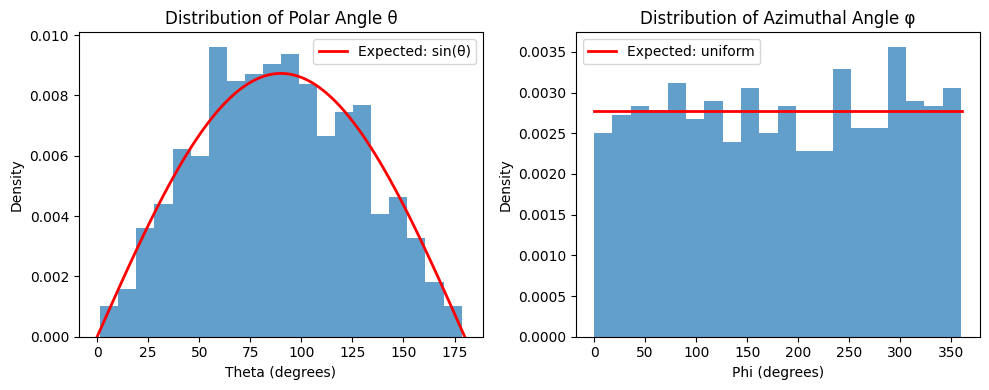

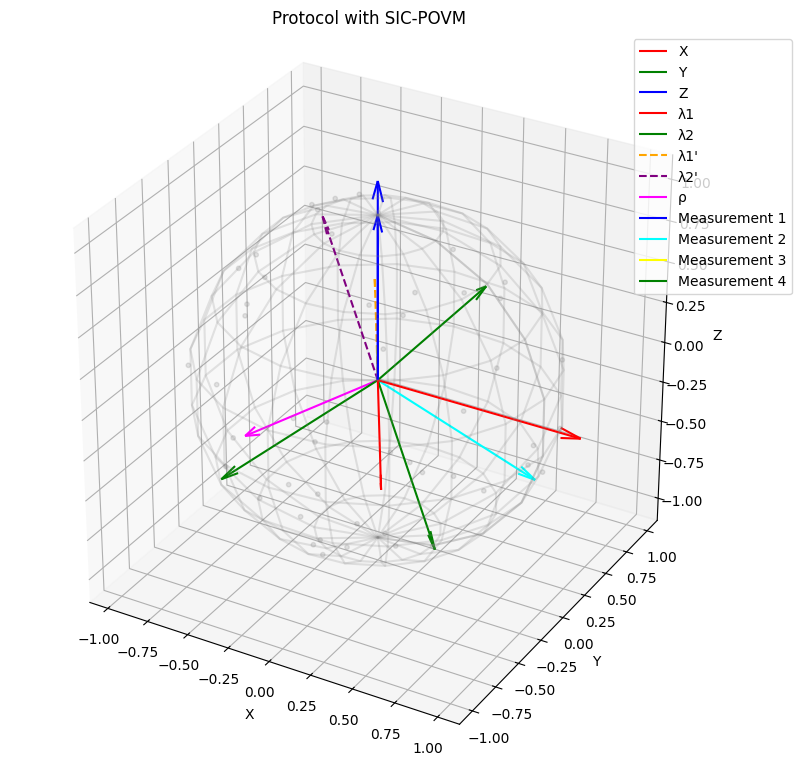

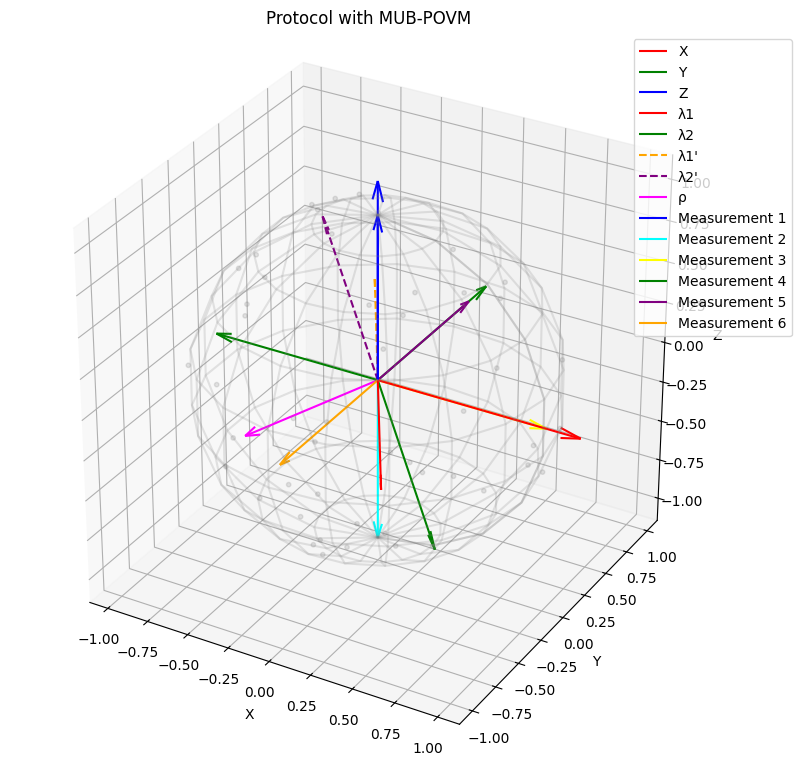

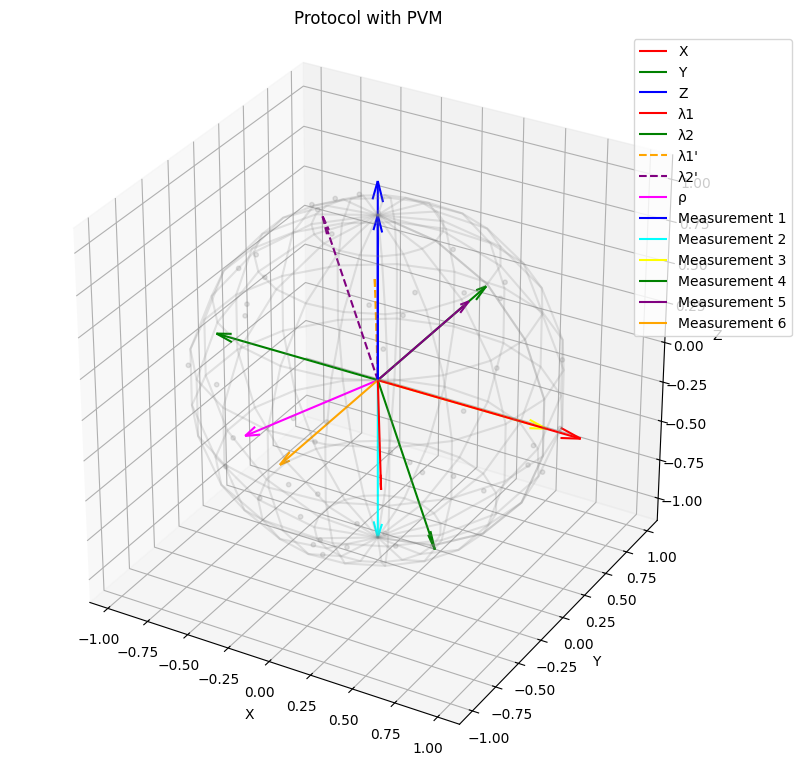

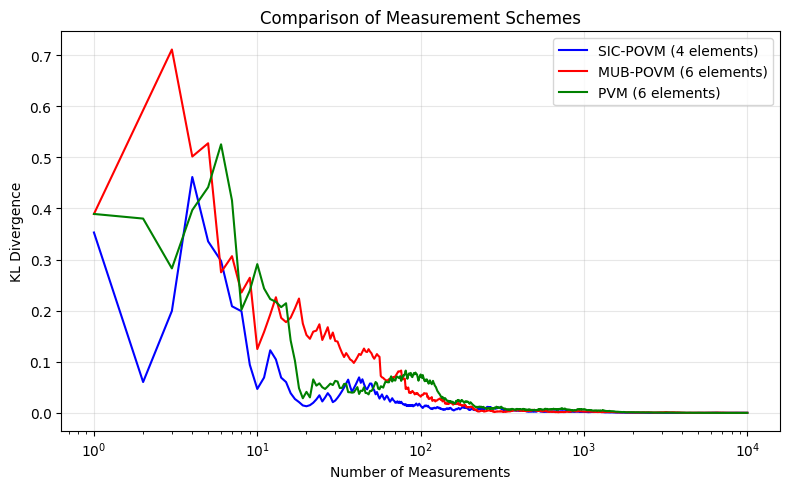

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random
from scipy.spatial import distance

# ==================== UTILITY FUNCTIONS ====================
def heaviside(z):
    """Implementation of the Heaviside function H(z)."""
    return 1 if z >= 0 else 0

def theta(z):
    """Implementation of the function Θ(z) = z·H(z)."""
    return z if z >= 0 else 0

def cartesian_to_spherical(point):
    """Converts a point from Cartesian coordinates (x,y,z) to spherical coordinates (theta, phi)."""
    x, y, z = point
    r = np.sqrt(x**2 + y**2 + z**2)  # Should be 1 for unit sphere
    theta = np.arccos(z / r) * 180 / np.pi
    phi = np.arctan2(y, x) * 180 / np.pi
    if phi < 0:
        phi += 360  # Convert to 0-360 range
    return theta, phi

def bloch_to_ket(point):
    """Converts a point on the Bloch sphere to a quantum state in ket notation."""
    x, y, z = point
    theta = np.arccos(z)
    phi = np.arctan2(y, x)
    alpha = np.cos(theta/2)
    beta_mag = np.sin(theta/2)
    beta_phase = phi

    # Nice formatting for complex numbers (simplified)
    if abs(beta_mag) < 1e-10:
        return "|0>"
    elif abs(alpha) < 1e-10:
        return "|1>"
    else:
        alpha_str = f"{alpha:.4f}"
        if abs(beta_phase) < 1e-10:
            beta_str = f"{beta_mag:.4f}"
        else:
            re = beta_mag * np.cos(beta_phase)
            im = beta_mag * np.sin(beta_phase)
            if abs(im) < 1e-10:
                beta_str = f"{re:.4f}"
            else:
                beta_str = f"{re:.4f}{'+' if im > 0 else '-'}{abs(im):.4f}i"

        return f"{alpha_str}|0> + {beta_str}|1>"

def generate_random_sphere_points(n):
    """Generates n points randomly distributed on the unit sphere."""
    points = np.random.randn(n, 3)
    norms = np.sqrt(np.sum(points**2, axis=1))
    points = points / norms[:, np.newaxis]
    return points

def select_random_points(points, num_select=2):
    """Randomly selects a specified number of points from a given array."""
    indices = np.random.choice(len(points), num_select, replace=False)
    return points[indices]

# ==================== SIMPLE DISTRIBUTION VERIFICATION FUNCTION ====================
def plot_distribution_histogram(points, num_bins=20):
    """
    Create a simple histogram showing uniformity of the random points distribution.
    """
    # Convert points to spherical coordinates
    theta_phi_points = np.array([cartesian_to_spherical(point) for point in points])
    thetas = theta_phi_points[:, 0]  # Polar angle (0 to 180 degrees)
    phis = theta_phi_points[:, 1]    # Azimuthal angle (0 to 360 degrees)

    # Create a figure with 2 subplots
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))

    # 1. Histogram of theta values (should follow sin(theta) distribution for uniform sphere)
    axs[0].hist(thetas, bins=num_bins, alpha=0.7, density=True)

    # Generate the expected sin(theta) distribution
    theta_range = np.linspace(0, 180, 100)
    sin_theta = np.sin(theta_range * np.pi / 180)
    sin_theta = sin_theta / np.trapz(sin_theta, theta_range)  # Normalize
    axs[0].plot(theta_range, sin_theta, 'r-', linewidth=2, label='Expected: sin(θ)')

    axs[0].set_xlabel('Theta (degrees)')
    axs[0].set_ylabel('Density')
    axs[0].set_title('Distribution of Polar Angle θ')
    axs[0].legend()

    # 2. Histogram of phi values (should be uniform for uniform sphere)
    axs[1].hist(phis, bins=num_bins, alpha=0.7, density=True)

    # Generate the expected uniform distribution for phi
    phi_expected = np.ones_like(theta_range) / 360
    phi_range = np.linspace(0, 360, 100)
    axs[1].plot(phi_range, phi_expected, 'r-', linewidth=2, label='Expected: uniform')

    axs[1].set_xlabel('Phi (degrees)')
    axs[1].set_ylabel('Density')
    axs[1].set_title('Distribution of Azimuthal Angle φ')
    axs[1].legend()

    plt.tight_layout()
    return fig

# ==================== SIMPLE BLOCH SPHERE VISUALIZATION ====================
def plot_bloch_sphere(random_points=None, lambda_vectors=None, quantum_state=None,
                     measurement_vectors=None, transformed_lambdas=None, title="Bloch Sphere Visualization"):
    """
    Create a simple 3D visualization of the Bloch sphere with key points.
    """
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot sphere
    u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
    x = np.cos(u) * np.sin(v)
    y = np.sin(u) * np.sin(v)
    z = np.cos(v)
    ax.plot_wireframe(x, y, z, color='gray', alpha=0.2)

    # Plot coordinate axes
    ax.quiver(0, 0, 0, 1, 0, 0, color='r', length=1.2, arrow_length_ratio=0.1, label='X')
    ax.quiver(0, 0, 0, 0, 1, 0, color='g', length=1.2, arrow_length_ratio=0.1, label='Y')
    ax.quiver(0, 0, 0, 0, 0, 1, color='b', length=1.2, arrow_length_ratio=0.1, label='Z')

    # Plot random points (just a few for clarity)
    if random_points is not None and len(random_points) > 0:
        # Only plot a subset for clarity
        subset = random_points[:50]
        ax.scatter(subset[:, 0], subset[:, 1], subset[:, 2], color='gray', alpha=0.2, s=10)

    # Plot lambda vectors
    if lambda_vectors is not None:
        colors = ['red', 'green']
        for i, vec in enumerate(lambda_vectors):
            ax.quiver(0, 0, 0, vec[0], vec[1], vec[2], color=colors[i],
                     length=1.0, arrow_length_ratio=0.1, label=f'λ{i+1}')

    # Plot transformed lambda vectors
    if transformed_lambdas is not None:
        for i, vec in enumerate(transformed_lambdas):
            ax.quiver(0, 0, 0, vec[0], vec[1], vec[2], color='orange' if i == 0 else 'purple',
                     length=1.0, arrow_length_ratio=0.1, label=f'λ{i+1}\'', linestyle='dashed')

    # Plot quantum state
    if quantum_state is not None:
        ax.quiver(0, 0, 0, quantum_state[0], quantum_state[1], quantum_state[2],
                 color='magenta', length=1.0, arrow_length_ratio=0.1, label='ρ')

    # Plot measurement vectors
    if measurement_vectors is not None:
        measurement_colors = ['blue', 'cyan', 'yellow', 'green', 'purple', 'orange']
        for i, vec in enumerate(measurement_vectors):
            if i < len(measurement_colors):
                ax.quiver(0, 0, 0, vec[0], vec[1], vec[2],
                         color=measurement_colors[i], length=1.0, arrow_length_ratio=0.1,
                         label=f'Measurement {i+1}')

    # Format plot
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(title)
    ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1))
    ax.set_box_aspect([1,1,1])  # Equal aspect ratio

    plt.tight_layout()
    return fig

# ==================== MEASUREMENT BASIS FUNCTIONS ====================
def create_sic_povm():
    """Creates the SIC-POVM for qubits (tetrahedron on the Bloch sphere)."""
    bloch1 = np.array([0, 0, 1])  # |0⟩ state
    bloch2 = np.array([np.sqrt(8/9), 0, -1/3])
    bloch3 = np.array([-np.sqrt(2/9), np.sqrt(6/9), -1/3])
    bloch4 = np.array([-np.sqrt(2/9), -np.sqrt(6/9), -1/3])

    return np.array([bloch1, bloch2, bloch3, bloch4])

def create_mub_povm():
    """Creates the MUB-POVM for qubits (6 points along cardinal axes)."""
    bloch1 = np.array([0, 0, 1])     # |0⟩ state
    bloch2 = np.array([0, 0, -1])    # |1⟩ state
    bloch3 = np.array([1, 0, 0])     # |+⟩ state
    bloch4 = np.array([-1, 0, 0])    # |-⟩ state
    bloch5 = np.array([0, 1, 0])     # |+i⟩ state
    bloch6 = np.array([0, -1, 0])    # |-i⟩ state

    return np.array([bloch1, bloch2, bloch3, bloch4, bloch5, bloch6])

def create_pvm():
    """Creates standard PVM bases (same points as MUB-POVM but treated as separate bases)."""
    # Same points as MUB-POVM
    return create_mub_povm()

# ==================== KL DIVERGENCE FUNCTION ====================
def improved_kl_divergence(p, q):
    """
    Calculates the Kullback-Leibler divergence between two probability distributions
    with improved numerical stability.
    """
    # Ensure p and q are numpy arrays
    p = np.array(p)
    q = np.array(q)

    # Normalize to ensure proper probability distributions
    p = p / np.sum(p)
    q = q / np.sum(q)

    # Avoid division by zero and log(0) issues
    epsilon = 1e-10
    q_safe = np.maximum(q, epsilon)

    # Calculate KL divergence
    mask = p > 0  # Only consider where p > 0 (since 0*log(0/q) = 0)
    kl_terms = p[mask] * np.log(p[mask] / q_safe[mask])
    kl_div = np.sum(kl_terms)

    return kl_div

# ==================== THEORETICAL PROBABILITY CALCULATION ====================
def calculate_theoretical_quantum_probs(quantum_state, bloch_vectors):
    """
    Calculate the theoretical quantum probabilities using Born's rule:
    p(b|ρ, B_b) = p_b(1 + r·t_b)
    """
    p_b = 1/len(bloch_vectors)  # Base probability depends on number of elements

    probs = []
    for b_vec in bloch_vectors:
        prob = p_b * (1 + np.dot(quantum_state, b_vec))
        probs.append(prob)

    return np.array(probs)

# ==================== PROTOCOL IMPLEMENTATION ====================
def run_protocol(quantum_state, measurement_vectors, num_measurements=10000):
    """
    Run the classical protocol simulation and track KL divergence.
    """
    # Get theoretical quantum probabilities
    quantum_probs = calculate_theoretical_quantum_probs(quantum_state, measurement_vectors)

    # Track outcomes and KL divergence
    outcomes = []
    kl_values = []

    # Start with small counts for all outcomes
    counts = np.ones(len(measurement_vectors)) * 0.1

    # Run protocol
    for i in range(1, num_measurements + 1):
        # 1. Generate two random vectors
        lambda_vectors = generate_random_sphere_points(2)

        # 2. Alice calculates bits
        c1 = heaviside(np.dot(quantum_state, lambda_vectors[0]))
        c2 = heaviside(np.dot(quantum_state, lambda_vectors[1]))

        # 3. Bob transforms lambda vectors
        lambda_prime1 = lambda_vectors[0] if c1 == 1 else -lambda_vectors[0]
        lambda_prime2 = lambda_vectors[1] if c2 == 1 else -lambda_vectors[1]

        # 4. Bob selects measurement direction
        selected_index = np.random.choice(len(measurement_vectors))
        selected_y = measurement_vectors[selected_index]

        # 5. Bob decides which λ' to use
        if abs(np.dot(lambda_prime1, selected_y)) >= abs(np.dot(lambda_prime2, selected_y)):
            selected_lambda = lambda_prime1
        else:
            selected_lambda = lambda_prime2

        # 6. Calculate θ values
        theta_values = np.array([theta(np.dot(y, selected_lambda)) for y in measurement_vectors])

        # 7. Calculate denominator
        p_values = np.array([1/len(measurement_vectors)] * len(measurement_vectors))
        denominator = np.sum(p_values * theta_values)

        # 8. Determine outcome
        if denominator > 0:
            outcome_probs = p_values * theta_values / denominator
            if np.sum(outcome_probs) > 0:
                outcome_probs = outcome_probs / np.sum(outcome_probs)
                outcome = np.random.choice(len(measurement_vectors), p=outcome_probs)
            else:
                outcome = np.random.choice(len(measurement_vectors))
        else:
            outcome = np.random.choice(len(measurement_vectors))

        # Update counts and calculate KL divergence
        outcomes.append(outcome)
        counts[outcome] += 1
        freqs = counts / (i + len(measurement_vectors) * 0.1)
        kl_div = improved_kl_divergence(freqs, quantum_probs)
        kl_values.append(kl_div)

    return np.array(kl_values), quantum_probs, outcomes

# ==================== PVM PROTOCOL IMPLEMENTATION ====================
def run_pvm_protocol(quantum_state, pvm_vectors, num_measurements=10000):
    """
    Run the Bell scenario protocol with PVM and track KL divergence.
    """
    # Group PVM elements by basis
    bases = [("Z", [0, 1]), ("X", [2, 3]), ("Y", [4, 5])]

    # Calculate theoretical probabilities
    theoretical_probs = np.zeros(len(pvm_vectors))
    for i, vec in enumerate(pvm_vectors):
        theoretical_probs[i] = (1 + np.dot(quantum_state, vec)) / 2

    # Normalize by basis
    for _, indices in bases:
        i, j = indices
        basis_sum = theoretical_probs[i] + theoretical_probs[j]
        theoretical_probs[i] /= basis_sum
        theoretical_probs[j] /= basis_sum

    # Equal probability of selecting each basis
    theoretical_probs /= 3

    # Track outcomes and KL divergence
    outcomes = []
    basis_choices = []
    kl_values = []

    # Start with small counts
    counts = np.ones(len(pvm_vectors)) * 0.1

    # Run protocol
    for i in range(1, num_measurements + 1):
        # Generate lambda vectors
        lambda_vectors = generate_random_sphere_points(2)

        # Alice calculates bits
        c1 = heaviside(np.dot(quantum_state, lambda_vectors[0]))
        c2 = heaviside(np.dot(quantum_state, lambda_vectors[1]))

        # Bob transforms lambda vectors
        lambda_prime1 = lambda_vectors[0] if c1 == 1 else -lambda_vectors[0]
        lambda_prime2 = lambda_vectors[1] if c2 == 1 else -lambda_vectors[1]

        # Choose random basis
        basis_idx = np.random.choice(len(bases))
        basis_indices = bases[basis_idx][1]
        basis_choices.append(basis_idx)

        # Calculate alignment with basis vectors
        alignment1 = np.mean([abs(np.dot(lambda_prime1, pvm_vectors[idx])) for idx in basis_indices])
        alignment2 = np.mean([abs(np.dot(lambda_prime2, pvm_vectors[idx])) for idx in basis_indices])

        # Choose lambda with better alignment
        selected_lambda = lambda_prime1 if alignment1 >= alignment2 else lambda_prime2

        # Perform measurement in selected basis
        idx1, idx2 = basis_indices
        prob1 = (1 + np.dot(quantum_state, pvm_vectors[idx1])) / 2

        # Determine outcome
        if np.random.random() < prob1:
            outcome = idx1
        else:
            outcome = idx2

        # Update counts and calculate KL divergence
        outcomes.append(outcome)
        counts[outcome] += 1
        freqs = counts / (i + len(pvm_vectors) * 0.1)
        kl_div = improved_kl_divergence(freqs, theoretical_probs)
        kl_values.append(kl_div)

    return np.array(kl_values), theoretical_probs, outcomes, basis_choices

# ==================== KL DIVERGENCE PLOTTING ====================
def plot_kl_divergence(kl_values, title="KL Divergence vs Number of Measurements"):
    """Plot KL divergence with a smaller, cleaner figure."""
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.plot(range(1, len(kl_values) + 1), kl_values)
    ax.set_xscale('log')
    ax.set_xlabel('Number of Measurements')
    ax.set_ylabel('KL Divergence')
    ax.set_title(title)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    return fig

# ==================== COMPARATIVE ANALYSIS ====================
def compare_measurement_schemes(quantum_state, n_measurements=10000):
    """
    Compare different measurement schemes (SIC-POVM, MUB-POVM, PVM) on the same quantum state.
    """
    # Create measurement vectors
    sic_vectors = create_sic_povm()
    mub_vectors = create_mub_povm()
    pvm_vectors = create_pvm()

    # Run simulations
    print("Running SIC-POVM simulation...")
    sic_kl_values, sic_probs, _ = run_protocol(quantum_state, sic_vectors, n_measurements)

    print("Running MUB-POVM simulation...")
    mub_kl_values, mub_probs, _ = run_protocol(quantum_state, mub_vectors, n_measurements)

    print("Running PVM simulation...")
    pvm_kl_values, pvm_probs, _, basis_choices = run_pvm_protocol(quantum_state, pvm_vectors, n_measurements)

    # Create comparison plot
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.plot(range(1, len(sic_kl_values) + 1), sic_kl_values, label='SIC-POVM (4 elements)', color='blue')
    ax.plot(range(1, len(mub_kl_values) + 1), mub_kl_values, label='MUB-POVM (6 elements)', color='red')
    ax.plot(range(1, len(pvm_kl_values) + 1), pvm_kl_values, label='PVM (6 elements)', color='green')

    ax.set_xscale('log')
    ax.set_xlabel('Number of Measurements')
    ax.set_ylabel('KL Divergence')
    ax.set_title('Comparison of Measurement Schemes')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()

    # Return data and figure
    return {
        'sic_kl_values': sic_kl_values,
        'mub_kl_values': mub_kl_values,
        'pvm_kl_values': pvm_kl_values,
        'comparison_fig': fig
    }

# ==================== MAIN FUNCTION ====================
def main():
    # Set random seed
    np.random.seed(42)
    random.seed(42)

    # Generate random points and select quantum state
    n_points = 1000
    random_points = generate_random_sphere_points(n_points)
    quantum_state = select_random_points(random_points, num_select=1)[0]
    lambda_vectors = select_random_points(random_points, num_select=2)

    print(f"Selected quantum state: {quantum_state}")
    print(f"Quantum state in ket notation: {bloch_to_ket(quantum_state)}")

    # Calculate transformed lambda vectors
    c1 = heaviside(np.dot(quantum_state, lambda_vectors[0]))
    c2 = heaviside(np.dot(quantum_state, lambda_vectors[1]))
    transformed_lambdas = [
        lambda_vectors[0] if c1 == 1 else -lambda_vectors[0],
        lambda_vectors[1] if c2 == 1 else -lambda_vectors[1]
    ]

    # 1. Create uniformity distribution histogram
    dist_fig = plot_distribution_histogram(random_points)
    plt.figure(dist_fig.number)
    plt.savefig('distribution_histogram.png', dpi=300, bbox_inches='tight')

    # 2. Create protocol visualization
    sic_vectors = create_sic_povm()
    mub_vectors = create_mub_povm()
    pvm_vectors = create_pvm()

    # Protocol visualization with SIC-POVM
    sic_fig = plot_bloch_sphere(
        random_points[:50],
        lambda_vectors,
        quantum_state,
        sic_vectors,
        transformed_lambdas,
        title="Protocol with SIC-POVM"
    )
    plt.figure(sic_fig.number)
    plt.savefig('sic_povm_visualization.png', dpi=300, bbox_inches='tight')

    # Protocol visualization with MUB-POVM
    mub_fig = plot_bloch_sphere(
        random_points[:50],
        lambda_vectors,
        quantum_state,
        mub_vectors,
        transformed_lambdas,
        title="Protocol with MUB-POVM"
    )
    plt.figure(mub_fig.number)
    plt.savefig('mub_povm_visualization.png', dpi=300, bbox_inches='tight')

    # Protocol visualization with PVM
    pvm_fig = plot_bloch_sphere(
        random_points[:50],
        lambda_vectors,
        quantum_state,
        pvm_vectors,
        transformed_lambdas,
        title="Protocol with PVM"
    )
    plt.figure(pvm_fig.number)
    plt.savefig('pvm_visualization.png', dpi=300, bbox_inches='tight')

    # 3. Run comparative analysis
    n_measurements = 10000
    comparison_results = compare_measurement_schemes(quantum_state, n_measurements)

    # Save comparison figure
    plt.figure(comparison_results['comparison_fig'].number)
    plt.savefig('kl_divergence_comparison.png', dpi=300, bbox_inches='tight')

    # Show all figures
    plt.show()

if __name__ == "__main__":
    main()

Podaj liczbę przebiegów protokołu (domyślnie 10000): 100000
Uruchamianie symulacji z 100000 przebiegami...
Wybrany stan kwantowy: [-0.81290047 -0.02917636 -0.58167135]
Stan kwantowy w notacji ket: 0.4573|0> + -0.8887-0.0319i|1>


<ipython-input-17-ecd1d8915fd5>:85: DeprecationWarning:

`trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.



Running SIC-POVM simulation...
Running MUB-POVM simulation...
Running PVM simulation...
Symulacja zakończona. Wykresy zostały zapisane.


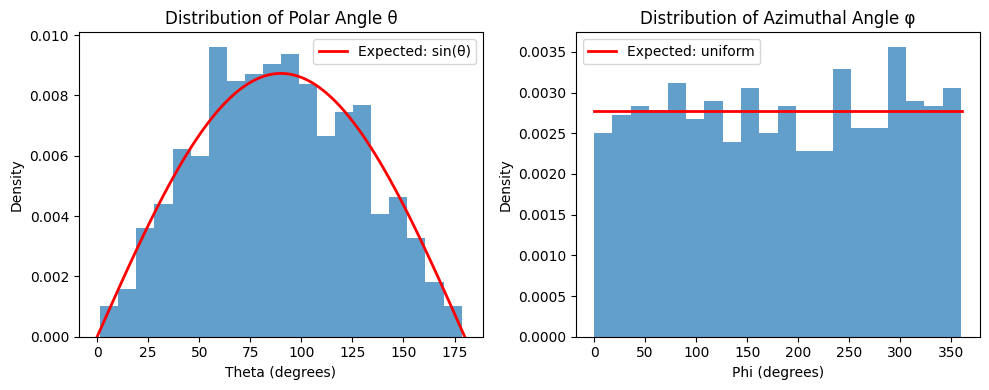

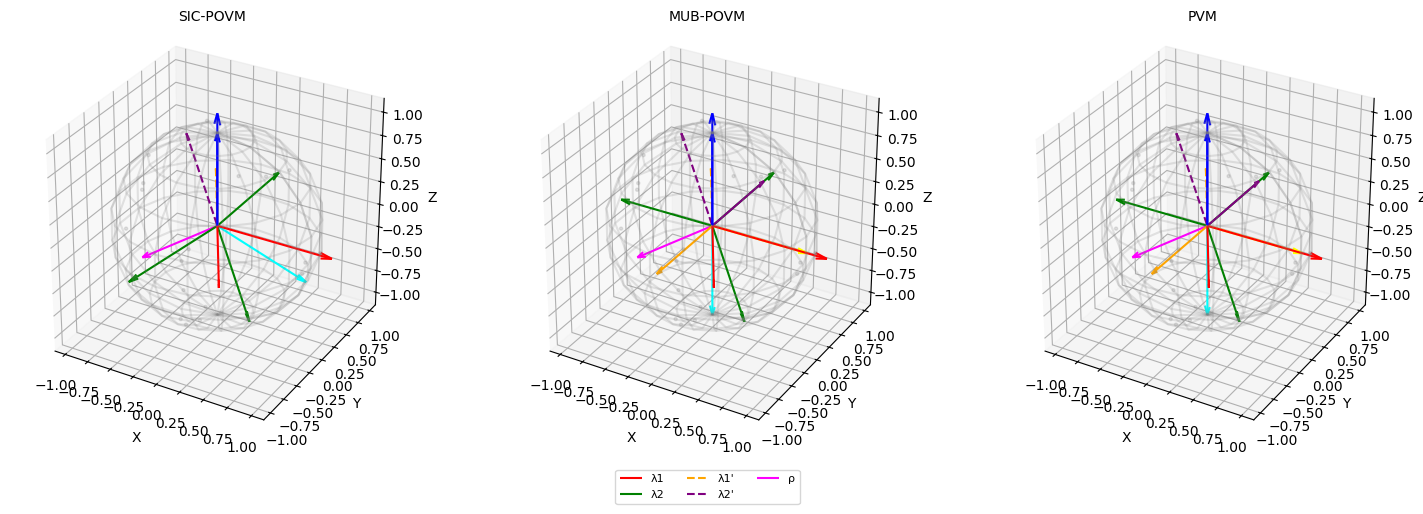

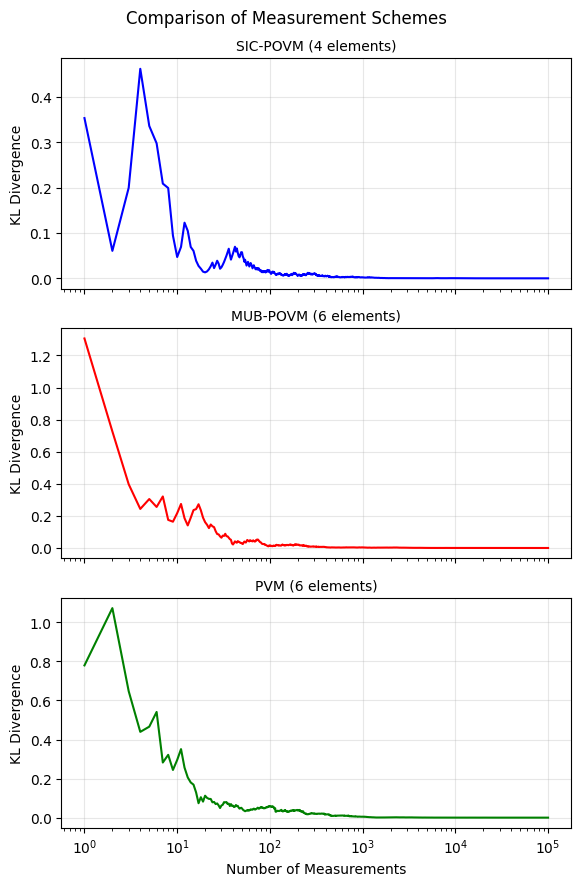

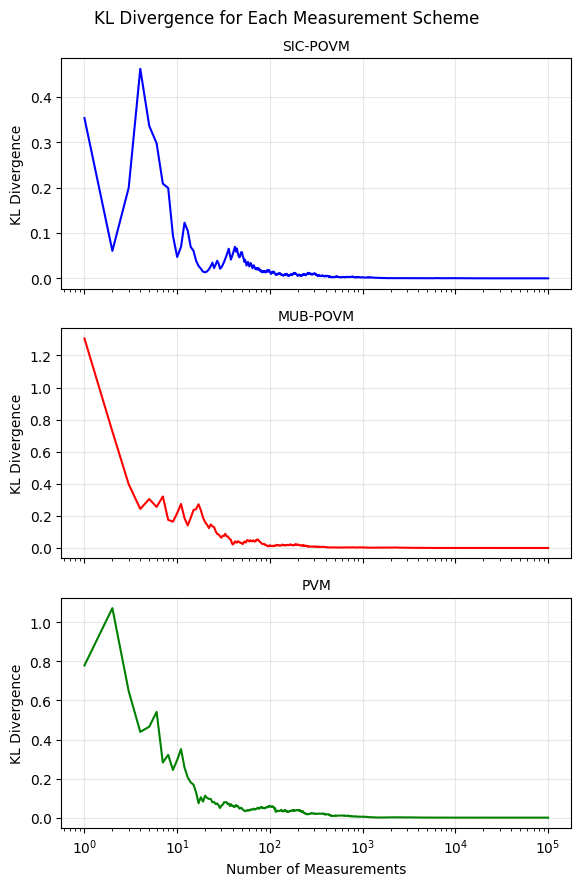

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random
from scipy.spatial import distance

# ==================== UTILITY FUNCTIONS ====================
def heaviside(z):
    """Implementation of the Heaviside function H(z)."""
    return 1 if z >= 0 else 0

def theta(z):
    """Implementation of the function Θ(z) = z·H(z)."""
    return z if z >= 0 else 0

def cartesian_to_spherical(point):
    """Converts a point from Cartesian coordinates (x,y,z) to spherical coordinates (theta, phi)."""
    x, y, z = point
    r = np.sqrt(x**2 + y**2 + z**2)  # Should be 1 for unit sphere
    theta = np.arccos(z / r) * 180 / np.pi
    phi = np.arctan2(y, x) * 180 / np.pi
    if phi < 0:
        phi += 360  # Convert to 0-360 range
    return theta, phi

def bloch_to_ket(point):
    """Converts a point on the Bloch sphere to a quantum state in ket notation."""
    x, y, z = point
    theta = np.arccos(z)
    phi = np.arctan2(y, x)
    alpha = np.cos(theta/2)
    beta_mag = np.sin(theta/2)
    beta_phase = phi

    # Nice formatting for complex numbers (simplified)
    if abs(beta_mag) < 1e-10:
        return "|0>"
    elif abs(alpha) < 1e-10:
        return "|1>"
    else:
        alpha_str = f"{alpha:.4f}"
        if abs(beta_phase) < 1e-10:
            beta_str = f"{beta_mag:.4f}"
        else:
            re = beta_mag * np.cos(beta_phase)
            im = beta_mag * np.sin(beta_phase)
            if abs(im) < 1e-10:
                beta_str = f"{re:.4f}"
            else:
                beta_str = f"{re:.4f}{'+' if im > 0 else '-'}{abs(im):.4f}i"

        return f"{alpha_str}|0> + {beta_str}|1>"

def generate_random_sphere_points(n):
    """Generates n points randomly distributed on the unit sphere."""
    points = np.random.randn(n, 3)
    norms = np.sqrt(np.sum(points**2, axis=1))
    points = points / norms[:, np.newaxis]
    return points

def select_random_points(points, num_select=2):
    """Randomly selects a specified number of points from a given array."""
    indices = np.random.choice(len(points), num_select, replace=False)
    return points[indices]

# ==================== SIMPLE DISTRIBUTION VERIFICATION FUNCTION ====================
def plot_distribution_histogram(points, num_bins=20):
    """
    Create a simple histogram showing uniformity of the random points distribution.
    """
    # Convert points to spherical coordinates
    theta_phi_points = np.array([cartesian_to_spherical(point) for point in points])
    thetas = theta_phi_points[:, 0]  # Polar angle (0 to 180 degrees)
    phis = theta_phi_points[:, 1]    # Azimuthal angle (0 to 360 degrees)

    # Create a figure with 2 subplots
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))

    # 1. Histogram of theta values (should follow sin(theta) distribution for uniform sphere)
    axs[0].hist(thetas, bins=num_bins, alpha=0.7, density=True)

    # Generate the expected sin(theta) distribution
    theta_range = np.linspace(0, 180, 100)
    sin_theta = np.sin(theta_range * np.pi / 180)
    sin_theta = sin_theta / np.trapz(sin_theta, theta_range)  # Normalize
    axs[0].plot(theta_range, sin_theta, 'r-', linewidth=2, label='Expected: sin(θ)')

    axs[0].set_xlabel('Theta (degrees)')
    axs[0].set_ylabel('Density')
    axs[0].set_title('Distribution of Polar Angle θ')
    axs[0].legend()

    # 2. Histogram of phi values (should be uniform for uniform sphere)
    axs[1].hist(phis, bins=num_bins, alpha=0.7, density=True)

    # Generate the expected uniform distribution for phi
    phi_expected = np.ones_like(theta_range) / 360
    phi_range = np.linspace(0, 360, 100)
    axs[1].plot(phi_range, phi_expected, 'r-', linewidth=2, label='Expected: uniform')

    axs[1].set_xlabel('Phi (degrees)')
    axs[1].set_ylabel('Density')
    axs[1].set_title('Distribution of Azimuthal Angle φ')
    axs[1].legend()

    plt.tight_layout()
    return fig

# ==================== SIMPLE BLOCH SPHERE VISUALIZATION ====================
def plot_bloch_sphere(random_points=None, lambda_vectors=None, quantum_state=None,
                     measurement_vectors=None, transformed_lambdas=None, title="Bloch Sphere Visualization",
                     ax=None):
    """
    Create a simple 3D visualization of the Bloch sphere with key points.
    Now accepts an existing axis for subplot placement.
    """
    if ax is None:
        fig = plt.figure(figsize=(6, 6))
        ax = fig.add_subplot(111, projection='3d')

    # Plot sphere
    u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
    x = np.cos(u) * np.sin(v)
    y = np.sin(u) * np.sin(v)
    z = np.cos(v)
    ax.plot_wireframe(x, y, z, color='gray', alpha=0.2)

    # Plot coordinate axes
    ax.quiver(0, 0, 0, 1, 0, 0, color='r', length=1.2, arrow_length_ratio=0.1)
    ax.quiver(0, 0, 0, 0, 1, 0, color='g', length=1.2, arrow_length_ratio=0.1)
    ax.quiver(0, 0, 0, 0, 0, 1, color='b', length=1.2, arrow_length_ratio=0.1)

    # Plot random points (just a few for clarity)
    if random_points is not None and len(random_points) > 0:
        # Only plot a subset for clarity
        subset = random_points[:20]  # Reduced from 50 to 20 for better clarity
        ax.scatter(subset[:, 0], subset[:, 1], subset[:, 2], color='gray', alpha=0.2, s=5)

    # Plot lambda vectors
    if lambda_vectors is not None:
        colors = ['red', 'green']
        for i, vec in enumerate(lambda_vectors):
            ax.quiver(0, 0, 0, vec[0], vec[1], vec[2], color=colors[i],
                     length=1.0, arrow_length_ratio=0.1, label=f'λ{i+1}')

    # Plot transformed lambda vectors
    if transformed_lambdas is not None:
        for i, vec in enumerate(transformed_lambdas):
            ax.quiver(0, 0, 0, vec[0], vec[1], vec[2], color='orange' if i == 0 else 'purple',
                     length=1.0, arrow_length_ratio=0.1, label=f'λ{i+1}\'', linestyle='dashed')

    # Plot quantum state
    if quantum_state is not None:
        ax.quiver(0, 0, 0, quantum_state[0], quantum_state[1], quantum_state[2],
                 color='magenta', length=1.0, arrow_length_ratio=0.1, label='ρ')

    # Plot measurement vectors
    if measurement_vectors is not None:
        measurement_colors = ['blue', 'cyan', 'yellow', 'green', 'purple', 'orange']
        for i, vec in enumerate(measurement_vectors):
            if i < len(measurement_colors):
                ax.quiver(0, 0, 0, vec[0], vec[1], vec[2],
                         color=measurement_colors[i], length=1.0, arrow_length_ratio=0.1)

    # Format plot
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(title, fontsize=10)

    # Let's handle legend in the main figure instead of individual subplots
    ax.set_box_aspect([1,1,1])  # Equal aspect ratio

    return ax

# ==================== MEASUREMENT BASIS FUNCTIONS ====================
def create_sic_povm():
    """Creates the SIC-POVM for qubits (tetrahedron on the Bloch sphere)."""
    bloch1 = np.array([0, 0, 1])  # |0⟩ state
    bloch2 = np.array([np.sqrt(8/9), 0, -1/3])
    bloch3 = np.array([-np.sqrt(2/9), np.sqrt(6/9), -1/3])
    bloch4 = np.array([-np.sqrt(2/9), -np.sqrt(6/9), -1/3])

    return np.array([bloch1, bloch2, bloch3, bloch4])

def create_mub_povm():
    """Creates the MUB-POVM for qubits (6 points along cardinal axes)."""
    bloch1 = np.array([0, 0, 1])     # |0⟩ state
    bloch2 = np.array([0, 0, -1])    # |1⟩ state
    bloch3 = np.array([1, 0, 0])     # |+⟩ state
    bloch4 = np.array([-1, 0, 0])    # |-⟩ state
    bloch5 = np.array([0, 1, 0])     # |+i⟩ state
    bloch6 = np.array([0, -1, 0])    # |-i⟩ state

    return np.array([bloch1, bloch2, bloch3, bloch4, bloch5, bloch6])

def create_pvm():
    """Creates standard PVM bases (same points as MUB-POVM but treated as separate bases)."""
    # Same points as MUB-POVM
    return create_mub_povm()

# ==================== KL DIVERGENCE FUNCTION ====================
def improved_kl_divergence(p, q):
    """
    Calculates the Kullback-Leibler divergence between two probability distributions
    with improved numerical stability.
    """
    # Ensure p and q are numpy arrays
    p = np.array(p)
    q = np.array(q)

    # Normalize to ensure proper probability distributions
    p = p / np.sum(p)
    q = q / np.sum(q)

    # Avoid division by zero and log(0) issues
    epsilon = 1e-10
    q_safe = np.maximum(q, epsilon)

    # Calculate KL divergence
    mask = p > 0  # Only consider where p > 0 (since 0*log(0/q) = 0)
    kl_terms = p[mask] * np.log(p[mask] / q_safe[mask])
    kl_div = np.sum(kl_terms)

    return kl_div

# ==================== THEORETICAL PROBABILITY CALCULATION ====================
def calculate_theoretical_quantum_probs(quantum_state, bloch_vectors):
    """
    Calculate the theoretical quantum probabilities using Born's rule:
    p(b|ρ, B_b) = p_b(1 + r·t_b)
    """
    p_b = 1/len(bloch_vectors)  # Base probability depends on number of elements

    probs = []
    for b_vec in bloch_vectors:
        prob = p_b * (1 + np.dot(quantum_state, b_vec))
        probs.append(prob)

    return np.array(probs)

# ==================== PROTOCOL IMPLEMENTATION ====================
def run_protocol(quantum_state, measurement_vectors, num_measurements=10000):
    """
    Run the classical protocol simulation and track KL divergence.
    """
    # Get theoretical quantum probabilities
    quantum_probs = calculate_theoretical_quantum_probs(quantum_state, measurement_vectors)

    # Track outcomes and KL divergence
    outcomes = []
    kl_values = []

    # Start with small counts for all outcomes
    counts = np.ones(len(measurement_vectors)) * 0.1

    # Run protocol
    for i in range(1, num_measurements + 1):
        # 1. Generate two random vectors
        lambda_vectors = generate_random_sphere_points(2)

        # 2. Alice calculates bits
        c1 = heaviside(np.dot(quantum_state, lambda_vectors[0]))
        c2 = heaviside(np.dot(quantum_state, lambda_vectors[1]))

        # 3. Bob transforms lambda vectors
        lambda_prime1 = lambda_vectors[0] if c1 == 1 else -lambda_vectors[0]
        lambda_prime2 = lambda_vectors[1] if c2 == 1 else -lambda_vectors[1]

        # 4. Bob selects measurement direction
        selected_index = np.random.choice(len(measurement_vectors))
        selected_y = measurement_vectors[selected_index]

        # 5. Bob decides which λ' to use
        if abs(np.dot(lambda_prime1, selected_y)) >= abs(np.dot(lambda_prime2, selected_y)):
            selected_lambda = lambda_prime1
        else:
            selected_lambda = lambda_prime2

        # 6. Calculate θ values
        theta_values = np.array([theta(np.dot(y, selected_lambda)) for y in measurement_vectors])

        # 7. Calculate denominator
        p_values = np.array([1/len(measurement_vectors)] * len(measurement_vectors))
        denominator = np.sum(p_values * theta_values)

        # 8. Determine outcome
        if denominator > 0:
            outcome_probs = p_values * theta_values / denominator
            if np.sum(outcome_probs) > 0:
                outcome_probs = outcome_probs / np.sum(outcome_probs)
                outcome = np.random.choice(len(measurement_vectors), p=outcome_probs)
            else:
                outcome = np.random.choice(len(measurement_vectors))
        else:
            outcome = np.random.choice(len(measurement_vectors))

        # Update counts and calculate KL divergence
        outcomes.append(outcome)
        counts[outcome] += 1
        freqs = counts / (i + len(measurement_vectors) * 0.1)
        kl_div = improved_kl_divergence(freqs, quantum_probs)
        kl_values.append(kl_div)

    return np.array(kl_values), quantum_probs, outcomes

# ==================== PVM PROTOCOL IMPLEMENTATION ====================
def run_pvm_protocol(quantum_state, pvm_vectors, num_measurements=10000):
    """
    Run the Bell scenario protocol with PVM and track KL divergence.
    """
    # Group PVM elements by basis
    bases = [("Z", [0, 1]), ("X", [2, 3]), ("Y", [4, 5])]

    # Calculate theoretical probabilities
    theoretical_probs = np.zeros(len(pvm_vectors))
    for i, vec in enumerate(pvm_vectors):
        theoretical_probs[i] = (1 + np.dot(quantum_state, vec)) / 2

    # Normalize by basis
    for _, indices in bases:
        i, j = indices
        basis_sum = theoretical_probs[i] + theoretical_probs[j]
        theoretical_probs[i] /= basis_sum
        theoretical_probs[j] /= basis_sum

    # Equal probability of selecting each basis
    theoretical_probs /= 3

    # Track outcomes and KL divergence
    outcomes = []
    basis_choices = []
    kl_values = []

    # Start with small counts
    counts = np.ones(len(pvm_vectors)) * 0.1

    # Run protocol
    for i in range(1, num_measurements + 1):
        # Generate lambda vectors
        lambda_vectors = generate_random_sphere_points(2)

        # Alice calculates bits
        c1 = heaviside(np.dot(quantum_state, lambda_vectors[0]))
        c2 = heaviside(np.dot(quantum_state, lambda_vectors[1]))

        # Bob transforms lambda vectors
        lambda_prime1 = lambda_vectors[0] if c1 == 1 else -lambda_vectors[0]
        lambda_prime2 = lambda_vectors[1] if c2 == 1 else -lambda_vectors[1]

        # Choose random basis
        basis_idx = np.random.choice(len(bases))
        basis_indices = bases[basis_idx][1]
        basis_choices.append(basis_idx)

        # Calculate alignment with basis vectors
        alignment1 = np.mean([abs(np.dot(lambda_prime1, pvm_vectors[idx])) for idx in basis_indices])
        alignment2 = np.mean([abs(np.dot(lambda_prime2, pvm_vectors[idx])) for idx in basis_indices])

        # Choose lambda with better alignment
        selected_lambda = lambda_prime1 if alignment1 >= alignment2 else lambda_prime2

        # Perform measurement in selected basis
        idx1, idx2 = basis_indices
        prob1 = (1 + np.dot(quantum_state, pvm_vectors[idx1])) / 2

        # Determine outcome
        if np.random.random() < prob1:
            outcome = idx1
        else:
            outcome = idx2

        # Update counts and calculate KL divergence
        outcomes.append(outcome)
        counts[outcome] += 1
        freqs = counts / (i + len(pvm_vectors) * 0.1)
        kl_div = improved_kl_divergence(freqs, theoretical_probs)
        kl_values.append(kl_div)

    return np.array(kl_values), theoretical_probs, outcomes, basis_choices

# ==================== KL DIVERGENCE PLOTTING ====================
def plot_kl_divergence_comparison(kl_values_dict, title="KL Divergence Comparison"):
    """
    Plot multiple KL divergence curves on separate subplots for better readability.

    Args:
        kl_values_dict: Dictionary with format {'name': kl_values_array}
        title: Title for the overall figure

    Returns:
        matplotlib figure
    """
    n_plots = len(kl_values_dict)
    fig, axs = plt.subplots(n_plots, 1, figsize=(6, 3*n_plots), sharex=True)

    # If only one plot, axs might not be an array
    if n_plots == 1:
        axs = [axs]

    colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown']

    for i, (name, values) in enumerate(kl_values_dict.items()):
        axs[i].plot(range(1, len(values) + 1), values, color=colors[i % len(colors)])
        axs[i].set_xscale('log')
        axs[i].set_ylabel('KL Divergence')
        axs[i].set_title(f'{name}', fontsize=10)
        axs[i].grid(True, alpha=0.3)

    # Add x-axis label only to the bottom subplot
    axs[-1].set_xlabel('Number of Measurements')

    # Add overall title
    fig.suptitle(title, fontsize=12)
    plt.tight_layout()

    return fig

# ==================== COMBINED BLOCH SPHERE VISUALIZATION ====================
def plot_combined_bloch_spheres(random_points, lambda_vectors, quantum_state, transformed_lambdas):
    """
    Create a combined figure with all three Bloch sphere visualizations side by side.
    """
    # Create a figure with three 3D subplots side by side
    fig = plt.figure(figsize=(15, 5))

    # Create measurement vectors
    sic_vectors = create_sic_povm()
    mub_vectors = create_mub_povm()
    pvm_vectors = create_pvm()

    # SIC-POVM visualization
    ax1 = fig.add_subplot(131, projection='3d')
    plot_bloch_sphere(
        random_points[:20],
        lambda_vectors,
        quantum_state,
        sic_vectors,
        transformed_lambdas,
        title="SIC-POVM",
        ax=ax1
    )

    # MUB-POVM visualization
    ax2 = fig.add_subplot(132, projection='3d')
    plot_bloch_sphere(
        random_points[:20],
        lambda_vectors,
        quantum_state,
        mub_vectors,
        transformed_lambdas,
        title="MUB-POVM",
        ax=ax2
    )

    # PVM visualization
    ax3 = fig.add_subplot(133, projection='3d')
    plot_bloch_sphere(
        random_points[:20],
        lambda_vectors,
        quantum_state,
        pvm_vectors,
        transformed_lambdas,
        title="PVM",
        ax=ax3
    )

    # Add a common legend for the entire figure
    handles, labels = [], []
    for ax in [ax1, ax2, ax3]:
        h, l = ax.get_legend_handles_labels()
        for handle, label in zip(h, l):
            if label not in labels:
                handles.append(handle)
                labels.append(label)

    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.05),
              ncol=3, fontsize=8)

    plt.tight_layout(rect=[0, 0.08, 1, 0.95])  # Make room for the legend

    return fig

# ==================== COMPARATIVE ANALYSIS ====================
def compare_measurement_schemes(quantum_state, n_measurements=10000):
    """
    Compare different measurement schemes (SIC-POVM, MUB-POVM, PVM) on the same quantum state.
    """
    # Create measurement vectors
    sic_vectors = create_sic_povm()
    mub_vectors = create_mub_povm()
    pvm_vectors = create_pvm()

    # Run simulations
    print("Running SIC-POVM simulation...")
    sic_kl_values, sic_probs, _ = run_protocol(quantum_state, sic_vectors, n_measurements)

    print("Running MUB-POVM simulation...")
    mub_kl_values, mub_probs, _ = run_protocol(quantum_state, mub_vectors, n_measurements)

    print("Running PVM simulation...")
    pvm_kl_values, pvm_probs, _, basis_choices = run_pvm_protocol(quantum_state, pvm_vectors, n_measurements)

    # Create dictionary for KL values
    kl_values_dict = {
        'SIC-POVM (4 elements)': sic_kl_values,
        'MUB-POVM (6 elements)': mub_kl_values,
        'PVM (6 elements)': pvm_kl_values
    }

    # Create the improved plot
    comparison_fig = plot_kl_divergence_comparison(kl_values_dict, "Comparison of Measurement Schemes")

    # Return data and figure
    return {
        'sic_kl_values': sic_kl_values,
        'mub_kl_values': mub_kl_values,
        'pvm_kl_values': pvm_kl_values,
        'comparison_fig': comparison_fig
    }

# ==================== MAIN FUNCTION ====================
def main():
    # Ask user for number of measurements
    while True:
        try:
            n_measurements_input = input("Podaj liczbę przebiegów protokołu (domyślnie 10000): ")
            if n_measurements_input.strip() == "":
                n_measurements = 10000  # Default value
                break
            n_measurements = int(n_measurements_input)
            if n_measurements <= 0:
                print("Liczba przebiegów musi być dodatnia.")
                continue
            break
        except ValueError:
            print("Proszę podać poprawną liczbę całkowitą.")

    print(f"Uruchamianie symulacji z {n_measurements} przebiegami...")

    # Set random seed
    np.random.seed(42)
    random.seed(42)

    # Generate random points and select quantum state
    n_points = 1000
    random_points = generate_random_sphere_points(n_points)
    quantum_state = select_random_points(random_points, num_select=1)[0]
    lambda_vectors = select_random_points(random_points, num_select=2)

    print(f"Wybrany stan kwantowy: {quantum_state}")
    print(f"Stan kwantowy w notacji ket: {bloch_to_ket(quantum_state)}")

    # Calculate transformed lambda vectors
    c1 = heaviside(np.dot(quantum_state, lambda_vectors[0]))
    c2 = heaviside(np.dot(quantum_state, lambda_vectors[1]))
    transformed_lambdas = [
        lambda_vectors[0] if c1 == 1 else -lambda_vectors[0],
        lambda_vectors[1] if c2 == 1 else -lambda_vectors[1]
    ]

    # 1. Create uniformity distribution histogram
    dist_fig = plot_distribution_histogram(random_points)
    plt.figure(dist_fig.number)
    plt.savefig('distribution_histogram.png', dpi=300, bbox_inches='tight')

    # 2. Create combined Bloch sphere visualization
    bloch_fig = plot_combined_bloch_spheres(
        random_points,
        lambda_vectors,
        quantum_state,
        transformed_lambdas
    )
    plt.figure(bloch_fig.number)
    plt.savefig('combined_bloch_visualization.png', dpi=300, bbox_inches='tight')

    # 3. Run comparative analysis
    comparison_results = compare_measurement_schemes(quantum_state, n_measurements)

    # Save comparison figure
    plt.figure(comparison_results['comparison_fig'].number)
    plt.savefig('kl_divergence_comparison.png', dpi=300, bbox_inches='tight')

    # 4. Also create individual KL plots
    kl_dict = {
        'SIC-POVM': comparison_results['sic_kl_values'],
        'MUB-POVM': comparison_results['mub_kl_values'],
        'PVM': comparison_results['pvm_kl_values']
    }

    individual_kl_fig = plot_kl_divergence_comparison(kl_dict, "KL Divergence for Each Measurement Scheme")
    plt.figure(individual_kl_fig.number)
    plt.savefig('individual_kl_plots.png', dpi=300, bbox_inches='tight')

    print("Symulacja zakończona. Wykresy zostały zapisane.")

    # Show all figures
    plt.show()

if __name__ == "__main__":
    main()

Podaj liczbę przebiegów protokołu (domyślnie 10000): 10000
Uruchamianie symulacji z 10000 przebiegami...
Wybrany stan kwantowy: [-0.81290047 -0.02917636 -0.58167135]
Stan kwantowy w notacji ket: 0.4573|0> + -0.8887-0.0319i|1>


<ipython-input-18-43676091d89f>:85: DeprecationWarning:

`trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.



Running SIC-POVM simulation...
Running MUB-POVM simulation...
Running PVM simulation...
Symulacja zakończona. Wykresy zostały zapisane.


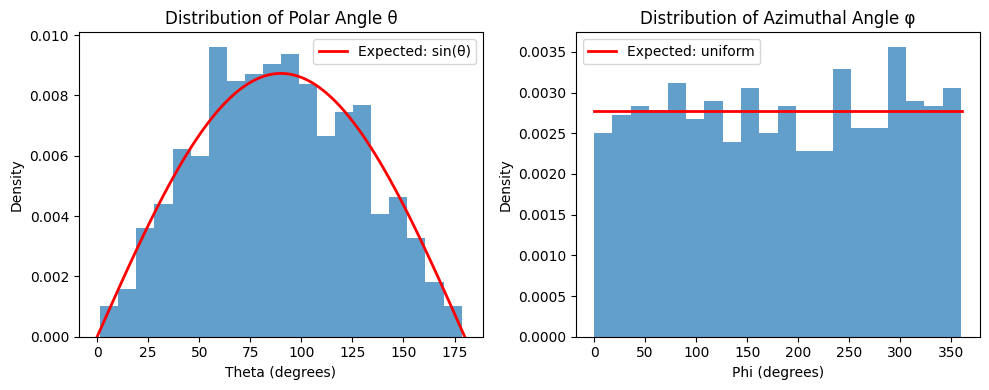

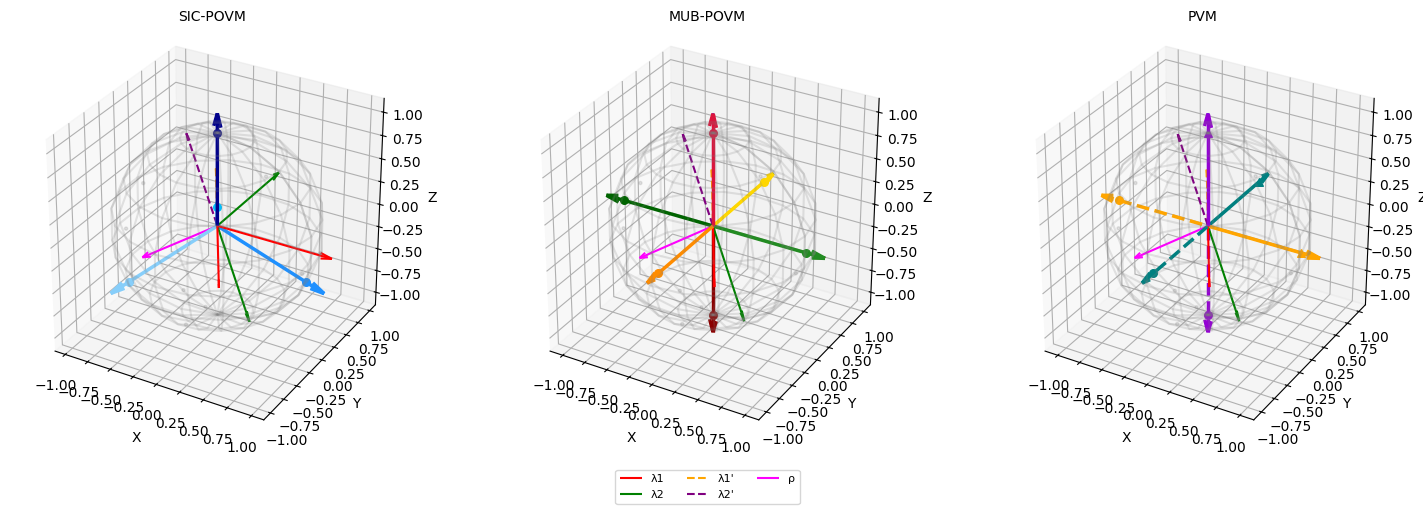

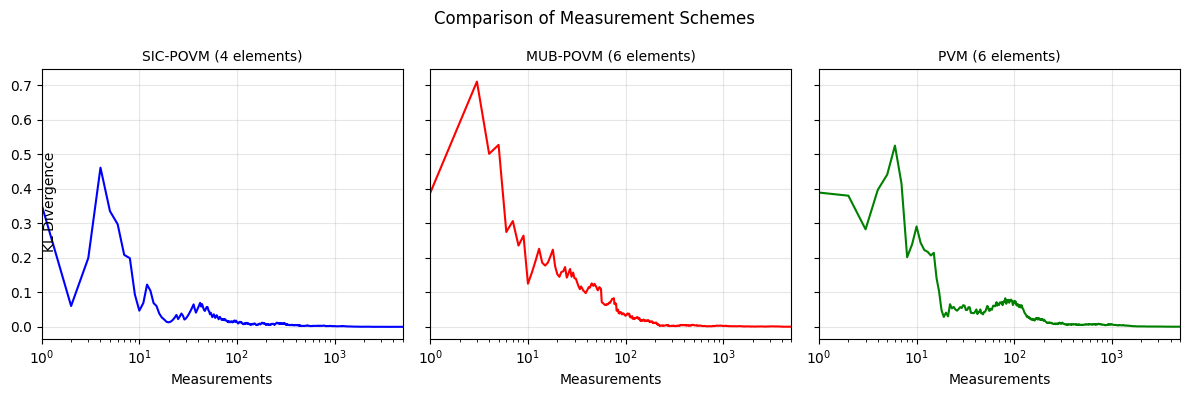

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random
from scipy.spatial import distance

# ==================== UTILITY FUNCTIONS ====================
def heaviside(z):
    """Implementation of the Heaviside function H(z)."""
    return 1 if z >= 0 else 0

def theta(z):
    """Implementation of the function Θ(z) = z·H(z)."""
    return z if z >= 0 else 0

def cartesian_to_spherical(point):
    """Converts a point from Cartesian coordinates (x,y,z) to spherical coordinates (theta, phi)."""
    x, y, z = point
    r = np.sqrt(x**2 + y**2 + z**2)  # Should be 1 for unit sphere
    theta = np.arccos(z / r) * 180 / np.pi
    phi = np.arctan2(y, x) * 180 / np.pi
    if phi < 0:
        phi += 360  # Convert to 0-360 range
    return theta, phi

def bloch_to_ket(point):
    """Converts a point on the Bloch sphere to a quantum state in ket notation."""
    x, y, z = point
    theta = np.arccos(z)
    phi = np.arctan2(y, x)
    alpha = np.cos(theta/2)
    beta_mag = np.sin(theta/2)
    beta_phase = phi

    # Nice formatting for complex numbers (simplified)
    if abs(beta_mag) < 1e-10:
        return "|0>"
    elif abs(alpha) < 1e-10:
        return "|1>"
    else:
        alpha_str = f"{alpha:.4f}"
        if abs(beta_phase) < 1e-10:
            beta_str = f"{beta_mag:.4f}"
        else:
            re = beta_mag * np.cos(beta_phase)
            im = beta_mag * np.sin(beta_phase)
            if abs(im) < 1e-10:
                beta_str = f"{re:.4f}"
            else:
                beta_str = f"{re:.4f}{'+' if im > 0 else '-'}{abs(im):.4f}i"

        return f"{alpha_str}|0> + {beta_str}|1>"

def generate_random_sphere_points(n):
    """Generates n points randomly distributed on the unit sphere."""
    points = np.random.randn(n, 3)
    norms = np.sqrt(np.sum(points**2, axis=1))
    points = points / norms[:, np.newaxis]
    return points

def select_random_points(points, num_select=2):
    """Randomly selects a specified number of points from a given array."""
    indices = np.random.choice(len(points), num_select, replace=False)
    return points[indices]

# ==================== SIMPLE DISTRIBUTION VERIFICATION FUNCTION ====================
def plot_distribution_histogram(points, num_bins=20):
    """
    Create a simple histogram showing uniformity of the random points distribution.
    """
    # Convert points to spherical coordinates
    theta_phi_points = np.array([cartesian_to_spherical(point) for point in points])
    thetas = theta_phi_points[:, 0]  # Polar angle (0 to 180 degrees)
    phis = theta_phi_points[:, 1]    # Azimuthal angle (0 to 360 degrees)

    # Create a figure with 2 subplots
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))

    # 1. Histogram of theta values (should follow sin(theta) distribution for uniform sphere)
    axs[0].hist(thetas, bins=num_bins, alpha=0.7, density=True)

    # Generate the expected sin(theta) distribution
    theta_range = np.linspace(0, 180, 100)
    sin_theta = np.sin(theta_range * np.pi / 180)
    sin_theta = sin_theta / np.trapz(sin_theta, theta_range)  # Normalize
    axs[0].plot(theta_range, sin_theta, 'r-', linewidth=2, label='Expected: sin(θ)')

    axs[0].set_xlabel('Theta (degrees)')
    axs[0].set_ylabel('Density')
    axs[0].set_title('Distribution of Polar Angle θ')
    axs[0].legend()

    # 2. Histogram of phi values (should be uniform for uniform sphere)
    axs[1].hist(phis, bins=num_bins, alpha=0.7, density=True)

    # Generate the expected uniform distribution for phi
    phi_expected = np.ones_like(theta_range) / 360
    phi_range = np.linspace(0, 360, 100)
    axs[1].plot(phi_range, phi_expected, 'r-', linewidth=2, label='Expected: uniform')

    axs[1].set_xlabel('Phi (degrees)')
    axs[1].set_ylabel('Density')
    axs[1].set_title('Distribution of Azimuthal Angle φ')
    axs[1].legend()

    plt.tight_layout()
    return fig

# ==================== SIMPLE BLOCH SPHERE VISUALIZATION ====================
def plot_bloch_sphere(random_points=None, lambda_vectors=None, quantum_state=None,
                     measurement_vectors=None, transformed_lambdas=None, title="Bloch Sphere Visualization",
                     ax=None, measurement_type=None):
    """
    Create a simple 3D visualization of the Bloch sphere with key points.
    Now accepts an existing axis for subplot placement.
    """
    if ax is None:
        fig = plt.figure(figsize=(6, 6))
        ax = fig.add_subplot(111, projection='3d')

    # Plot sphere
    u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
    x = np.cos(u) * np.sin(v)
    y = np.sin(u) * np.sin(v)
    z = np.cos(v)
    ax.plot_wireframe(x, y, z, color='gray', alpha=0.2)

    # Plot coordinate axes
    ax.quiver(0, 0, 0, 1, 0, 0, color='r', length=1.2, arrow_length_ratio=0.1)
    ax.quiver(0, 0, 0, 0, 1, 0, color='g', length=1.2, arrow_length_ratio=0.1)
    ax.quiver(0, 0, 0, 0, 0, 1, color='b', length=1.2, arrow_length_ratio=0.1)

    # Plot random points (just a few for clarity)
    if random_points is not None and len(random_points) > 0:
        # Only plot a subset for clarity
        subset = random_points[:10]  # Reduced from 20 to 10 for better clarity
        ax.scatter(subset[:, 0], subset[:, 1], subset[:, 2], color='gray', alpha=0.2, s=5)

    # Plot lambda vectors
    if lambda_vectors is not None:
        colors = ['red', 'green']
        for i, vec in enumerate(lambda_vectors):
            ax.quiver(0, 0, 0, vec[0], vec[1], vec[2], color=colors[i],
                     length=1.0, arrow_length_ratio=0.1, label=f'λ{i+1}')

    # Plot transformed lambda vectors
    if transformed_lambdas is not None:
        for i, vec in enumerate(transformed_lambdas):
            ax.quiver(0, 0, 0, vec[0], vec[1], vec[2], color='orange' if i == 0 else 'purple',
                     length=1.0, arrow_length_ratio=0.1, label=f'λ{i+1}\'', linestyle='dashed')

    # Plot quantum state
    if quantum_state is not None:
        ax.quiver(0, 0, 0, quantum_state[0], quantum_state[1], quantum_state[2],
                 color='magenta', length=1.0, arrow_length_ratio=0.1, label='ρ')

    # Plot measurement vectors with different styles based on measurement type
    if measurement_vectors is not None:
        # Different styling based on measurement type
        if measurement_type == "SIC-POVM":
            # Tetrahedron - bright colors, thicker arrows
            colors = ['darkblue', 'dodgerblue', 'deepskyblue', 'lightskyblue']
            for i, vec in enumerate(measurement_vectors):
                if i < len(colors):
                    ax.quiver(0, 0, 0, vec[0], vec[1], vec[2],
                             color=colors[i], length=1.2, arrow_length_ratio=0.12,
                             linewidth=2.5)
                    # Add a small marker at the tip
                    ax.scatter(vec[0], vec[1], vec[2], color=colors[i], s=30)

        elif measurement_type == "MUB-POVM":
            # Axes - bright contrasting colors
            colors = ['crimson', 'darkred', 'forestgreen', 'darkgreen', 'gold', 'darkorange']
            for i, vec in enumerate(measurement_vectors):
                if i < len(colors):
                    ax.quiver(0, 0, 0, vec[0], vec[1], vec[2],
                             color=colors[i], length=1.2, arrow_length_ratio=0.12,
                             linewidth=2.5)
                    ax.scatter(vec[0], vec[1], vec[2], color=colors[i], s=30)

        elif measurement_type == "PVM":
            # Cardinal axes - pair-wise same colors with different markers
            colors = ['darkviolet', 'darkviolet', 'orange', 'orange', 'teal', 'teal']
            for i, vec in enumerate(measurement_vectors):
                if i < len(colors):
                    ax.quiver(0, 0, 0, vec[0], vec[1], vec[2],
                             color=colors[i], length=1.2, arrow_length_ratio=0.12,
                             linewidth=2.5, linestyle='solid' if i % 2 == 0 else 'dashed')
                    # Add a different marker for each pair
                    marker = '^' if i % 2 == 0 else 'o'
                    ax.scatter(vec[0], vec[1], vec[2], color=colors[i], s=30, marker=marker)
        else:
            # Default colors if type not specified
            measurement_colors = ['blue', 'cyan', 'yellow', 'green', 'purple', 'orange']
            for i, vec in enumerate(measurement_vectors):
                if i < len(measurement_colors):
                    ax.quiver(0, 0, 0, vec[0], vec[1], vec[2],
                             color=measurement_colors[i], length=1.0, arrow_length_ratio=0.1)

    # Format plot
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(title, fontsize=10)

    # Let's handle legend in the main figure instead of individual subplots
    ax.set_box_aspect([1,1,1])  # Equal aspect ratio

    return ax

# ==================== MEASUREMENT BASIS FUNCTIONS ====================
def create_sic_povm():
    """Creates the SIC-POVM for qubits (tetrahedron on the Bloch sphere)."""
    bloch1 = np.array([0, 0, 1])  # |0⟩ state
    bloch2 = np.array([np.sqrt(8/9), 0, -1/3])
    bloch3 = np.array([-np.sqrt(2/9), np.sqrt(6/9), -1/3])
    bloch4 = np.array([-np.sqrt(2/9), -np.sqrt(6/9), -1/3])

    return np.array([bloch1, bloch2, bloch3, bloch4])

def create_mub_povm():
    """Creates the MUB-POVM for qubits (6 points along cardinal axes)."""
    bloch1 = np.array([0, 0, 1])     # |0⟩ state
    bloch2 = np.array([0, 0, -1])    # |1⟩ state
    bloch3 = np.array([1, 0, 0])     # |+⟩ state
    bloch4 = np.array([-1, 0, 0])    # |-⟩ state
    bloch5 = np.array([0, 1, 0])     # |+i⟩ state
    bloch6 = np.array([0, -1, 0])    # |-i⟩ state

    return np.array([bloch1, bloch2, bloch3, bloch4, bloch5, bloch6])

def create_pvm():
    """Creates standard PVM bases (same points as MUB-POVM but treated as separate bases)."""
    # Same points as MUB-POVM
    return create_mub_povm()

# ==================== KL DIVERGENCE FUNCTION ====================
def improved_kl_divergence(p, q):
    """
    Calculates the Kullback-Leibler divergence between two probability distributions
    with improved numerical stability.
    """
    # Ensure p and q are numpy arrays
    p = np.array(p)
    q = np.array(q)

    # Normalize to ensure proper probability distributions
    p = p / np.sum(p)
    q = q / np.sum(q)

    # Avoid division by zero and log(0) issues
    epsilon = 1e-10
    q_safe = np.maximum(q, epsilon)

    # Calculate KL divergence
    mask = p > 0  # Only consider where p > 0 (since 0*log(0/q) = 0)
    kl_terms = p[mask] * np.log(p[mask] / q_safe[mask])
    kl_div = np.sum(kl_terms)

    return kl_div

# ==================== THEORETICAL PROBABILITY CALCULATION ====================
def calculate_theoretical_quantum_probs(quantum_state, bloch_vectors):
    """
    Calculate the theoretical quantum probabilities using Born's rule:
    p(b|ρ, B_b) = p_b(1 + r·t_b)
    """
    p_b = 1/len(bloch_vectors)  # Base probability depends on number of elements

    probs = []
    for b_vec in bloch_vectors:
        prob = p_b * (1 + np.dot(quantum_state, b_vec))
        probs.append(prob)

    return np.array(probs)

# ==================== PROTOCOL IMPLEMENTATION ====================
def run_protocol(quantum_state, measurement_vectors, num_measurements=10000):
    """
    Run the classical protocol simulation and track KL divergence.
    """
    # Get theoretical quantum probabilities
    quantum_probs = calculate_theoretical_quantum_probs(quantum_state, measurement_vectors)

    # Track outcomes and KL divergence
    outcomes = []
    kl_values = []

    # Start with small counts for all outcomes
    counts = np.ones(len(measurement_vectors)) * 0.1

    # Run protocol
    for i in range(1, num_measurements + 1):
        # 1. Generate two random vectors
        lambda_vectors = generate_random_sphere_points(2)

        # 2. Alice calculates bits
        c1 = heaviside(np.dot(quantum_state, lambda_vectors[0]))
        c2 = heaviside(np.dot(quantum_state, lambda_vectors[1]))

        # 3. Bob transforms lambda vectors
        lambda_prime1 = lambda_vectors[0] if c1 == 1 else -lambda_vectors[0]
        lambda_prime2 = lambda_vectors[1] if c2 == 1 else -lambda_vectors[1]

        # 4. Bob selects measurement direction
        selected_index = np.random.choice(len(measurement_vectors))
        selected_y = measurement_vectors[selected_index]

        # 5. Bob decides which λ' to use
        if abs(np.dot(lambda_prime1, selected_y)) >= abs(np.dot(lambda_prime2, selected_y)):
            selected_lambda = lambda_prime1
        else:
            selected_lambda = lambda_prime2

        # 6. Calculate θ values
        theta_values = np.array([theta(np.dot(y, selected_lambda)) for y in measurement_vectors])

        # 7. Calculate denominator
        p_values = np.array([1/len(measurement_vectors)] * len(measurement_vectors))
        denominator = np.sum(p_values * theta_values)

        # 8. Determine outcome
        if denominator > 0:
            outcome_probs = p_values * theta_values / denominator
            if np.sum(outcome_probs) > 0:
                outcome_probs = outcome_probs / np.sum(outcome_probs)
                outcome = np.random.choice(len(measurement_vectors), p=outcome_probs)
            else:
                outcome = np.random.choice(len(measurement_vectors))
        else:
            outcome = np.random.choice(len(measurement_vectors))

        # Update counts and calculate KL divergence
        outcomes.append(outcome)
        counts[outcome] += 1
        freqs = counts / (i + len(measurement_vectors) * 0.1)
        kl_div = improved_kl_divergence(freqs, quantum_probs)
        kl_values.append(kl_div)

    return np.array(kl_values), quantum_probs, outcomes

# ==================== PVM PROTOCOL IMPLEMENTATION ====================
def run_pvm_protocol(quantum_state, pvm_vectors, num_measurements=10000):
    """
    Run the Bell scenario protocol with PVM and track KL divergence.
    """
    # Group PVM elements by basis
    bases = [("Z", [0, 1]), ("X", [2, 3]), ("Y", [4, 5])]

    # Calculate theoretical probabilities
    theoretical_probs = np.zeros(len(pvm_vectors))
    for i, vec in enumerate(pvm_vectors):
        theoretical_probs[i] = (1 + np.dot(quantum_state, vec)) / 2

    # Normalize by basis
    for _, indices in bases:
        i, j = indices
        basis_sum = theoretical_probs[i] + theoretical_probs[j]
        theoretical_probs[i] /= basis_sum
        theoretical_probs[j] /= basis_sum

    # Equal probability of selecting each basis
    theoretical_probs /= 3

    # Track outcomes and KL divergence
    outcomes = []
    basis_choices = []
    kl_values = []

    # Start with small counts
    counts = np.ones(len(pvm_vectors)) * 0.1

    # Run protocol
    for i in range(1, num_measurements + 1):
        # Generate lambda vectors
        lambda_vectors = generate_random_sphere_points(2)

        # Alice calculates bits
        c1 = heaviside(np.dot(quantum_state, lambda_vectors[0]))
        c2 = heaviside(np.dot(quantum_state, lambda_vectors[1]))

        # Bob transforms lambda vectors
        lambda_prime1 = lambda_vectors[0] if c1 == 1 else -lambda_vectors[0]
        lambda_prime2 = lambda_vectors[1] if c2 == 1 else -lambda_vectors[1]

        # Choose random basis
        basis_idx = np.random.choice(len(bases))
        basis_indices = bases[basis_idx][1]
        basis_choices.append(basis_idx)

        # Calculate alignment with basis vectors
        alignment1 = np.mean([abs(np.dot(lambda_prime1, pvm_vectors[idx])) for idx in basis_indices])
        alignment2 = np.mean([abs(np.dot(lambda_prime2, pvm_vectors[idx])) for idx in basis_indices])

        # Choose lambda with better alignment
        selected_lambda = lambda_prime1 if alignment1 >= alignment2 else lambda_prime2

        # Perform measurement in selected basis
        idx1, idx2 = basis_indices
        prob1 = (1 + np.dot(quantum_state, pvm_vectors[idx1])) / 2

        # Determine outcome
        if np.random.random() < prob1:
            outcome = idx1
        else:
            outcome = idx2

        # Update counts and calculate KL divergence
        outcomes.append(outcome)
        counts[outcome] += 1
        freqs = counts / (i + len(pvm_vectors) * 0.1)
        kl_div = improved_kl_divergence(freqs, theoretical_probs)
        kl_values.append(kl_div)

    return np.array(kl_values), theoretical_probs, outcomes, basis_choices

# ==================== KL DIVERGENCE PLOTTING ====================
def plot_kl_divergence_comparison(kl_values_dict, title="KL Divergence Comparison"):
    """
    Plot multiple KL divergence curves on side-by-side subplots for better readability.

    Args:
        kl_values_dict: Dictionary with format {'name': kl_values_array}
        title: Title for the overall figure

    Returns:
        matplotlib figure
    """
    n_plots = len(kl_values_dict)
    fig, axs = plt.subplots(1, n_plots, figsize=(12, 4), sharey=True)

    # If only one plot, axs might not be an array
    if n_plots == 1:
        axs = [axs]

    colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown']

    for i, (name, values) in enumerate(kl_values_dict.items()):
        axs[i].plot(range(1, len(values) + 1), values, color=colors[i % len(colors)])
        axs[i].set_xscale('log')

        # Setting a shorter x-axis range (adjust as needed)
        # Only show up to 5000 measurements or max available if less
        max_x = min(5000, len(values))
        axs[i].set_xlim(1, max_x)

        # Add title to each subplot
        axs[i].set_title(f'{name}', fontsize=10)
        axs[i].grid(True, alpha=0.3)

        # Add x-axis label to each subplot
        axs[i].set_xlabel('Measurements')

    # Add common y-axis label to the figure
    fig.text(0.04, 0.5, 'KL Divergence', va='center', rotation='vertical')

    # Add overall title
    fig.suptitle(title, fontsize=12)
    plt.tight_layout()

    return fig

# ==================== COMBINED BLOCH SPHERE VISUALIZATION ====================
def plot_combined_bloch_spheres(random_points, lambda_vectors, quantum_state, transformed_lambdas):
    """
    Create a combined figure with all three Bloch sphere visualizations side by side.
    """
    # Create a figure with three 3D subplots side by side
    fig = plt.figure(figsize=(15, 5))

    # Create measurement vectors
    sic_vectors = create_sic_povm()
    mub_vectors = create_mub_povm()
    pvm_vectors = create_pvm()

    # SIC-POVM visualization
    ax1 = fig.add_subplot(131, projection='3d')
    plot_bloch_sphere(
        random_points[:10],
        lambda_vectors,
        quantum_state,
        sic_vectors,
        transformed_lambdas,
        title="SIC-POVM",
        ax=ax1,
        measurement_type="SIC-POVM"
    )

    # MUB-POVM visualization
    ax2 = fig.add_subplot(132, projection='3d')
    plot_bloch_sphere(
        random_points[:10],
        lambda_vectors,
        quantum_state,
        mub_vectors,
        transformed_lambdas,
        title="MUB-POVM",
        ax=ax2,
        measurement_type="MUB-POVM"
    )

    # PVM visualization
    ax3 = fig.add_subplot(133, projection='3d')
    plot_bloch_sphere(
        random_points[:10],
        lambda_vectors,
        quantum_state,
        pvm_vectors,
        transformed_lambdas,
        title="PVM",
        ax=ax3,
        measurement_type="PVM"
    )

    # Add a common legend for the entire figure
    handles, labels = [], []
    for ax in [ax1, ax2, ax3]:
        h, l = ax.get_legend_handles_labels()
        for handle, label in zip(h, l):
            if label not in labels:
                handles.append(handle)
                labels.append(label)

    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.05),
              ncol=3, fontsize=8)

    plt.tight_layout(rect=[0, 0.08, 1, 0.95])  # Make room for the legend

    return fig

# ==================== COMPARATIVE ANALYSIS ====================
def compare_measurement_schemes(quantum_state, n_measurements=10000):
    """
    Compare different measurement schemes (SIC-POVM, MUB-POVM, PVM) on the same quantum state.
    """
    # Create measurement vectors
    sic_vectors = create_sic_povm()
    mub_vectors = create_mub_povm()
    pvm_vectors = create_pvm()

    # Run simulations
    print("Running SIC-POVM simulation...")
    sic_kl_values, sic_probs, _ = run_protocol(quantum_state, sic_vectors, n_measurements)

    print("Running MUB-POVM simulation...")
    mub_kl_values, mub_probs, _ = run_protocol(quantum_state, mub_vectors, n_measurements)

    print("Running PVM simulation...")
    pvm_kl_values, pvm_probs, _, basis_choices = run_pvm_protocol(quantum_state, pvm_vectors, n_measurements)

    # Create dictionary for KL values
    kl_values_dict = {
        'SIC-POVM (4 elements)': sic_kl_values,
        'MUB-POVM (6 elements)': mub_kl_values,
        'PVM (6 elements)': pvm_kl_values
    }

    # Create the improved plot
    comparison_fig = plot_kl_divergence_comparison(kl_values_dict, "Comparison of Measurement Schemes")

    # Return data and figure
    return {
        'sic_kl_values': sic_kl_values,
        'mub_kl_values': mub_kl_values,
        'pvm_kl_values': pvm_kl_values,
        'comparison_fig': comparison_fig
    }

# ==================== MAIN FUNCTION ====================
def main():
    # Ask user for number of measurements
    while True:
        try:
            n_measurements_input = input("Podaj liczbę przebiegów protokołu (domyślnie 10000): ")
            if n_measurements_input.strip() == "":
                n_measurements = 10000  # Default value
                break
            n_measurements = int(n_measurements_input)
            if n_measurements <= 0:
                print("Liczba przebiegów musi być dodatnia.")
                continue
            break
        except ValueError:
            print("Proszę podać poprawną liczbę całkowitą.")

    print(f"Uruchamianie symulacji z {n_measurements} przebiegami...")

    # Set random seed
    np.random.seed(42)
    random.seed(42)

    # Generate random points and select quantum state
    n_points = 1000
    random_points = generate_random_sphere_points(n_points)
    quantum_state = select_random_points(random_points, num_select=1)[0]
    lambda_vectors = select_random_points(random_points, num_select=2)

    print(f"Wybrany stan kwantowy: {quantum_state}")
    print(f"Stan kwantowy w notacji ket: {bloch_to_ket(quantum_state)}")

    # Calculate transformed lambda vectors
    c1 = heaviside(np.dot(quantum_state, lambda_vectors[0]))
    c2 = heaviside(np.dot(quantum_state, lambda_vectors[1]))
    transformed_lambdas = [
        lambda_vectors[0] if c1 == 1 else -lambda_vectors[0],
        lambda_vectors[1] if c2 == 1 else -lambda_vectors[1]
    ]

    # 1. Create uniformity distribution histogram
    dist_fig = plot_distribution_histogram(random_points)
    plt.figure(dist_fig.number)
    plt.savefig('distribution_histogram.png', dpi=300, bbox_inches='tight')

    # 2. Create combined Bloch sphere visualization
    bloch_fig = plot_combined_bloch_spheres(
        random_points,
        lambda_vectors,
        quantum_state,
        transformed_lambdas
    )
    plt.figure(bloch_fig.number)
    plt.savefig('combined_bloch_visualization.png', dpi=300, bbox_inches='tight')

    # 3. Run comparative analysis and create KL divergence comparison plot
    comparison_results = compare_measurement_schemes(quantum_state, n_measurements)

    # Save comparison figure
    plt.figure(comparison_results['comparison_fig'].number)
    plt.savefig('kl_divergence_comparison.png', dpi=300, bbox_inches='tight')

    print("Symulacja zakończona. Wykresy zostały zapisane.")

    # Show all figures
    plt.show()

if __name__ == "__main__":
    main()

Comparing quantum probabilities with the Toner-Bacon protocol for all Bell states...

Analyzing Bell state: psi-

Analyzing Bell state: psi+

Analyzing Bell state: phi-

Analyzing Bell state: phi+
Condensed heatmaps saved as 'bell_states_heatmaps.png'
Table for psi- saved as 'psi-_table.png'
Table for psi+ saved as 'psi+_table.png'
Table for phi- saved as 'phi-_table.png'
Table for phi+ saved as 'phi+_table.png'
Combined tables saved as 'combined_tables.png'

Analyzing KL divergence convergence...
Analyzing KL convergence for psi-...
  100 trials: KL = 0.013920
  215 trials: KL = 0.003929
  464 trials: KL = 0.003719
  1000 trials: KL = 0.000555
  2154 trials: KL = 0.000555
  4641 trials: KL = 0.000408
  10000 trials: KL = 0.000099
  21544 trials: KL = 0.000082
  46415 trials: KL = 0.000038
  100000 trials: KL = 0.000026
Analyzing KL convergence for psi+...
  100 trials: KL = 0.019970
  215 trials: KL = 0.005152
  464 trials: KL = 0.003535
  1000 trials: KL = 0.000657
  2154 trials: KL 

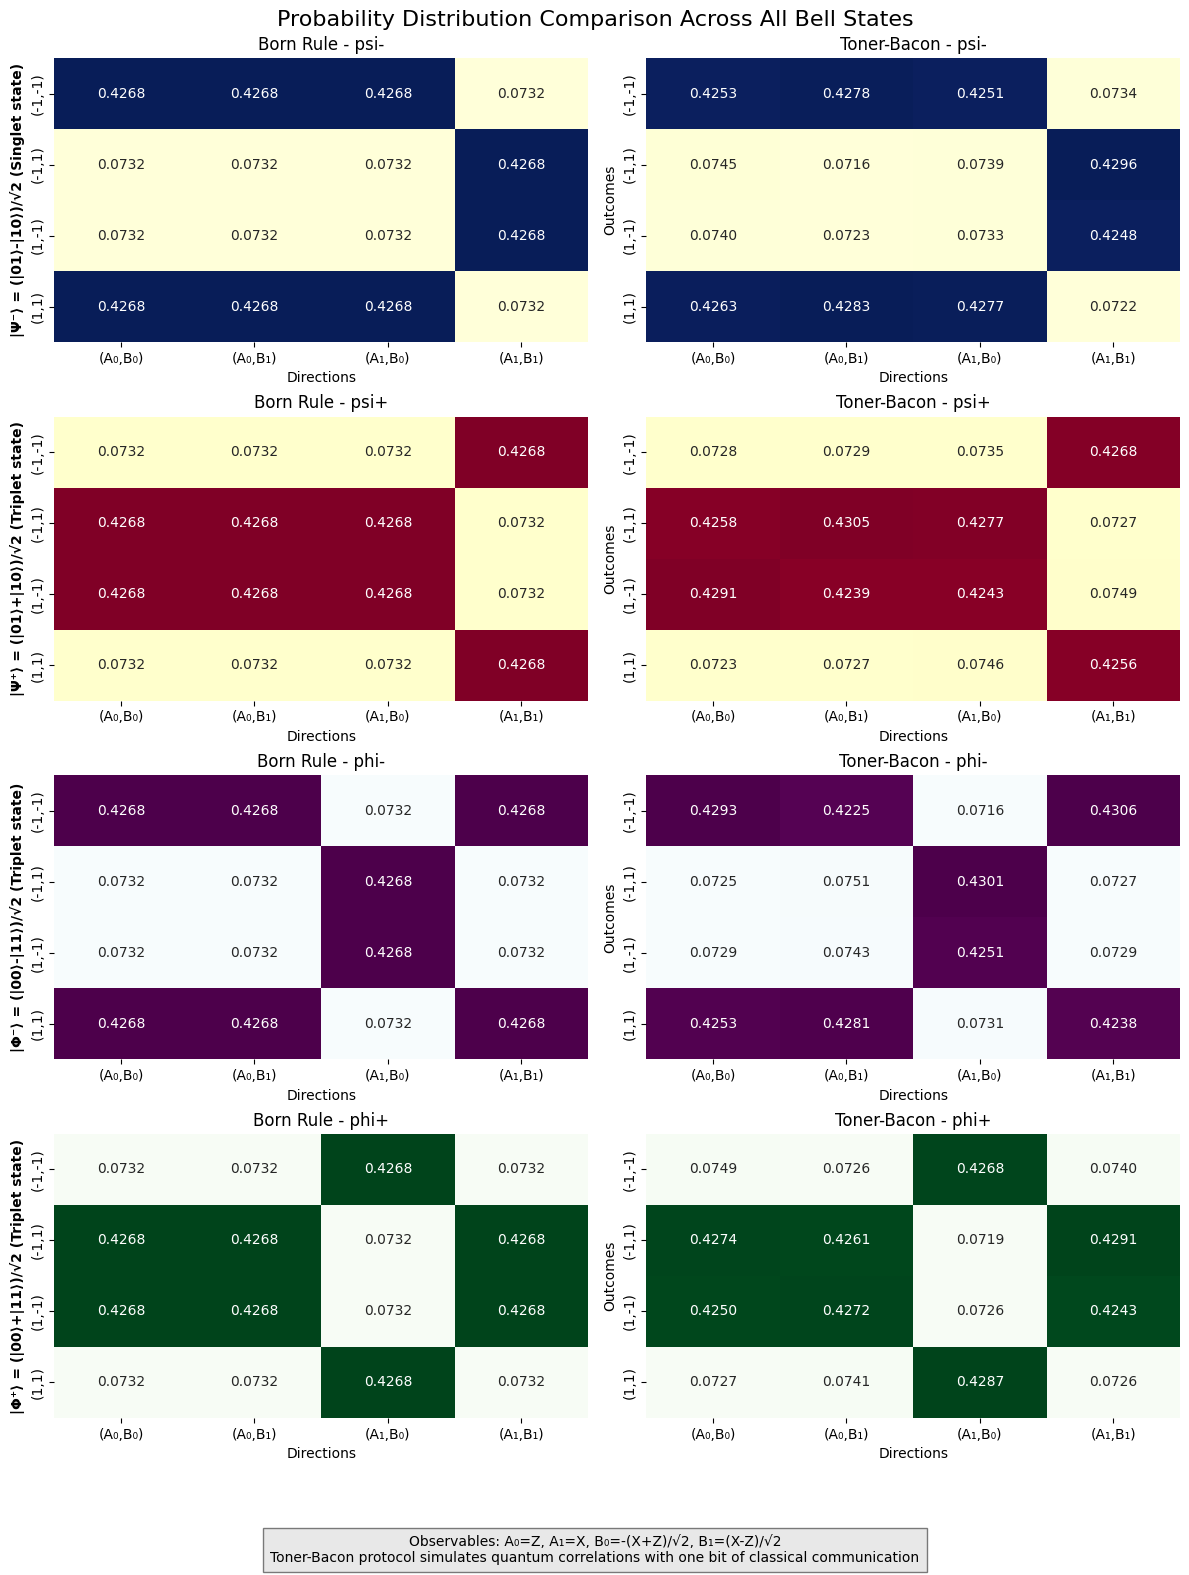

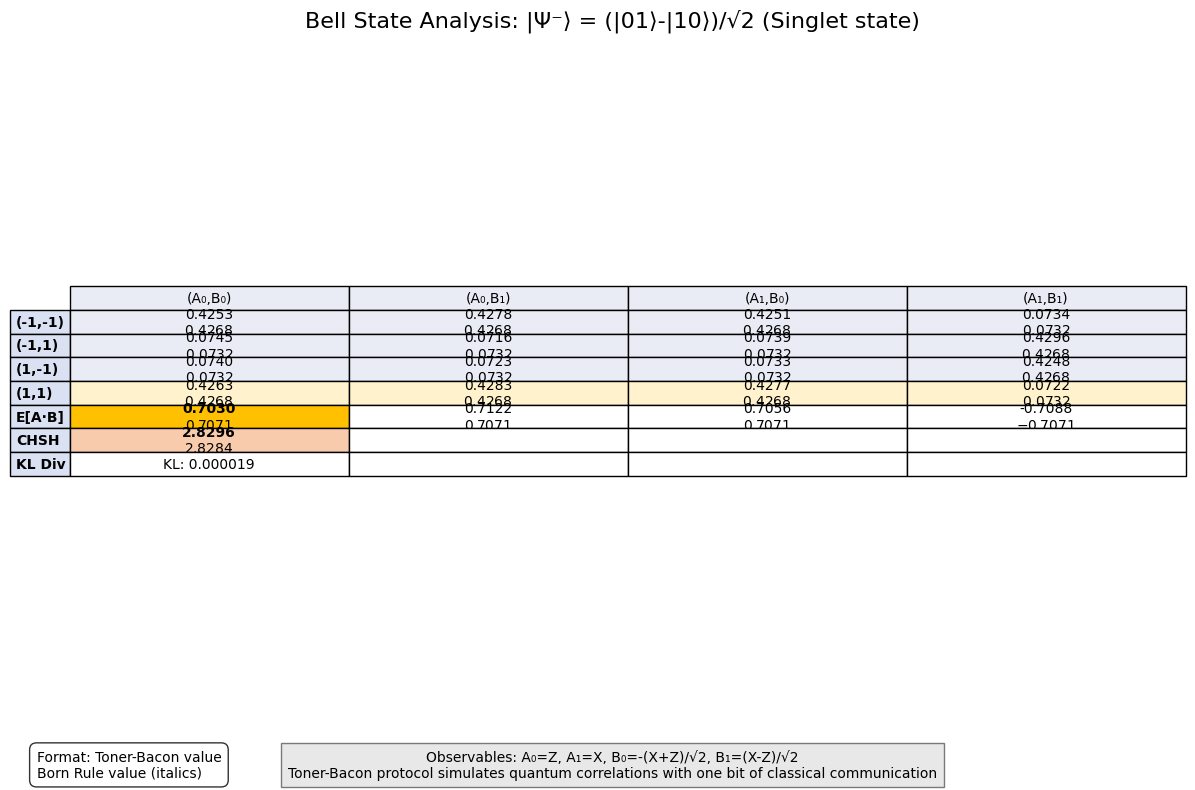

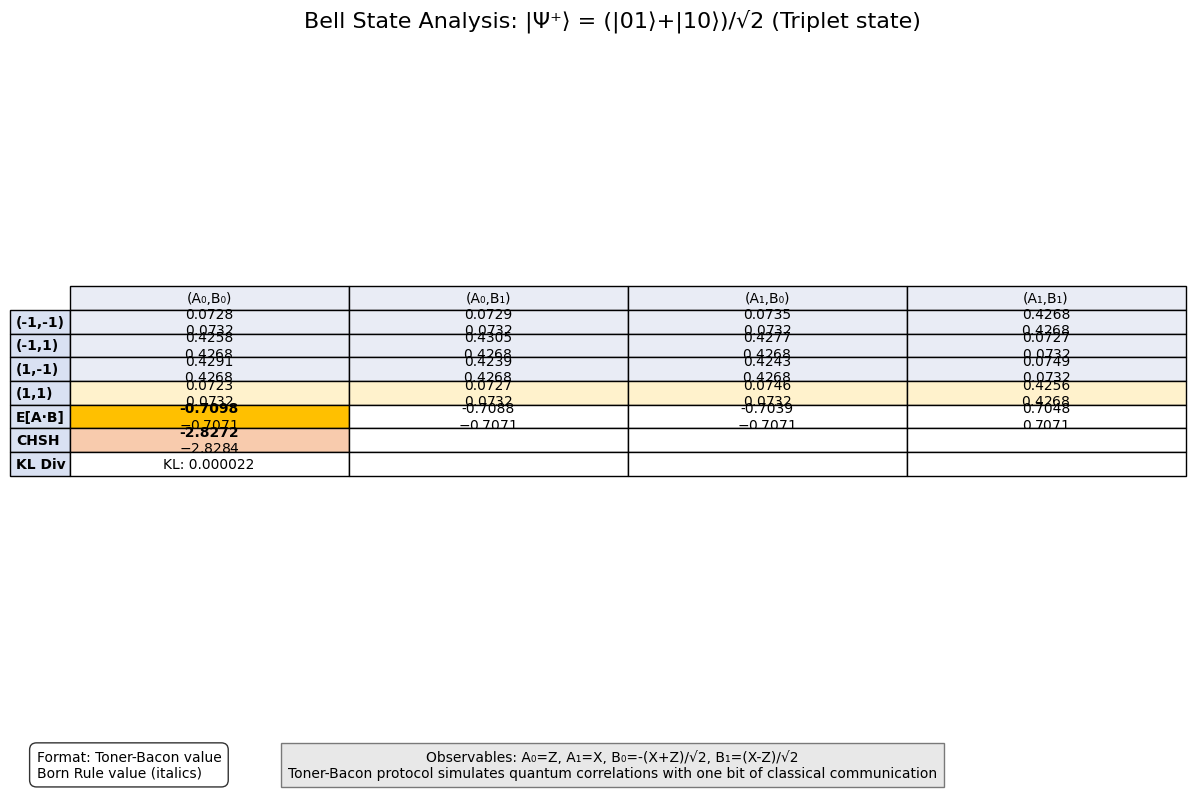

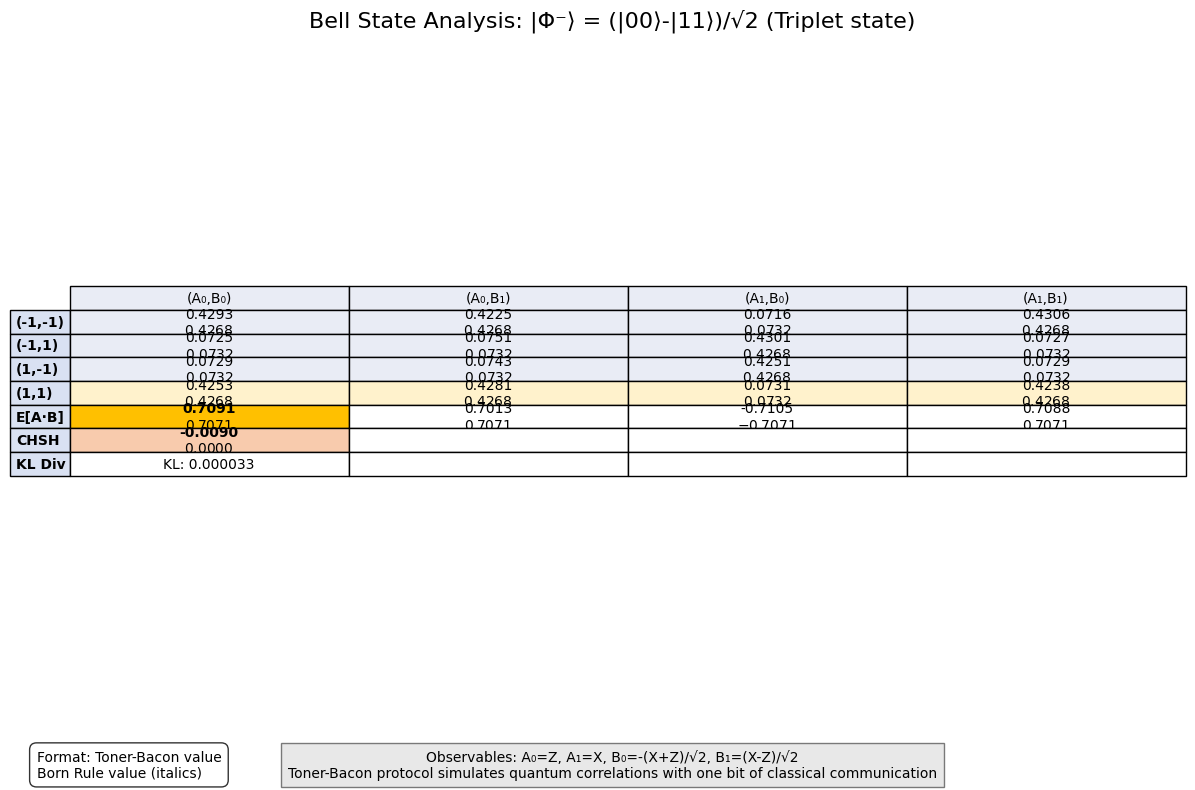

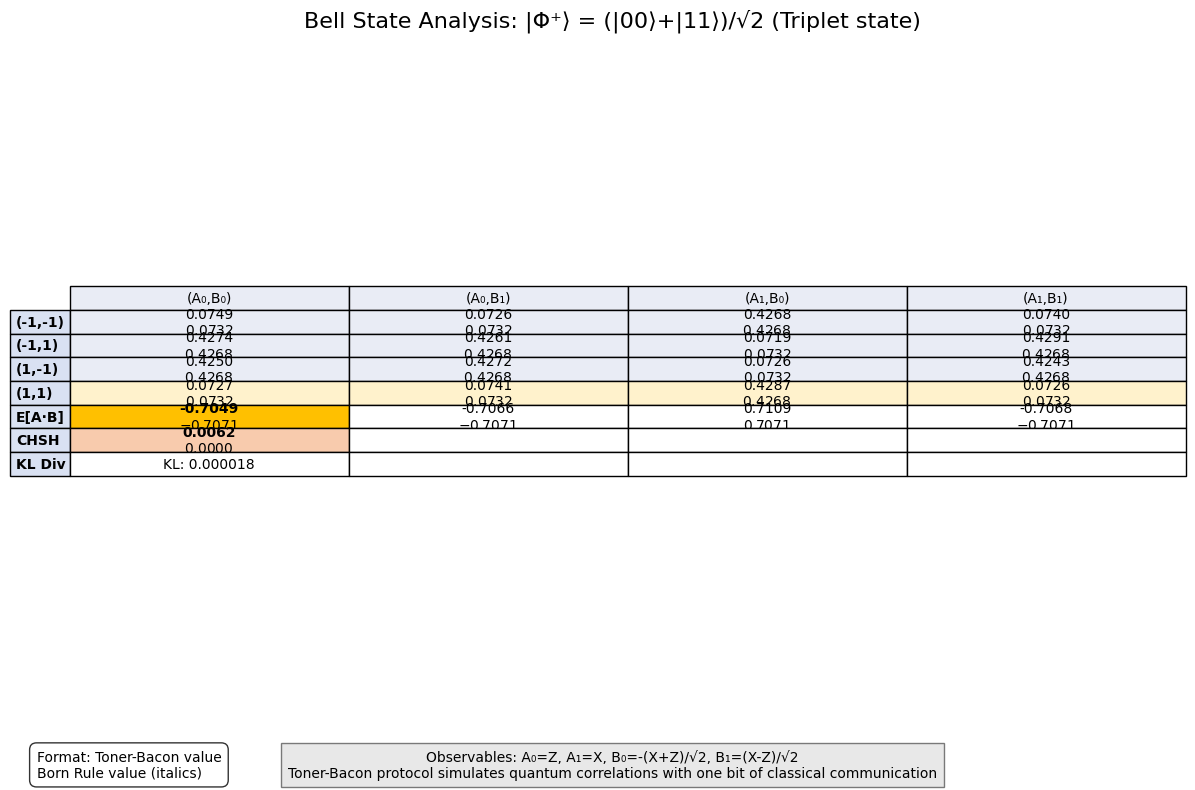

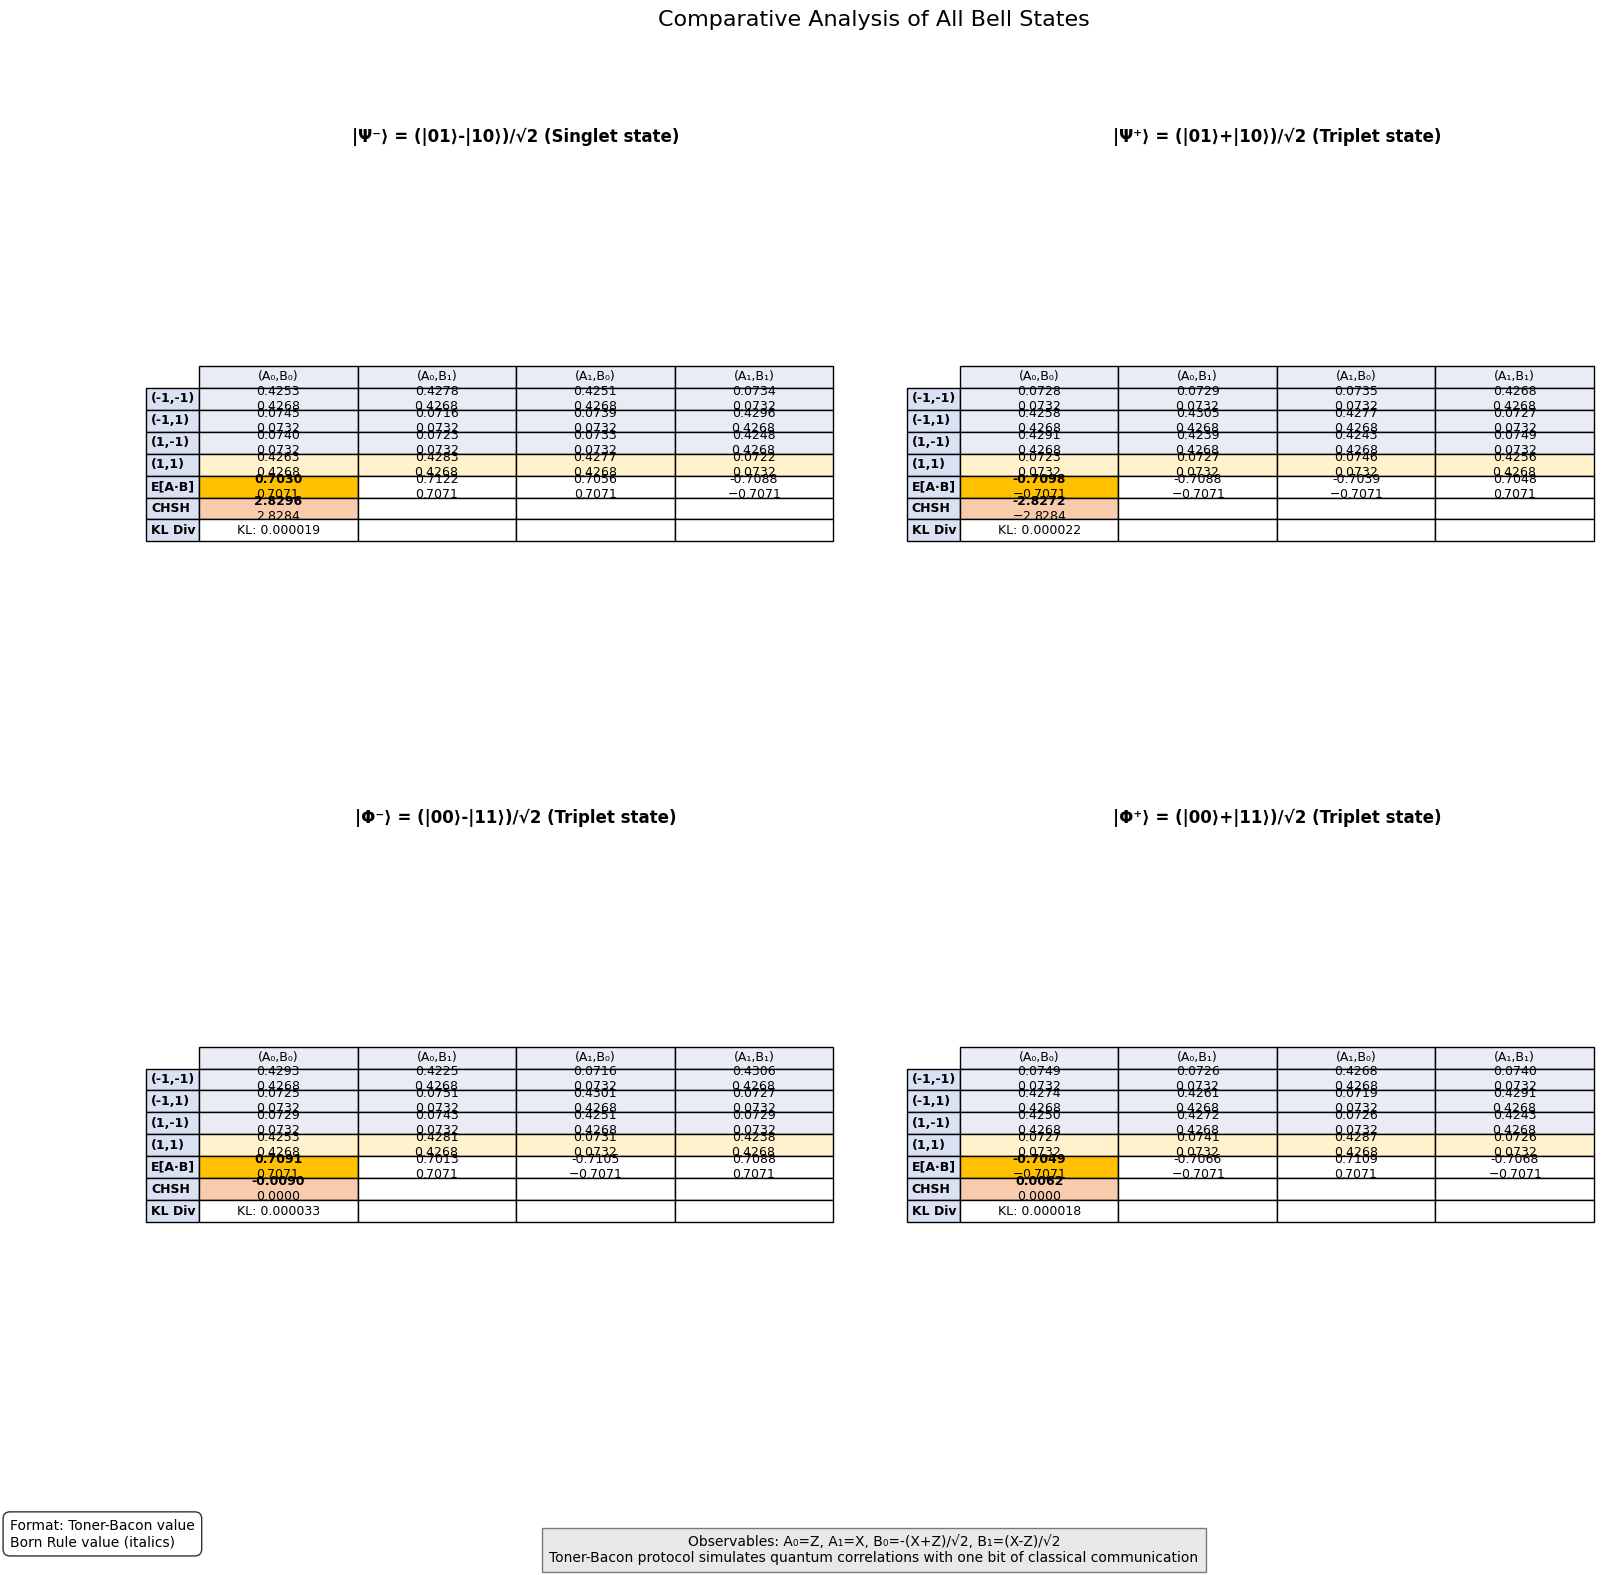

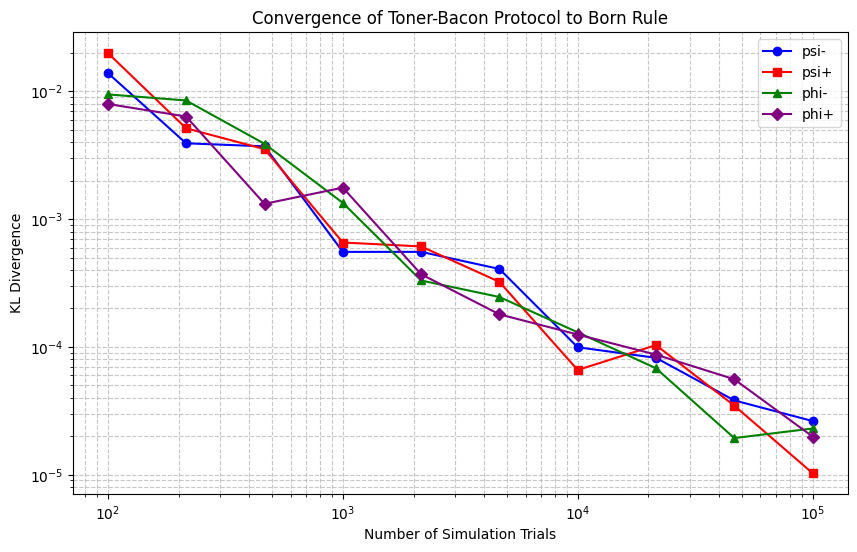

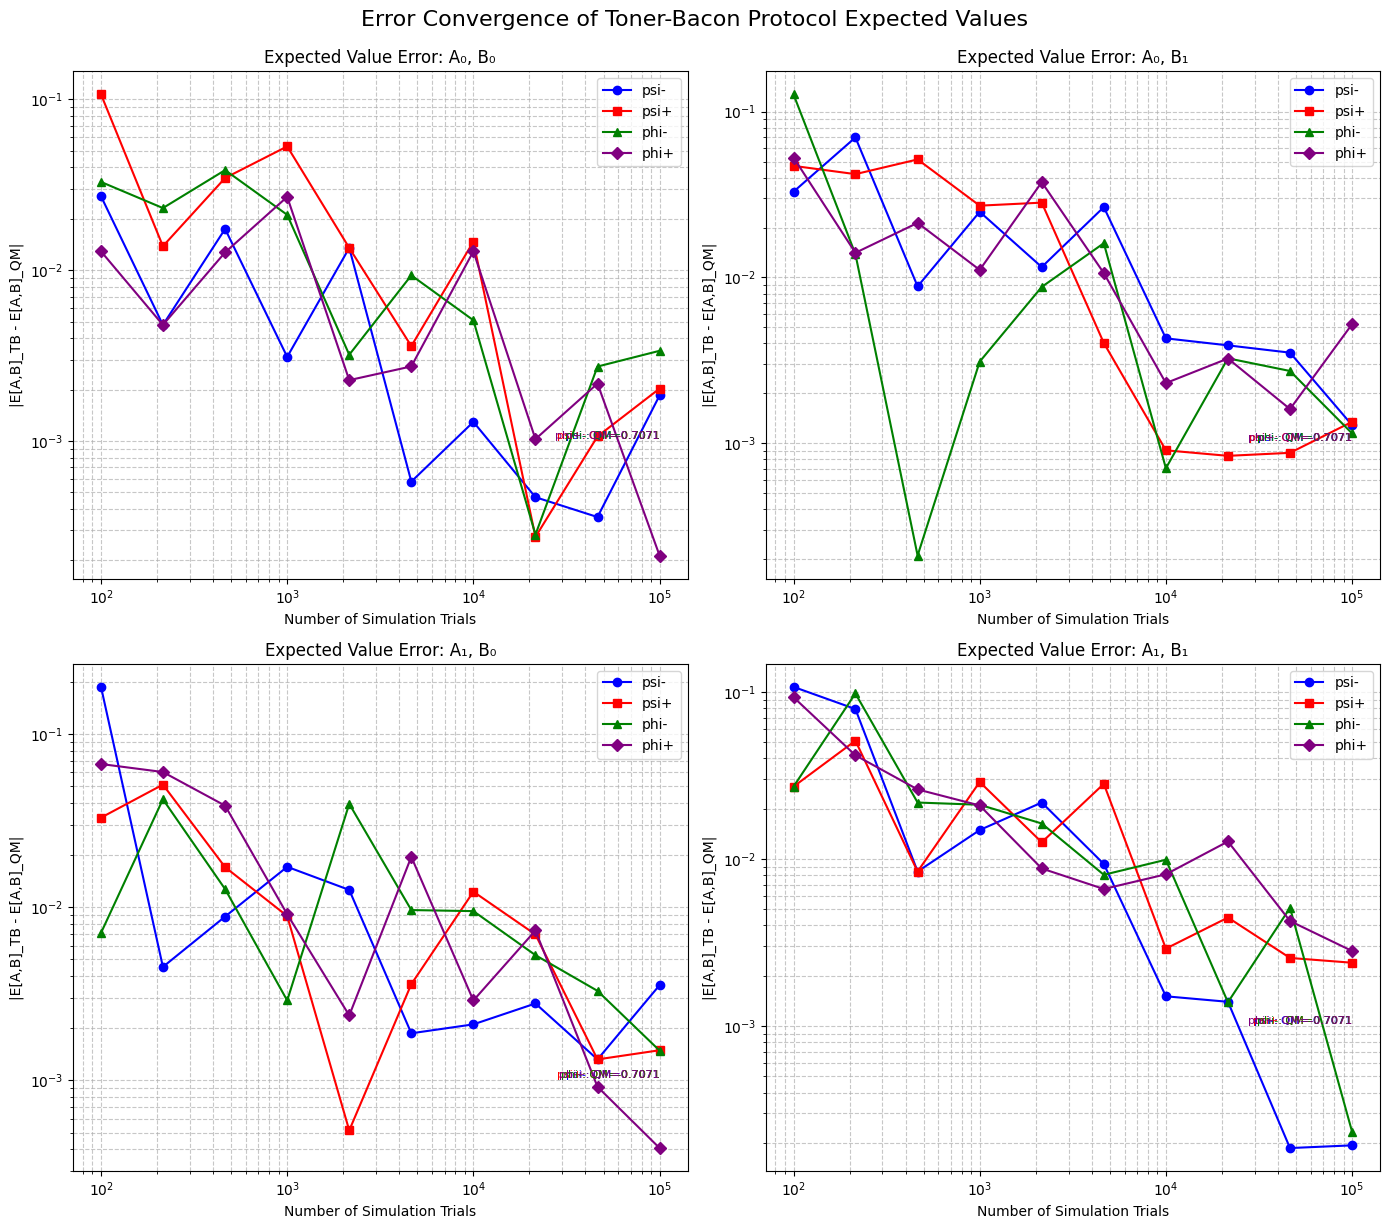

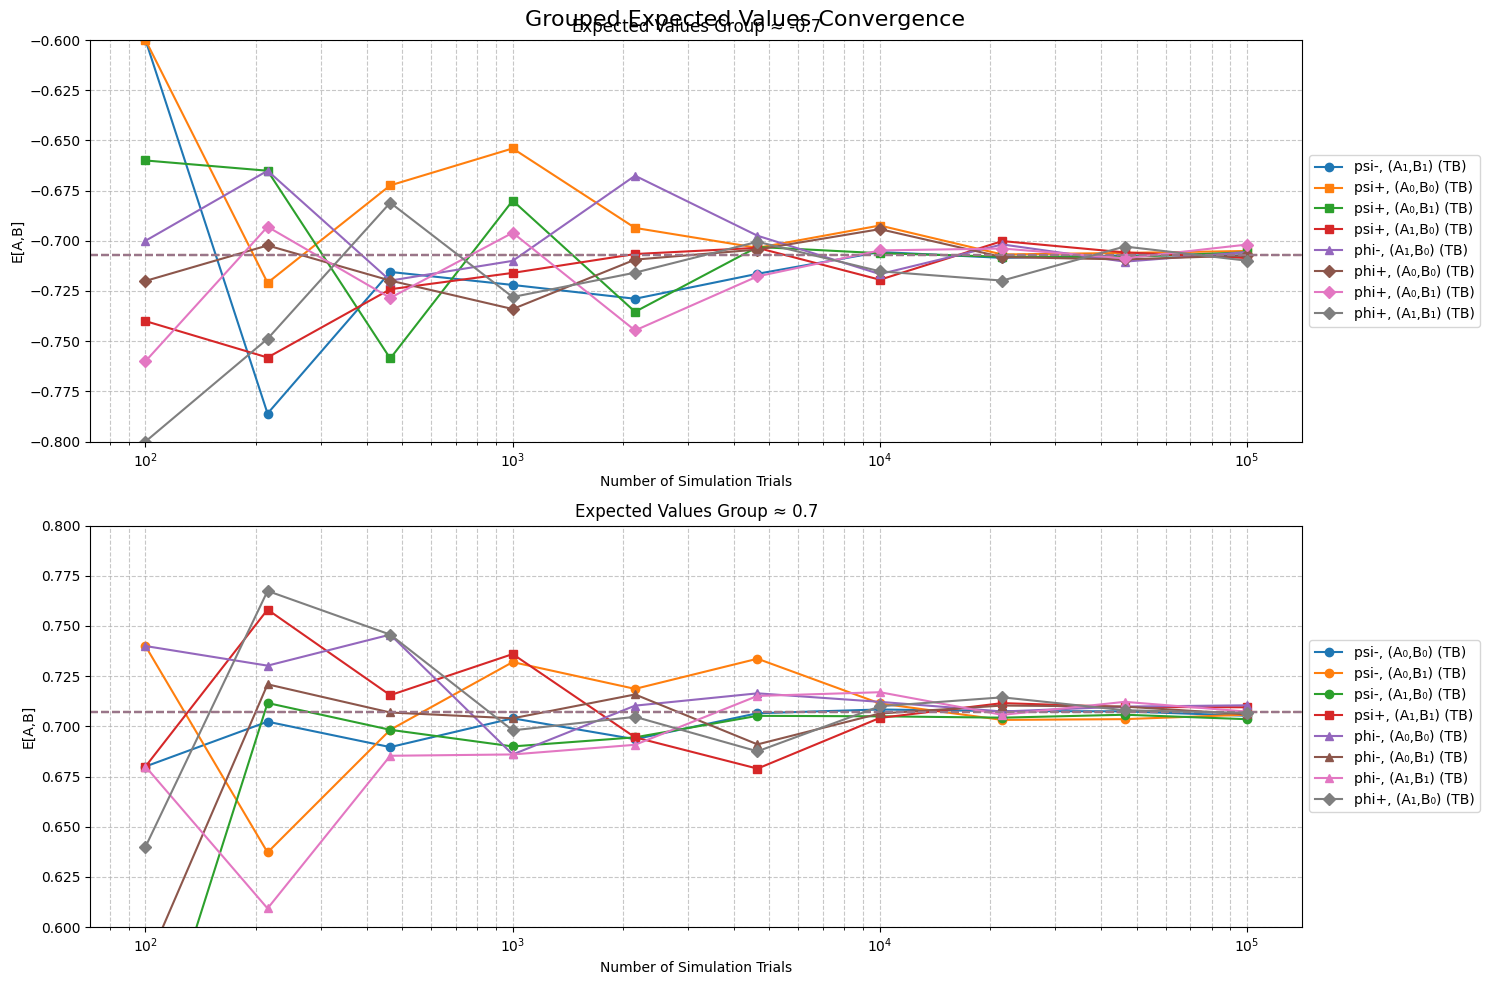

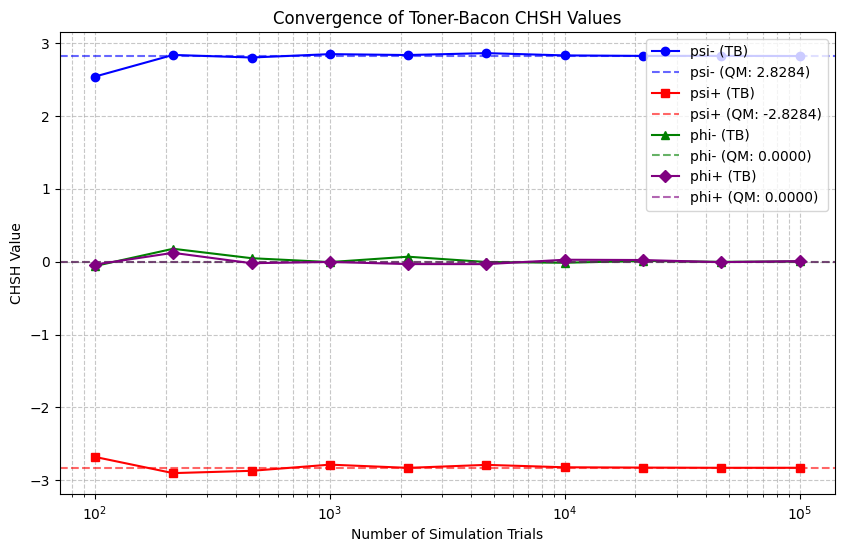

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.font_manager import FontProperties
from scipy.stats import entropy
import time

def sgn(x):
    """Sign function: returns +1 for x ≥ 0, -1 for x < 0."""
    return 1 if x >= 0 else -1

def quantum_probabilities(alice_dir, bob_dir, bell_state):
    """
    Calculates theoretical quantum probabilities for measurements on any Bell state.

    Args:
        alice_dir, bob_dir: measurement direction vectors (normalized)
        bell_state: string indicating which Bell state to use:
                    'psi-': Singlet state (|Ψ⁻⟩ = (|01⟩-|10⟩)/√2)
                    'psi+': Triplet state (|Ψ⁺⟩ = (|01⟩+|10⟩)/√2)
                    'phi-': Triplet state (|Φ⁻⟩ = (|00⟩-|11⟩)/√2)
                    'phi+': Triplet state (|Φ⁺⟩ = (|00⟩+|11⟩)/√2)

    Returns:
        Dictionary with probabilities for each combination of results {(+1,+1), (+1,-1), (-1,+1), (-1,-1)}
    """
    # Normalize measurement directions
    a = alice_dir / np.linalg.norm(alice_dir)
    b = bob_dir / np.linalg.norm(bob_dir)

    # Different correlation based on Bell state
    if bell_state == 'psi-':  # (|01⟩-|10⟩)/√2
        correlation = -np.dot(a, b)
    elif bell_state == 'psi+':  # (|01⟩+|10⟩)/√2
        correlation = np.dot(a, b)
    elif bell_state == 'phi-':  # (|00⟩-|11⟩)/√2
        # For Φ⁻, flip x and y coordinates of b
        b_flipped = np.array([-b[0], -b[1], b[2]])
        correlation = -np.dot(a, b_flipped)
    elif bell_state == 'phi+':  # (|00⟩+|11⟩)/√2
        # For Φ⁺, flip x and y coordinates of b
        b_flipped = np.array([-b[0], -b[1], b[2]])
        correlation = np.dot(a, b_flipped)
    else:
        raise ValueError(f"Unknown Bell state: {bell_state}")

    # Calculate probabilities for each combination of results
    # P(a,b) = (1 + ab·correlation)/4, where a,b ∈ {+1,-1}
    probs = {}
    for alice_outcome in [1, -1]:
        for bob_outcome in [1, -1]:
            key = (alice_outcome, bob_outcome)
            probs[key] = (1 + alice_outcome * bob_outcome * correlation) / 4

    return probs

def toner_bacon_simulation(alice_dir, bob_dir, bell_state, num_trials=100000):
    """
    Simulates the Toner-Bacon protocol for any Bell state and calculates probabilities.

    Args:
        alice_dir, bob_dir: measurement direction vectors
        bell_state: string indicating which Bell state to use
        num_trials: number of simulation trials

    Returns:
        Dictionary with probabilities for each combination of results
    """
    # Normalize measurement directions
    alice_dir = np.array(alice_dir) / np.linalg.norm(alice_dir)
    bob_dir = np.array(bob_dir) / np.linalg.norm(bob_dir)

    # Adjust bob_dir based on Bell state
    if bell_state in ['phi-', 'phi+']:
        # For Φ⁻ and Φ⁺, flip x and y coordinates of bob_dir
        bob_dir = np.array([-bob_dir[0], -bob_dir[1], bob_dir[2]])

    # Determine correlation sign based on Bell state
    sign = -1 if bell_state in ['psi-', 'phi-'] else 1

    # Results
    outcomes = {(1, 1): 0, (1, -1): 0, (-1, 1): 0, (-1, -1): 0}

    for _ in range(num_trials):
        # 1. Generate two random unit vectors
        lambda_1 = np.random.randn(3)
        lambda_1 /= np.linalg.norm(lambda_1)
        lambda_2 = np.random.randn(3)
        lambda_2 /= np.linalg.norm(lambda_2)

        # 2. Alice calculates her result (using sign for correct Bell state)
        alice_outcome = sign * sgn(np.dot(alice_dir, lambda_1))

        # 3. Alice sends communication bit c = sgn(a·λ₁)·sgn(a·λ₂)
        c = sgn(np.dot(alice_dir, lambda_1)) * sgn(np.dot(alice_dir, lambda_2))

        # 4. Bob calculates his result
        bob_outcome = sgn(np.dot(bob_dir, lambda_1 + c * lambda_2))

        # 5. Count the result
        outcomes[(alice_outcome, bob_outcome)] += 1

    # Calculate probabilities
    total = sum(outcomes.values())
    return {key: count / total for key, count in outcomes.items()}

def calculate_expected_value(probs):
    """Calculates the expected value E[A,B] from probabilities P(a,b)."""
    expected = 0
    for (a, b), prob in probs.items():
        expected += a * b * prob
    return expected

def calculate_kl_divergence(p, q):
    """
    Calculate Kullback-Leibler divergence between two probability distributions.

    Args:
        p: First probability distribution (reference)
        q: Second probability distribution

    Returns:
        KL divergence value
    """
    # Convert dictionaries to arrays in the same order
    outcomes = [(1, 1), (1, -1), (-1, 1), (-1, -1)]
    p_array = np.array([p[outcome] for outcome in outcomes])
    q_array = np.array([q[outcome] for outcome in outcomes])

    # Avoid division by zero
    q_array = np.maximum(q_array, 1e-10)

    # Calculate KL divergence
    return entropy(p_array, q_array)

def run_analysis(bell_state, num_trials=100000):
    """
    Main function comparing quantum probabilities with the Toner-Bacon protocol.

    Args:
        bell_state: String indicating which Bell state to analyze
        num_trials: Number of trials for the Toner-Bacon simulation

    Returns:
        DataFrame with results
    """
    # Definition of measurement directions
    directions = {
        'A₀': np.array([0, 0, 1]),     # Z
        'A₁': np.array([1, 0, 0]),     # X
        'B₀': np.array([-1/np.sqrt(2), 0, -1/np.sqrt(2)]),  # -(X+Z)/√2
        'B₁': np.array([1/np.sqrt(2), 0, -1/np.sqrt(2)])    # (X-Z)/√2
    }

    # Data preparation
    data = []
    expected_values = {}
    kl_divergences = {}

    # For each pair of measurement directions
    for a_name in ['A₀', 'A₁']:
        for b_name in ['B₀', 'B₁']:
            a_dir = directions[a_name]
            b_dir = directions[b_name]

            # Calculate theoretical quantum probabilities
            quantum_probs = quantum_probabilities(a_dir, b_dir, bell_state)

            # Simulate the Toner-Bacon protocol
            tb_probs = toner_bacon_simulation(a_dir, b_dir, bell_state, num_trials)

            # Calculate KL divergence
            kl_div = calculate_kl_divergence(quantum_probs, tb_probs)
            kl_divergences[(a_name, b_name)] = kl_div

            # Add probability data
            for a_outcome in [1, -1]:
                for b_outcome in [1, -1]:
                    outcome = (a_outcome, b_outcome)
                    row = {
                        'Directions': f"({a_name},{b_name})",
                        'Outcomes': f"({a_outcome},{b_outcome})",
                        'Born Rule': quantum_probs[outcome],
                        'Toner-Bacon': tb_probs[outcome],
                        'Difference': abs(quantum_probs[outcome] - tb_probs[outcome])
                    }
                    data.append(row)

            # Calculate expected values E[A,B]
            if bell_state == 'psi-':
                quantum_expected = -np.dot(a_dir/np.linalg.norm(a_dir), b_dir/np.linalg.norm(b_dir))
            elif bell_state == 'psi+':
                quantum_expected = np.dot(a_dir/np.linalg.norm(a_dir), b_dir/np.linalg.norm(b_dir))
            elif bell_state == 'phi-':
                b_flipped = np.array([-b_dir[0], -b_dir[1], b_dir[2]]) / np.linalg.norm(b_dir)
                quantum_expected = -np.dot(a_dir/np.linalg.norm(a_dir), b_flipped)
            elif bell_state == 'phi+':
                b_flipped = np.array([-b_dir[0], -b_dir[1], b_dir[2]]) / np.linalg.norm(b_dir)
                quantum_expected = np.dot(a_dir/np.linalg.norm(a_dir), b_flipped)

            tb_expected = calculate_expected_value(tb_probs)

            expected_values[(a_name, b_name)] = {
                'quantum': quantum_expected,
                'toner_bacon': tb_expected
            }

            # Add row for expected value
            row = {
                'Directions': f"({a_name},{b_name})",
                'Outcomes': 'E[A·B]',
                'Born Rule': quantum_expected,
                'Toner-Bacon': tb_expected,
                'Difference': abs(quantum_expected - tb_expected)
            }
            data.append(row)

    # Calculate CHSH parameter
    # CHSH = E[A₀B₀] + E[A₀B₁] + E[A₁B₀] - E[A₁B₁]
    chsh_quantum = (expected_values[('A₀', 'B₀')]['quantum'] +
                   expected_values[('A₀', 'B₁')]['quantum'] +
                   expected_values[('A₁', 'B₀')]['quantum'] -
                   expected_values[('A₁', 'B₁')]['quantum'])

    chsh_tb = (expected_values[('A₀', 'B₀')]['toner_bacon'] +
              expected_values[('A₀', 'B₁')]['toner_bacon'] +
              expected_values[('A₁', 'B₀')]['toner_bacon'] -
              expected_values[('A₁', 'B₁')]['toner_bacon'])

    # Add row for CHSH parameter
    row = {
        'Directions': 'CHSH',
        'Outcomes': '',
        'Born Rule': chsh_quantum,
        'Toner-Bacon': chsh_tb,
        'Difference': abs(chsh_quantum - chsh_tb)
    }
    data.append(row)

    # Add row for average KL divergence
    avg_kl = np.mean(list(kl_divergences.values()))
    row = {
        'Directions': 'Avg KL',
        'Outcomes': '',
        'Born Rule': avg_kl,
        'Toner-Bacon': avg_kl,
        'Difference': avg_kl
    }
    data.append(row)

    return pd.DataFrame(data)

def create_condensed_heatmaps(results_dict):
    """
    Creates a condensed view of heatmaps for all Bell states.

    Args:
        results_dict: Dictionary with DataFrames for each Bell state

    Returns:
        Figure with condensed heatmaps
    """
    # Create a figure with 4 rows (one for each Bell state) and 2 columns (Born Rule and Toner-Bacon)
    fig, axes = plt.subplots(4, 2, figsize=(12, 16))

    # Bell state labels and descriptions
    bell_states = {
        'psi-': "|Ψ⁻⟩ = (|01⟩-|10⟩)/√2 (Singlet state)",
        'psi+': "|Ψ⁺⟩ = (|01⟩+|10⟩)/√2 (Triplet state)",
        'phi-': "|Φ⁻⟩ = (|00⟩-|11⟩)/√2 (Triplet state)",
        'phi+': "|Φ⁺⟩ = (|00⟩+|11⟩)/√2 (Triplet state)"
    }

    # Colors for each row
    colors = ['YlGnBu', 'YlOrRd', 'BuPu', 'Greens']

    for i, (state, label) in enumerate(bell_states.items()):
        # Get data for this state
        df = results_dict[state]
        prob_df = df[df['Outcomes'].str.contains('\(')]

        # Pivot data for heatmap
        pivot_df = prob_df.pivot_table(
            index='Outcomes',
            columns='Directions',
            values=['Born Rule', 'Toner-Bacon']
        )

        # Born Rule heatmap
        sns.heatmap(pivot_df['Born Rule'], annot=True, fmt=".4f", cmap=colors[i],
                   ax=axes[i, 0], cbar=False)
        axes[i, 0].set_title(f'Born Rule - {state}')

        # Toner-Bacon heatmap
        sns.heatmap(pivot_df['Toner-Bacon'], annot=True, fmt=".4f", cmap=colors[i],
                   ax=axes[i, 1], cbar=False)
        axes[i, 1].set_title(f'Toner-Bacon - {state}')

        # Add state label on left
        axes[i, 0].set_ylabel(label, fontsize=10, fontweight='bold')

    plt.suptitle('Probability Distribution Comparison Across All Bell States', fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)

    # Add description at the bottom
    plt.figtext(0.5, 0.01,
               "Observables: A₀=Z, A₁=X, B₀=-(X+Z)/√2, B₁=(X-Z)/√2\n"
               "Toner-Bacon protocol simulates quantum correlations with one bit of classical communication",
               ha="center", fontsize=10, bbox={"facecolor":"lightgray", "alpha":0.5, "pad":5})

    fig.subplots_adjust(bottom=0.1)  # Make room for the description

    return fig

def plot_combined_table(df, bell_state):
    """
    Creates a visual table with combined probabilities and expected values.

    Args:
        df: DataFrame with results
        bell_state: String indicating which Bell state

    Returns:
        matplotlib figure with table
    """
    # Filter data
    prob_df = df[df['Outcomes'].str.contains('\(')]
    exp_df = df[df['Outcomes'].str.contains('E\[')]
    chsh_df = df[df['Directions'] == 'CHSH']
    kl_df = df[df['Directions'] == 'Avg KL']

    # Get unique directions and outcomes
    directions = sorted(prob_df['Directions'].unique())
    outcomes = sorted(prob_df['Outcomes'].unique())

    # Create a new figure
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.axis('off')

    # Prepare cell data with the combined format
    cell_data = []
    for i in range(len(outcomes)):
        row = []
        for j, direction in enumerate(directions):
            tb_value = prob_df[(prob_df['Directions'] == direction) &
                              (prob_df['Outcomes'] == outcomes[i])]['Toner-Bacon'].values[0]
            born_value = prob_df[(prob_df['Directions'] == direction) &
                               (prob_df['Outcomes'] == outcomes[i])]['Born Rule'].values[0]

            # Format: TB value on top line, Born Rule value in italics on second line
            cell_text = f"{tb_value:.4f}\n$\\it{{{born_value:.4f}}}$"
            row.append(cell_text)
        cell_data.append(row)

    # Add expected value row
    exp_row = []
    for direction in directions:
        tb_value = exp_df[exp_df['Directions'] == direction]['Toner-Bacon'].values[0]
        born_value = exp_df[exp_df['Directions'] == direction]['Born Rule'].values[0]
        cell_text = f"{tb_value:.4f}\n$\\it{{{born_value:.4f}}}$"
        exp_row.append(cell_text)
    cell_data.append(exp_row)

    # Create the CHSH row
    if not chsh_df.empty:
        tb_value = chsh_df['Toner-Bacon'].values[0]
        born_value = chsh_df['Born Rule'].values[0]
        chsh_text = f"{tb_value:.4f}\n$\\it{{{born_value:.4f}}}$"

        # CHSH row has one value in first column, empty cells elsewhere
        chsh_row = [chsh_text]
        chsh_row.extend([''] * (len(directions) - 1))
        cell_data.append(chsh_row)

    # Create the KL divergence row
    if not kl_df.empty:
        kl_value = kl_df['Difference'].values[0]
        kl_text = f"KL: {kl_value:.6f}"

        # KL row has one value in first column, empty cells elsewhere
        kl_row = [kl_text]
        kl_row.extend([''] * (len(directions) - 1))
        cell_data.append(kl_row)

    # Create table
    row_labels = outcomes + ['E[A·B]', 'CHSH', 'KL Div']

    table = ax.table(
        cellText=cell_data,
        rowLabels=row_labels,
        colLabels=directions,
        loc='center',
        cellLoc='center',
    )

    # Style the table
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.5)

    # Increase cell padding
    table.FONTSIZE = 10
    table.AXESPAD = 0.1
    table.PAD = 0.3  # Increase padding to prevent text overlap

    # Apply styling to cells
    for (i, j), cell in table.get_celld().items():
        if i == -1:  # Column headers
            cell.set_text_props(weight='bold', color='white')
            cell.set_facecolor('#4472C4')
        elif j == -1:  # Row headers
            cell.set_text_props(weight='bold')
            cell.set_facecolor('#D9E1F2')
        else:
            if i < len(outcomes):  # Probability cells
                cell.set_facecolor('#E9ECF5')
            elif i == len(outcomes):  # Expected value cell
                cell.set_facecolor('#FFF2CC')
            elif i == len(outcomes) + 1 and j == 0:  # CHSH cell
                cell.set_facecolor('#FFC000')
                cell.set_text_props(weight='bold')
            elif i == len(outcomes) + 2 and j == 0:  # KL divergence cell
                cell.set_facecolor('#F8CBAD')
                cell.set_text_props(weight='bold')

    # Add a legend
    legend_text = "Format: Toner-Bacon value\nBorn Rule value (italics)"
    legend_box = plt.figtext(0.02, 0.02, legend_text, fontsize=10,
                        bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5'))

    # Title and description
    state_descriptions = {
        'psi-': "|Ψ⁻⟩ = (|01⟩-|10⟩)/√2 (Singlet state)",
        'psi+': "|Ψ⁺⟩ = (|01⟩+|10⟩)/√2 (Triplet state)",
        'phi-': "|Φ⁻⟩ = (|00⟩-|11⟩)/√2 (Triplet state)",
        'phi+': "|Φ⁺⟩ = (|00⟩+|11⟩)/√2 (Triplet state)"
    }

    plt.suptitle(f'Bell State Analysis: {state_descriptions[bell_state]}', fontsize=16, y=0.98)
    plt.figtext(0.5, 0.02,
                "Observables: A₀=Z, A₁=X, B₀=-(X+Z)/√2, B₁=(X-Z)/√2\n"
                "Toner-Bacon protocol simulates quantum correlations with one bit of classical communication",
                ha="center", fontsize=10, bbox={"facecolor":"lightgray", "alpha":0.5, "pad":5})

    fig.subplots_adjust(bottom=0.15)  # Make room for the description

    return fig

def create_combined_tables_figure(results_dict):
    """
    Creates a combined figure with tables for all Bell states.

    Args:
        results_dict: Dictionary with DataFrames for each Bell state

    Returns:
        Figure with combined tables
    """
    # Create a 2x2 grid of tables
    fig, axes = plt.subplots(2, 2, figsize=(18, 16))
    axes = axes.flatten()

    # Bell states and their positions
    states = ['psi-', 'psi+', 'phi-', 'phi+']
    titles = {
        'psi-': "|Ψ⁻⟩ = (|01⟩-|10⟩)/√2 (Singlet state)",
        'psi+': "|Ψ⁺⟩ = (|01⟩+|10⟩)/√2 (Triplet state)",
        'phi-': "|Φ⁻⟩ = (|00⟩-|11⟩)/√2 (Triplet state)",
        'phi+': "|Φ⁺⟩ = (|00⟩+|11⟩)/√2 (Triplet state)"
    }

    for i, state in enumerate(states):
        # Turn off axis for this subplot
        axes[i].axis('off')

        # Get data for this state
        df = results_dict[state]

        # Filter data
        prob_df = df[df['Outcomes'].str.contains('\(')]
        exp_df = df[df['Outcomes'].str.contains('E\[')]
        chsh_df = df[df['Directions'] == 'CHSH']
        kl_df = df[df['Directions'] == 'Avg KL']

        # Get unique directions and outcomes
        directions = sorted(prob_df['Directions'].unique())
        outcomes = sorted(prob_df['Outcomes'].unique())

        # Prepare cell data with the combined format
        cell_data = []
        for outcome in outcomes:
            row = []
            for direction in directions:
                tb_value = prob_df[(prob_df['Directions'] == direction) &
                                  (prob_df['Outcomes'] == outcome)]['Toner-Bacon'].values[0]
                born_value = prob_df[(prob_df['Directions'] == direction) &
                                   (prob_df['Outcomes'] == outcome)]['Born Rule'].values[0]

                # Format: TB value on top line, Born Rule value in italics on second line
                cell_text = f"{tb_value:.4f}\n$\\it{{{born_value:.4f}}}$"
                row.append(cell_text)
            cell_data.append(row)

        # Add expected value row
        exp_row = []
        for direction in directions:
            tb_value = exp_df[exp_df['Directions'] == direction]['Toner-Bacon'].values[0]
            born_value = exp_df[exp_df['Directions'] == direction]['Born Rule'].values[0]
            cell_text = f"{tb_value:.4f}\n$\\it{{{born_value:.4f}}}$"
            exp_row.append(cell_text)
        cell_data.append(exp_row)

        # Add CHSH row
        if not chsh_df.empty:
            tb_value = chsh_df['Toner-Bacon'].values[0]
            born_value = chsh_df['Born Rule'].values[0]
            chsh_text = f"{tb_value:.4f}\n$\\it{{{born_value:.4f}}}$"

            # CHSH row has one value in first column, empty cells elsewhere
            chsh_row = [chsh_text]
            chsh_row.extend([''] * (len(directions) - 1))
            cell_data.append(chsh_row)

        # Add KL divergence row
        if not kl_df.empty:
            kl_value = kl_df['Difference'].values[0]
            kl_text = f"KL: {kl_value:.6f}"

            # KL row has one value in first column, empty cells elsewhere
            kl_row = [kl_text]
            kl_row.extend([''] * (len(directions) - 1))
            cell_data.append(kl_row)

        # Create table
        row_labels = outcomes + ['E[A·B]', 'CHSH', 'KL Div']

        table = axes[i].table(
            cellText=cell_data,
            rowLabels=row_labels,
            colLabels=directions,
            loc='center',
            cellLoc='center',
        )

        # Style the table
        table.auto_set_font_size(False)
        table.set_fontsize(9)  # Slightly smaller font for the combined view
        table.scale(1.0, 1.3)

        # Increase cell padding
        table.FONTSIZE = 9
        table.AXESPAD = 0.1
        table.PAD = 0.35  # Increase padding to prevent text overlap

        # Apply styling to cells
        for (row_idx, col_idx), cell in table.get_celld().items():
            if row_idx == -1:  # Column headers
                cell.set_text_props(weight='bold', color='white')
                cell.set_facecolor('#4472C4')
            elif col_idx == -1:  # Row headers
                cell.set_text_props(weight='bold')
                cell.set_facecolor('#D9E1F2')
            else:
                if row_idx < len(outcomes):  # Probability cells
                    cell.set_facecolor('#E9ECF5')
                elif row_idx == len(outcomes):  # Expected value cell
                    cell.set_facecolor('#FFF2CC')
                elif row_idx == len(outcomes) + 1 and col_idx == 0:  # CHSH cell
                    cell.set_facecolor('#FFC000')
                    cell.set_text_props(weight='bold')
                elif row_idx == len(outcomes) + 2 and col_idx == 0:  # KL divergence cell
                    cell.set_facecolor('#F8CBAD')
                    cell.set_text_props(weight='bold')

        # Add title for this state
        axes[i].set_title(titles[state], fontsize=12, fontweight='bold', pad=20)

    plt.suptitle('Comparative Analysis of All Bell States', fontsize=16, y=0.98)

    # Add a legend
    legend_text = "Format: Toner-Bacon value\nBorn Rule value (italics)"
    legend_box = plt.figtext(0.02, 0.02, legend_text, fontsize=10,
                        bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5'))

    # Add description at the bottom
    plt.figtext(0.5, 0.01,
               "Observables: A₀=Z, A₁=X, B₀=-(X+Z)/√2, B₁=(X-Z)/√2\n"
               "Toner-Bacon protocol simulates quantum correlations with one bit of classical communication",
               ha="center", fontsize=10, bbox={"facecolor":"lightgray", "alpha":0.5, "pad":5})

    fig.subplots_adjust(bottom=0.1)  # Make room for the description

    return fig

def analyze_kl_convergence(bell_states=['psi-', 'psi+', 'phi-', 'phi+'], max_trials=100000, num_steps=10):
    """
    Analyzes how KL divergence between Born Rule and Toner-Bacon converges with increasing trials.

    Args:
        bell_states: List of Bell states to analyze
        max_trials: Maximum number of trials to run
        num_steps: Number of logarithmic steps to take

    Returns:
        DataFrame with KL divergence results and figure
    """
    # Definition of measurement directions
    directions = {
        'A₀': np.array([0, 0, 1]),     # Z
        'A₁': np.array([1, 0, 0]),     # X
        'B₀': np.array([-1/np.sqrt(2), 0, -1/np.sqrt(2)]),  # -(X+Z)/√2
        'B₁': np.array([1/np.sqrt(2), 0, -1/np.sqrt(2)])    # (X-Z)/√2
    }

    # Generate logarithmically spaced trial counts
    trial_counts = np.logspace(2, np.log10(max_trials), num_steps, dtype=int)

    # Store results
    results = []

    # For each Bell state
    for bell_state in bell_states:
        print(f"Analyzing KL convergence for {bell_state}...")

        # Calculate theoretical quantum probabilities (fixed reference)
        quantum_probs = {}
        for a_name in ['A₀', 'A₁']:
            for b_name in ['B₀', 'B₁']:
                a_dir = directions[a_name]
                b_dir = directions[b_name]
                quantum_probs[(a_name, b_name)] = quantum_probabilities(a_dir, b_dir, bell_state)

        # For each trial count
        for num_trials in trial_counts:
            start_time = time.time()

            # Run Toner-Bacon simulations for all direction pairs
            tb_probs = {}
            kl_divs = []

            for a_name in ['A₀', 'A₁']:
                for b_name in ['B₀', 'B₁']:
                    a_dir = directions[a_name]
                    b_dir = directions[b_name]

                    # Simulate Toner-Bacon
                    tb_prob = toner_bacon_simulation(a_dir, b_dir, bell_state, num_trials)
                    tb_probs[(a_name, b_name)] = tb_prob

                    # Calculate KL divergence
                    kl_div = calculate_kl_divergence(quantum_probs[(a_name, b_name)], tb_prob)
                    kl_divs.append(kl_div)

            # Average KL divergence
            avg_kl = np.mean(kl_divs)

            # Add to results
            results.append({
                'Bell State': bell_state,
                'Trials': num_trials,
                'KL Divergence': avg_kl,
                'Time (s)': time.time() - start_time
            })

            print(f"  {num_trials} trials: KL = {avg_kl:.6f}")

    # Convert to DataFrame
    results_df = pd.DataFrame(results)

    # Create plot
    plt.figure(figsize=(10, 6))

    # Plot for each Bell state
    colors = ['blue', 'red', 'green', 'purple']
    markers = ['o', 's', '^', 'D']

    for i, state in enumerate(bell_states):
        state_data = results_df[results_df['Bell State'] == state]
        plt.plot(state_data['Trials'], state_data['KL Divergence'],
                 label=state, color=colors[i], marker=markers[i])

    plt.xscale('log')
    plt.yscale('log')
    plt.grid(True, which="both", ls="--", alpha=0.7)
    plt.xlabel('Number of Simulation Trials')
    plt.ylabel('KL Divergence')
    plt.title('Convergence of Toner-Bacon Protocol to Born Rule')
    plt.legend()

    return results_df, plt.gcf()

def analyze_expected_value_convergence(bell_states=['psi-', 'psi+', 'phi-', 'phi+'], max_trials=100000, num_steps=10):
    """
    Analyzes how the expected value E[A,B] from the Toner-Bacon protocol converges to the
    theoretical quantum values as the number of trials increases.

    Args:
        bell_states: List of Bell states to analyze
        max_trials: Maximum number of trials to run
        num_steps: Number of logarithmic steps to take

    Returns:
        DataFrame with expected value convergence results and figure
    """
    # Definition of measurement directions
    directions = {
        'A₀': np.array([0, 0, 1]),     # Z
        'A₁': np.array([1, 0, 0]),     # X
        'B₀': np.array([-1/np.sqrt(2), 0, -1/np.sqrt(2)]),  # -(X+Z)/√2
        'B₁': np.array([1/np.sqrt(2), 0, -1/np.sqrt(2)])    # (X-Z)/√2
    }

    # Generate logarithmically spaced trial counts
    trial_counts = np.logspace(2, np.log10(max_trials), num_steps, dtype=int)

    # Store results
    results = []

    # For each Bell state
    for bell_state in bell_states:
        print(f"Analyzing expected value convergence for {bell_state}...")

        # For each pair of measurement directions
        for a_name in ['A₀', 'A₁']:
            for b_name in ['B₀', 'B₁']:
                a_dir = directions[a_name]
                b_dir = directions[b_name]

                # Calculate theoretical quantum expected value
                if bell_state == 'psi-':
                    quantum_expected = -np.dot(a_dir/np.linalg.norm(a_dir), b_dir/np.linalg.norm(b_dir))
                elif bell_state == 'psi+':
                    quantum_expected = np.dot(a_dir/np.linalg.norm(a_dir), b_dir/np.linalg.norm(b_dir))
                elif bell_state == 'phi-':
                    b_flipped = np.array([-b_dir[0], -b_dir[1], b_dir[2]]) / np.linalg.norm(b_dir)
                    quantum_expected = -np.dot(a_dir/np.linalg.norm(a_dir), b_flipped)
                elif bell_state == 'phi+':
                    b_flipped = np.array([-b_dir[0], -b_dir[1], b_dir[2]]) / np.linalg.norm(b_dir)
                    quantum_expected = np.dot(a_dir/np.linalg.norm(a_dir), b_flipped)

                # For each trial count
                for num_trials in trial_counts:
                    start_time = time.time()

                    # Simulate the Toner-Bacon protocol
                    tb_probs = toner_bacon_simulation(a_dir, b_dir, bell_state, num_trials)

                    # Calculate expected value
                    tb_expected = calculate_expected_value(tb_probs)

                    # Calculate absolute error
                    error = abs(quantum_expected - tb_expected)

                    # Add to results
                    results.append({
                        'Bell State': bell_state,
                        'Directions': f"({a_name},{b_name})",
                        'Trials': num_trials,
                        'TB Expected': tb_expected,
                        'QM Expected': quantum_expected,
                        'Abs Error': error,
                        'Time (s)': time.time() - start_time
                    })

    # Convert to DataFrame
    results_df = pd.DataFrame(results)

    # Create plot for each direction pair
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    axes = axes.flatten()

    # Direction pairs for subplot titles
    dir_pairs = [('A₀', 'B₀'), ('A₀', 'B₁'), ('A₁', 'B₀'), ('A₁', 'B₁')]

    # Colors for Bell states
    colors = {'psi-': 'blue', 'psi+': 'red', 'phi-': 'green', 'phi+': 'purple'}
    markers = {'psi-': 'o', 'psi+': 's', 'phi-': '^', 'phi+': 'D'}

    for i, (a_name, b_name) in enumerate(dir_pairs):
        direction_str = f"({a_name},{b_name})"
        subplot_data = results_df[results_df['Directions'] == direction_str]

        # Plot for each Bell state
        for state in bell_states:
            state_data = subplot_data[subplot_data['Bell State'] == state]

            if not state_data.empty:
                axes[i].plot(state_data['Trials'], state_data['Abs Error'],
                            label=f"{state}", color=colors[state], marker=markers[state])

                # Also plot a horizontal line for the quantum expected value
                qm_value = state_data['QM Expected'].iloc[0]
                axes[i].text(max_trials, 0.001, f"{state}: QM={qm_value:.4f}",
                             color=colors[state], ha='right', va='bottom', fontsize=8)

        axes[i].set_xscale('log')
        axes[i].set_yscale('log')
        axes[i].grid(True, which="both", ls="--", alpha=0.7)
        axes[i].set_xlabel('Number of Simulation Trials')
        axes[i].set_ylabel('|E[A,B]_TB - E[A,B]_QM|')
        axes[i].set_title(f'Expected Value Error: {a_name}, {b_name}')
        axes[i].legend()

    plt.tight_layout()
    plt.suptitle('Convergence of Toner-Bacon Protocol Expected Values to Quantum Values', y=1.02, fontsize=16)

    # Create a second figure for CHSH values
    chsh_fig, chsh_ax = plt.subplots(figsize=(10, 6))

    # Calculate CHSH values for each Bell state and trial count
    chsh_results = []

    for bell_state in bell_states:
        for trials in trial_counts:
            # Get data for this state and trial count
            state_trial_data = results_df[(results_df['Bell State'] == bell_state) &
                                          (results_df['Trials'] == trials)]

            # Group by directions to calculate CHSH
            dir_data = {}
            for _, row in state_trial_data.iterrows():
                dir_data[row['Directions']] = row['TB Expected']

            # Calculate CHSH = E[A₀B₀] + E[A₀B₁] + E[A₁B₀] - E[A₁B₁]
            chsh_tb = (dir_data.get("(A₀,B₀)", 0) +
                       dir_data.get("(A₀,B₁)", 0) +
                       dir_data.get("(A₁,B₀)", 0) -
                       dir_data.get("(A₁,B₁)", 0))

            # Get quantum CHSH from the highest trial count
            quantum_data = results_df[(results_df['Bell State'] == bell_state) &
                                     (results_df['Trials'] == max(trial_counts))]

            qm_dir_data = {}
            for _, row in quantum_data.iterrows():
                qm_dir_data[row['Directions']] = row['QM Expected']

            chsh_qm = (qm_dir_data.get("(A₀,B₀)", 0) +
                      qm_dir_data.get("(A₀,B₁)", 0) +
                      qm_dir_data.get("(A₁,B₀)", 0) -
                      qm_dir_data.get("(A₁,B₁)", 0))

            chsh_results.append({
                'Bell State': bell_state,
                'Trials': trials,
                'TB CHSH': chsh_tb,
                'QM CHSH': chsh_qm,
                'Abs Error': abs(chsh_tb - chsh_qm)
            })

    # Convert to DataFrame
    chsh_df = pd.DataFrame(chsh_results)

    # Plot CHSH convergence
    for state in bell_states:
        state_data = chsh_df[chsh_df['Bell State'] == state]
        if not state_data.empty:
            chsh_ax.plot(state_data['Trials'], state_data['TB CHSH'],
                        label=f"{state} (TB)", color=colors[state], marker=markers[state])

            # Plot horizontal line for quantum CHSH value
            qm_chsh = state_data['QM CHSH'].iloc[0]
            chsh_ax.axhline(y=qm_chsh, color=colors[state], linestyle='--', alpha=0.6,
                          label=f"{state} (QM: {qm_chsh:.4f})")

    chsh_ax.set_xscale('log')
    chsh_ax.grid(True, which="both", ls="--", alpha=0.7)
    chsh_ax.set_xlabel('Number of Simulation Trials')
    chsh_ax.set_ylabel('CHSH Value')
    chsh_ax.set_title('Convergence of Toner-Bacon CHSH Values')
    chsh_ax.legend()

    return results_df, fig, chsh_fig


def analyze_expected_value_convergence(bell_states=['psi-', 'psi+', 'phi-', 'phi+'], max_trials=100000, num_steps=10):
    """
    Analyzes how the expected value E[A,B] from the Toner-Bacon protocol converges to the
    theoretical quantum values as the number of trials increases.

    Args:
        bell_states: List of Bell states to analyze
        max_trials: Maximum number of trials to run
        num_steps: Number of logarithmic steps to take

    Returns:
        DataFrame with expected value convergence results and figure
    """
    # Definition of measurement directions
    directions = {
        'A₀': np.array([0, 0, 1]),     # Z
        'A₁': np.array([1, 0, 0]),     # X
        'B₀': np.array([-1/np.sqrt(2), 0, -1/np.sqrt(2)]),  # -(X+Z)/√2
        'B₁': np.array([1/np.sqrt(2), 0, -1/np.sqrt(2)])    # (X-Z)/√2
    }

    # Generate logarithmically spaced trial counts
    trial_counts = np.logspace(2, np.log10(max_trials), num_steps, dtype=int)

    # Store results
    results = []

    # For each Bell state
    for bell_state in bell_states:
        print(f"Analyzing expected value convergence for {bell_state}...")

        # For each pair of measurement directions
        for a_name in ['A₀', 'A₁']:
            for b_name in ['B₀', 'B₁']:
                a_dir = directions[a_name]
                b_dir = directions[b_name]

                # Calculate theoretical quantum expected value
                if bell_state == 'psi-':
                    quantum_expected = -np.dot(a_dir/np.linalg.norm(a_dir), b_dir/np.linalg.norm(b_dir))
                elif bell_state == 'psi+':
                    quantum_expected = np.dot(a_dir/np.linalg.norm(a_dir), b_dir/np.linalg.norm(b_dir))
                elif bell_state == 'phi-':
                    b_flipped = np.array([-b_dir[0], -b_dir[1], b_dir[2]]) / np.linalg.norm(b_dir)
                    quantum_expected = -np.dot(a_dir/np.linalg.norm(a_dir), b_flipped)
                elif bell_state == 'phi+':
                    b_flipped = np.array([-b_dir[0], -b_dir[1], b_dir[2]]) / np.linalg.norm(b_dir)
                    quantum_expected = np.dot(a_dir/np.linalg.norm(a_dir), b_flipped)

                # For each trial count
                for num_trials in trial_counts:
                    start_time = time.time()

                    # Simulate the Toner-Bacon protocol
                    tb_probs = toner_bacon_simulation(a_dir, b_dir, bell_state, num_trials)

                    # Calculate expected value
                    tb_expected = calculate_expected_value(tb_probs)

                    # Calculate absolute error
                    error = abs(quantum_expected - tb_expected)

                    # Add to results
                    results.append({
                        'Bell State': bell_state,
                        'Directions': f"({a_name},{b_name})",
                        'Trials': num_trials,
                        'TB Expected': tb_expected,
                        'QM Expected': quantum_expected,
                        'Abs Error': error,
                        'Time (s)': time.time() - start_time
                    })

    # Convert to DataFrame
    results_df = pd.DataFrame(results)

    # Create plot for errors in each direction pair
    fig_error, axes_error = plt.subplots(2, 2, figsize=(14, 12))
    axes_error = axes_error.flatten()

    # Create plot for actual E[A,B] values
    fig_values, axes_values = plt.subplots(2, 2, figsize=(14, 12))
    axes_values = axes_values.flatten()

    # Direction pairs for subplot titles
    dir_pairs = [('A₀', 'B₀'), ('A₀', 'B₁'), ('A₁', 'B₀'), ('A₁', 'B₁')]

    # Colors for Bell states
    colors = {'psi-': 'blue', 'psi+': 'red', 'phi-': 'green', 'phi+': 'purple'}
    markers = {'psi-': 'o', 'psi+': 's', 'phi-': '^', 'phi+': 'D'}

    for i, (a_name, b_name) in enumerate(dir_pairs):
        direction_str = f"({a_name},{b_name})"
        subplot_data = results_df[results_df['Directions'] == direction_str]

        # Plot for each Bell state - ERROR PLOT
        for state in bell_states:
            state_data = subplot_data[subplot_data['Bell State'] == state]

            if not state_data.empty:
                # Plot absolute error
                axes_error[i].plot(state_data['Trials'], state_data['Abs Error'],
                            label=f"{state}", color=colors[state], marker=markers[state])

                # Add text label for quantum value
                qm_value = state_data['QM Expected'].iloc[0]
                axes_error[i].text(max_trials, 0.001, f"{state}: QM={qm_value:.4f}",
                             color=colors[state], ha='right', va='bottom', fontsize=8)

                # Plot actual expected values on the second figure
                axes_values[i].plot(state_data['Trials'], state_data['TB Expected'],
                             label=f"{state} (TB)", color=colors[state], marker=markers[state])

                # Add horizontal line for quantum expected value
                axes_values[i].axhline(y=qm_value, color=colors[state], linestyle='--',
                                alpha=0.6, label=f"{state} (QM)")

        # Configure error plot
        axes_error[i].set_xscale('log')
        axes_error[i].set_yscale('log')
        axes_error[i].grid(True, which="both", ls="--", alpha=0.7)
        axes_error[i].set_xlabel('Number of Simulation Trials')
        axes_error[i].set_ylabel('|E[A,B]_TB - E[A,B]_QM|')
        axes_error[i].set_title(f'Expected Value Error: {a_name}, {b_name}')
        axes_error[i].legend()

        # Configure values plot
        axes_values[i].set_xscale('log')
        axes_values[i].grid(True, which="both", ls="--", alpha=0.7)
        axes_values[i].set_xlabel('Number of Simulation Trials')
        axes_values[i].set_ylabel('E[A,B]')
        axes_values[i].set_title(f'Expected Value: {a_name}, {b_name}')
        axes_values[i].legend()

    fig_error.tight_layout()
    fig_error.suptitle('Error Convergence of Toner-Bacon Protocol Expected Values', y=1.02, fontsize=16)

    fig_values.tight_layout()
    fig_values.suptitle('Toner-Bacon Protocol Expected Values vs. Quantum Values', y=1.02, fontsize=16)

    # Create a second figure for CHSH values
    chsh_fig, chsh_ax = plt.subplots(figsize=(10, 6))

    # Calculate CHSH values for each Bell state and trial count
    chsh_results = []

    for bell_state in bell_states:
        for trials in trial_counts:
            # Get data for this state and trial count
            state_trial_data = results_df[(results_df['Bell State'] == bell_state) &
                                          (results_df['Trials'] == trials)]

            # Group by directions to calculate CHSH
            dir_data = {}
            for _, row in state_trial_data.iterrows():
                dir_data[row['Directions']] = row['TB Expected']

            # Calculate CHSH = E[A₀B₀] + E[A₀B₁] + E[A₁B₀] - E[A₁B₁]
            chsh_tb = (dir_data.get("(A₀,B₀)", 0) +
                       dir_data.get("(A₀,B₁)", 0) +
                       dir_data.get("(A₁,B₀)", 0) -
                       dir_data.get("(A₁,B₁)", 0))

            # Get quantum CHSH from the highest trial count
            quantum_data = results_df[(results_df['Bell State'] == bell_state) &
                                     (results_df['Trials'] == max(trial_counts))]

            qm_dir_data = {}
            for _, row in quantum_data.iterrows():
                qm_dir_data[row['Directions']] = row['QM Expected']

            chsh_qm = (qm_dir_data.get("(A₀,B₀)", 0) +
                      qm_dir_data.get("(A₀,B₁)", 0) +
                      qm_dir_data.get("(A₁,B₀)", 0) -
                      qm_dir_data.get("(A₁,B₁)", 0))

            chsh_results.append({
                'Bell State': bell_state,
                'Trials': trials,
                'TB CHSH': chsh_tb,
                'QM CHSH': chsh_qm,
                'Abs Error': abs(chsh_tb - chsh_qm)
            })

    # Convert to DataFrame
    chsh_df = pd.DataFrame(chsh_results)

    # Plot CHSH convergence
    for state in bell_states:
        state_data = chsh_df[chsh_df['Bell State'] == state]
        if not state_data.empty:
            chsh_ax.plot(state_data['Trials'], state_data['TB CHSH'],
                        label=f"{state} (TB)", color=colors[state], marker=markers[state])

            # Plot horizontal line for quantum CHSH value
            qm_chsh = state_data['QM CHSH'].iloc[0]
            chsh_ax.axhline(y=qm_chsh, color=colors[state], linestyle='--', alpha=0.6,
                          label=f"{state} (QM: {qm_chsh:.4f})")

    chsh_ax.set_xscale('log')
    chsh_ax.grid(True, which="both", ls="--", alpha=0.7)
    chsh_ax.set_xlabel('Number of Simulation Trials')
    chsh_ax.set_ylabel('CHSH Value')
    chsh_ax.set_title('Convergence of Toner-Bacon CHSH Values')
    chsh_ax.legend()

    return results_df, fig_error, fig_values, chsh_fig

def analyze_expected_value_convergence(bell_states=['psi-', 'psi+', 'phi-', 'phi+'], max_trials=100000, num_steps=10):
    """
    Analyzes how the expected value E[A,B] from the Toner-Bacon protocol converges to the
    theoretical quantum values as the number of trials increases.

    Args:
        bell_states: List of Bell states to analyze
        max_trials: Maximum number of trials to run
        num_steps: Number of logarithmic steps to take

    Returns:
        DataFrame with expected value convergence results and figure
    """
    # Definition of measurement directions
    directions = {
        'A₀': np.array([0, 0, 1]),     # Z
        'A₁': np.array([1, 0, 0]),     # X
        'B₀': np.array([-1/np.sqrt(2), 0, -1/np.sqrt(2)]),  # -(X+Z)/√2
        'B₁': np.array([1/np.sqrt(2), 0, -1/np.sqrt(2)])    # (X-Z)/√2
    }

    # Generate logarithmically spaced trial counts
    trial_counts = np.logspace(2, np.log10(max_trials), num_steps, dtype=int)

    # Store results
    results = []

    # For each Bell state
    for bell_state in bell_states:
        print(f"Analyzing expected value convergence for {bell_state}...")

        # For each pair of measurement directions
        for a_name in ['A₀', 'A₁']:
            for b_name in ['B₀', 'B₁']:
                a_dir = directions[a_name]
                b_dir = directions[b_name]

                # Calculate theoretical quantum expected value
                if bell_state == 'psi-':
                    quantum_expected = -np.dot(a_dir/np.linalg.norm(a_dir), b_dir/np.linalg.norm(b_dir))
                elif bell_state == 'psi+':
                    quantum_expected = np.dot(a_dir/np.linalg.norm(a_dir), b_dir/np.linalg.norm(b_dir))
                elif bell_state == 'phi-':
                    b_flipped = np.array([-b_dir[0], -b_dir[1], b_dir[2]]) / np.linalg.norm(b_dir)
                    quantum_expected = -np.dot(a_dir/np.linalg.norm(a_dir), b_flipped)
                elif bell_state == 'phi+':
                    b_flipped = np.array([-b_dir[0], -b_dir[1], b_dir[2]]) / np.linalg.norm(b_dir)
                    quantum_expected = np.dot(a_dir/np.linalg.norm(a_dir), b_flipped)

                # For each trial count
                for num_trials in trial_counts:
                    start_time = time.time()

                    # Simulate the Toner-Bacon protocol
                    tb_probs = toner_bacon_simulation(a_dir, b_dir, bell_state, num_trials)

                    # Calculate expected value
                    tb_expected = calculate_expected_value(tb_probs)

                    # Calculate absolute error
                    error = abs(quantum_expected - tb_expected)

                    # Add to results
                    results.append({
                        'Bell State': bell_state,
                        'Directions': f"({a_name},{b_name})",
                        'Trials': num_trials,
                        'TB Expected': tb_expected,
                        'QM Expected': quantum_expected,
                        'Abs Error': error,
                        'Time (s)': time.time() - start_time
                    })

    # Convert to DataFrame
    results_df = pd.DataFrame(results)

    # Create plot for errors in each direction pair
    fig_error, axes_error = plt.subplots(2, 2, figsize=(14, 12))
    axes_error = axes_error.flatten()

    # Direction pairs for subplot titles
    dir_pairs = [('A₀', 'B₀'), ('A₀', 'B₁'), ('A₁', 'B₀'), ('A₁', 'B₁')]

    # Colors for Bell states
    colors = {'psi-': 'blue', 'psi+': 'red', 'phi-': 'green', 'phi+': 'purple'}
    markers = {'psi-': 'o', 'psi+': 's', 'phi-': '^', 'phi+': 'D'}

    for i, (a_name, b_name) in enumerate(dir_pairs):
        direction_str = f"({a_name},{b_name})"
        subplot_data = results_df[results_df['Directions'] == direction_str]

        # Plot for each Bell state - ERROR PLOT
        for state in bell_states:
            state_data = subplot_data[subplot_data['Bell State'] == state]

            if not state_data.empty:
                # Plot absolute error
                axes_error[i].plot(state_data['Trials'], state_data['Abs Error'],
                            label=f"{state}", color=colors[state], marker=markers[state])

                # Add text label for quantum value
                qm_value = state_data['QM Expected'].iloc[0]
                axes_error[i].text(max_trials, 0.001, f"{state}: QM={qm_value:.4f}",
                             color=colors[state], ha='right', va='bottom', fontsize=8)

        # Configure error plot
        axes_error[i].set_xscale('log')
        axes_error[i].set_yscale('log')
        axes_error[i].grid(True, which="both", ls="--", alpha=0.7)
        axes_error[i].set_xlabel('Number of Simulation Trials')
        axes_error[i].set_ylabel('|E[A,B]_TB - E[A,B]_QM|')
        axes_error[i].set_title(f'Expected Value Error: {a_name}, {b_name}')
        axes_error[i].legend()

    fig_error.tight_layout()
    fig_error.suptitle('Error Convergence of Toner-Bacon Protocol Expected Values', y=1.02, fontsize=16)

    # Create grouped plots for similar expected values
    # First, collect all the expected values
    all_expected_values = []
    for _, row in results_df.iterrows():
        if row['Trials'] == max(trial_counts):  # Only use the largest trial count for grouping
            all_expected_values.append({
                'Bell State': row['Bell State'],
                'Directions': row['Directions'],
                'QM Expected': row['QM Expected'],
                'Label': f"{row['Bell State']}, {row['Directions']}"
            })

    # Convert to DataFrame for easier manipulation
    expected_df = pd.DataFrame(all_expected_values)

    # Group by similar expected values
    # Round to 1 decimal place for grouping
    expected_df['Group'] = np.round(expected_df['QM Expected'], 1)

    # Get unique groups
    unique_groups = sorted(expected_df['Group'].unique())

    # Create figure with one subplot per group
    num_groups = len(unique_groups)
    fig_values = plt.figure(figsize=(15, 5 * num_groups))

    for group_idx, group_value in enumerate(unique_groups):
        # Get all combinations in this group
        group_data = expected_df[expected_df['Group'] == group_value]

        # Create subplot
        ax = fig_values.add_subplot(num_groups, 1, group_idx + 1)

        # Plot each combination in this group
        for _, combination in group_data.iterrows():
            bell_state = combination['Bell State']
            direction = combination['Directions']
            qm_value = combination['QM Expected']

            # Get data for this specific combination
            combo_data = results_df[(results_df['Bell State'] == bell_state) &
                                   (results_df['Directions'] == direction)]

            if not combo_data.empty:
                # Plot the Toner-Bacon values
                line = ax.plot(combo_data['Trials'], combo_data['TB Expected'],
                         marker=markers[bell_state],
                         label=f"{bell_state}, {direction} (TB)")

                color = line[0].get_color()

                # Plot the quantum value as horizontal line
                ax.axhline(y=qm_value, color=color, linestyle='--', alpha=0.6)

        # Configure the plot
        ax.set_xscale('log')
        ax.grid(True, which="both", ls="--", alpha=0.7)
        ax.set_xlabel('Number of Simulation Trials')
        ax.set_ylabel('E[A,B]')
        ax.set_title(f'Expected Values Group ≈ {group_value}')

        # Set y-limits to focus on the convergence (small window around the group value)
        window_size = 0.1
        ax.set_ylim(group_value - window_size, group_value + window_size)

        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    fig_values.tight_layout()
    fig_values.subplots_adjust(top=0.95)
    fig_values.suptitle('Grouped Expected Values Convergence', fontsize=16)

    # Create a second figure for CHSH values
    chsh_fig, chsh_ax = plt.subplots(figsize=(10, 6))

    # Calculate CHSH values for each Bell state and trial count
    chsh_results = []

    for bell_state in bell_states:
        for trials in trial_counts:
            # Get data for this state and trial count
            state_trial_data = results_df[(results_df['Bell State'] == bell_state) &
                                          (results_df['Trials'] == trials)]

            # Group by directions to calculate CHSH
            dir_data = {}
            for _, row in state_trial_data.iterrows():
                dir_data[row['Directions']] = row['TB Expected']

            # Calculate CHSH = E[A₀B₀] + E[A₀B₁] + E[A₁B₀] - E[A₁B₁]
            chsh_tb = (dir_data.get("(A₀,B₀)", 0) +
                       dir_data.get("(A₀,B₁)", 0) +
                       dir_data.get("(A₁,B₀)", 0) -
                       dir_data.get("(A₁,B₁)", 0))

            # Get quantum CHSH from the highest trial count
            quantum_data = results_df[(results_df['Bell State'] == bell_state) &
                                     (results_df['Trials'] == max(trial_counts))]

            qm_dir_data = {}
            for _, row in quantum_data.iterrows():
                qm_dir_data[row['Directions']] = row['QM Expected']

            chsh_qm = (qm_dir_data.get("(A₀,B₀)", 0) +
                      qm_dir_data.get("(A₀,B₁)", 0) +
                      qm_dir_data.get("(A₁,B₀)", 0) -
                      qm_dir_data.get("(A₁,B₁)", 0))

            chsh_results.append({
                'Bell State': bell_state,
                'Trials': trials,
                'TB CHSH': chsh_tb,
                'QM CHSH': chsh_qm,
                'Abs Error': abs(chsh_tb - chsh_qm)
            })

    # Convert to DataFrame
    chsh_df = pd.DataFrame(chsh_results)

    # Plot CHSH convergence
    for state in bell_states:
        state_data = chsh_df[chsh_df['Bell State'] == state]
        if not state_data.empty:
            chsh_ax.plot(state_data['Trials'], state_data['TB CHSH'],
                        label=f"{state} (TB)", color=colors[state], marker=markers[state])

            # Plot horizontal line for quantum CHSH value
            qm_chsh = state_data['QM CHSH'].iloc[0]
            chsh_ax.axhline(y=qm_chsh, color=colors[state], linestyle='--', alpha=0.6,
                          label=f"{state} (QM: {qm_chsh:.4f})")

    chsh_ax.set_xscale('log')
    chsh_ax.grid(True, which="both", ls="--", alpha=0.7)
    chsh_ax.set_xlabel('Number of Simulation Trials')
    chsh_ax.set_ylabel('CHSH Value')
    chsh_ax.set_title('Convergence of Toner-Bacon CHSH Values')
    chsh_ax.legend()

    return results_df, fig_error, fig_values, chsh_fig

# Update main function to include the new analysis
def main_with_expected_value_analysis():
    np.random.seed(42)  # For reproducibility of results

    print("Comparing quantum probabilities with the Toner-Bacon protocol for all Bell states...")

    # List of Bell states to analyze
    bell_states = ['psi-', 'psi+', 'phi-', 'phi+']

    # Standard number of trials for main analysis
    num_trials = 100000

    # Run analyses for all Bell states
    results_dict = {}
    for state in bell_states:
        print(f"\nAnalyzing Bell state: {state}")
        results_df = run_analysis(state, num_trials)
        results_dict[state] = results_df

    # Create and save condensed heatmaps
    heatmap_fig = create_condensed_heatmaps(results_dict)
    heatmap_fig.savefig('bell_states_heatmaps.png', dpi=300, bbox_inches='tight')
    print("Condensed heatmaps saved as 'bell_states_heatmaps.png'")

    # Create individual tables
    for state in bell_states:
        table_fig = plot_combined_table(results_dict[state], state)
        table_fig.savefig(f'{state}_table.png', dpi=300, bbox_inches='tight')
        print(f"Table for {state} saved as '{state}_table.png'")

    # Create combined tables figure
    combined_tables_fig = create_combined_tables_figure(results_dict)
    combined_tables_fig.savefig('combined_tables.png', dpi=300, bbox_inches='tight')
    print("Combined tables saved as 'combined_tables.png'")

    # Analyze KL divergence convergence
    print("\nAnalyzing KL divergence convergence...")
    kl_results, kl_fig = analyze_kl_convergence(bell_states, max_trials=100000, num_steps=10)
    kl_fig.savefig('kl_convergence.png', dpi=300, bbox_inches='tight')
    kl_results.to_csv('kl_convergence.csv', index=False)
    print("KL divergence convergence results saved as 'kl_convergence.png' and 'kl_convergence.csv'")

    # Analyze expected value convergence
    print("\nAnalyzing expected value convergence...")
    ev_results, ev_error_fig, ev_values_fig, chsh_fig = analyze_expected_value_convergence(bell_states, max_trials=100000, num_steps=10)
    ev_error_fig.savefig('expected_value_error.png', dpi=300, bbox_inches='tight')
    ev_values_fig.savefig('expected_value_plot.png', dpi=300, bbox_inches='tight')
    chsh_fig.savefig('chsh_convergence.png', dpi=300, bbox_inches='tight')
    ev_results.to_csv('expected_value_convergence.csv', index=False)
    print("Expected value convergence results saved as 'expected_value_error.png', 'expected_value_plot.png', 'chsh_convergence.png' and 'expected_value_convergence.csv'")

    # Display plots
    plt.show()

if __name__ == "__main__":
    main_with_expected_value_analysis()